# Code Plus ou Moins d'origine

C'est pas cette partie là qui est intéressante pour nous.

In [1]:
import math
import numpy as np
import os
from music21 import converter
import matplotlib.pyplot as plt


def get_start_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset) * quantization))
    # Else, no time defined for this element and the functino return None


def get_end_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(
            math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset + el.duration.quarterLength) * quantization))
    # Else, no time defined for this element and the functino return None


def get_pianoroll_part(part, quantization):
    # Get the measure offsets
    measure_offset = {None: 0}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset
    # Get the duration of the part
    duration_max = 0
    for el in part.recurse(classFilter=('Note', 'Rest')):
        t_end = get_end_time(el, measure_offset, quantization)
        if (t_end > duration_max):
            duration_max = t_end
    # Get the pitch and offset+duration
    piano_roll_part = np.zeros((128, math.ceil(duration_max)))
    for this_note in part.recurse(classFilter=('Note')):
        note_start = get_start_time(this_note, measure_offset, quantization)
        note_end = get_end_time(this_note, measure_offset, quantization)
        piano_roll_part[this_note.pitch.midi, note_start:note_end] = 1  
        #print(this_note.pitch.midi,this_note.pitch)
    
    #for this_note in part.recurse(classFilter=('Instrument')):
    #    print(this_note)

    return piano_roll_part


# Here we provide a MIDI import function
def importMIDI(f):
    piece = converter.parse(f)
    all_parts = {}
    for part in piece.parts:
        try:
            track_name = part[0].bestName()
        except AttributeError:
            track_name = 'None'
        cur_part = get_pianoroll_part(part, 16);
        if (cur_part.shape[1] > 0):
            all_parts[track_name] = cur_part;
    print('Returning')
    return piece, all_parts


'''

Q-4.1 Import and plot some MIDI files

Based on the provided MIDI files (random subset of Beethoven tracks), try
to import, plot and compare different files

'''

root = r'D:\UNIVERSITE\Cours\Informatique Musicale\Machine Learning\Project\Midi'
track_path = os.path.join(root, '44swing5.mid')
piece, all_parts = importMIDI(track_path)
piece.plot()

print(all_parts['None'][36])
plt.figure(2)
plt.plot(all_parts['None'][36])



# TODO : 
# 1) Faire un bout de programme pour choisir l'instrument en fonction de la note.
# Kick, Clap, Snare, HHC, HHO, Random, Cymbales, Toms 
# 2) Regarder la quantification, et la mesure.
# 3) Loader automatiquement tout les fichiers. 
# http://web.mit.edu/music21/doc/usersGuide/usersGuide_14_timeSignatures.html
# http://web.mit.edu/music21/doc/moduleReference/moduleMeter.html#music21.meter.TimeSignature.beatSequence


ConverterException: File not found or no such format found for: D:\UNIVERSITE\Cours\Informatique Musicale\Machine Learning\Project\Midi\44swing5.mid

# Le code de Bibi
Ici, c'est le code du projet qui commence.

In [1]:
#Importing modules
import math
import numpy as np
import os
from music21 import converter
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.nan)

## Les fonctions d'Esling


In [2]:
# Defining functions
def get_start_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset) * quantization))
    # Else, no time defined for this element and the functino return None


def get_end_time(el, measure_offset, quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(
            math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset + el.duration.quarterLength) * quantization))
    # Else, no time defined for this element and the functino return None


def get_pianoroll_part(part, quantization):
    # Get the measure offsets
    measure_offset = {None: 0}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset

    # Get the duration of the part
    duration_max = 0
    for el in part.recurse(classFilter=('Note')):
        t_end = get_end_time(el, measure_offset, quantization)
        if (t_end > duration_max):
            duration_max = t_end

    # Get the pitch and offset+duration
    piano_roll_part = np.zeros((math.ceil(duration_max+1)))
    for this_note in part.recurse(classFilter=('Note')):
        note_start = get_start_time(this_note, measure_offset, quantization)
        piano_roll_part[note_start] = 1  
        #print(this_note.offset)
        print(this_note.pitch, 'Beat : ', this_note.beat)
        #print(this_note.pitch.midi,this_note.pitch)
    print(switch_instrument(this_note.pitch.midi))
    
    return piano_roll_part, switch_instrument(this_note.pitch.midi)




## Les fonctions maisons

In [7]:
# Switch case pour convertir les notes midi en indices correspondant à nos instruments.
def get_instrument(midi):
    return {
        35 : lambda : 0, # Kick : 0
        36 : lambda : 0,
        37 : lambda : 1, # Snare : 1
        38 : lambda : 1,
        39 : lambda : 2, # Clap : 2
        40 : lambda : 1,
        41 : lambda : 5, # Tom : 5
        42 : lambda : 4, # HHC : 4
        43 : lambda : 5,
        44 : lambda : 4,
        45 : lambda : 5,
        46 : lambda : 3, # HHO : 3
        47 : lambda : 5,
        48 : lambda : 5,
        49 : lambda : 6, # Cymbales : 6
        50 : lambda : 5,
        51 : lambda : 6,
        52 : lambda : 6,
        53 : lambda : 6,
        55 : lambda : 6,
        57 : lambda : 6,
        59 : lambda : 6,
        91 : lambda : 1,
        93 : lambda : 1
    }.get(midi, lambda : 7)() # Perc : 7
   
# Fonction pour trouver la taille du clip midi en termes d'offset.



        

'''
Renvoie l'activation_matrix du clip midi.
TODO:   Terminer process_note et process_chord.

'''
def get_pianoroll(piece):
    nb_instrument = 8 #fixed
    quantification = 64 #number of divison in one measure : 16 = precision of a double-croche
    nb_measure = 1 #number of measures
    
    #midi_length = get_midiclip_length(piece)
    #print('longueur',midi_length) 
    #j'ai l'impression que la fonction midi_lenght ne renvoit pas la bonne longueur
    #toujours est-il que je ne sais pas si ça sert vraiment à quelque chose
    #puisque c'est nous qui allont fixer la longueur de ce qu'on prend dans le midi
    #ie les 2 premières mesures. 
    
    activation_matrix = np.zeros((nb_instrument,quantification*nb_measure))
    
    for part in piece.parts:
        for this_note in part.recurse(classFilter=('Note', 'Chord')):
            offset = this_note.offset
            metro = np.int(offset * quantification / 4)
            if metro < quantification * nb_measure:
                #print(metro,offset)
                if this_note.isChord == True:
                    #print('Chord')
                    for note in this_note:
                        instrument = get_instrument(note.pitch.midi)
                        activation_matrix[instrument,metro]=1
                        #print(get_instrument(this_note))
                else:
                    #activation_matrix[metro,instrument]=1
                    instrument = get_instrument(this_note.pitch.midi)
                    activation_matrix[instrument,metro]=1
                    #print('Note')
                            
    
    return activation_matrix
    

# Here we provide a MIDI import function
def importMIDI(f):
    piece = converter.parse(f)
    #print(piece.flat.elements)
    #track = piece.flat()
    activation_matrix = get_pianoroll(piece)
    
    return piece,activation_matrix

0 C:\Users\dell\Desktop\Datasets\!PROLLIT.MID
1 C:\Users\dell\Desktop\Datasets\(drums)_128bald3.mid
2 C:\Users\dell\Desktop\Datasets\(drums)_128fill6.mid
3 C:\Users\dell\Desktop\Datasets\(drums)_128rega3.mid
4 C:\Users\dell\Desktop\Datasets\(drums)_16beat-.mid
5 C:\Users\dell\Desktop\Datasets\(drums)_16beat.mid
6 C:\Users\dell\Desktop\Datasets\(drums)_25drmpat.mid
7 C:\Users\dell\Desktop\Datasets\(Drums)_2hdfunk2.mid
8 C:\Users\dell\Desktop\Datasets\(drums)_2hndfunk.mid
9 C:\Users\dell\Desktop\Datasets\(drums)_44fill06.mid
10 C:\Users\dell\Desktop\Datasets\(drums)_44latin1.mid
11 C:\Users\dell\Desktop\Datasets\(drums)_44rock03.mid
12 C:\Users\dell\Desktop\Datasets\(drums)_44swing5.mid
13 C:\Users\dell\Desktop\Datasets\(drums)_54groov2.mid
14 C:\Users\dell\Desktop\Datasets\(drums)_64groov3.mid
15 C:\Users\dell\Desktop\Datasets\(drums)_70sgoth.mid
16 C:\Users\dell\Desktop\Datasets\(drums)_74fills4.mid
17 C:\Users\dell\Desktop\Datasets\(drums)_78funk.mid
18 C:\Users\dell\Desktop\Datasets\

C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 C:\Users\dell\Desktop\Datasets\(drums)_8throck.mid
22 C:\Users\dell\Desktop\Datasets\(drums)_90spop2-.mid
23 C:\Users\dell\Desktop\Datasets\(drums)_90spop2.mid
24 C:\Users\dell\Desktop\Datasets\(drums)_Afric_a.mid
25 C:\Users\dell\Desktop\Datasets\(drums)_Afric_b.mid
26 C:\Users\dell\Desktop\Datasets\(drums)_afrocub2.mid
27 C:\Users\dell\Desktop\Datasets\(drums)_afrocuba.mid
28 C:\Users\dell\Desktop\Datasets\(drums)_Arpeg_a.mid
29 C:\Users\dell\Desktop\Datasets\(drums)_Arpeg_b.mid
30 C:\Users\dell\Desktop\Datasets\(drums)_astley.mid
31 C:\Users\dell\Desktop\Datasets\(drums)_Ballad-.mid
32 C:\Users\dell\Desktop\Datasets\(drums)_Ballad.mid
33 C:\Users\dell\Desktop\Datasets\(drums)_Ballad1.mid
34 C:\Users\dell\Desktop\Datasets\(drums)_Ballad2.mid
35 C:\Users\dell\Desktop\Datasets\(drums)_Ballad3.mid
36 C:\Users\dell\Desktop\Datasets\(drums)_Ballad4.mid
37 C:\Users\dell\Desktop\Datasets\(drums)_Beatbox-.mid
38 C:\Users\dell\Desktop\Datasets\(drums)_Beatbox.mid
39 C:\Users\dell\Desktop\D

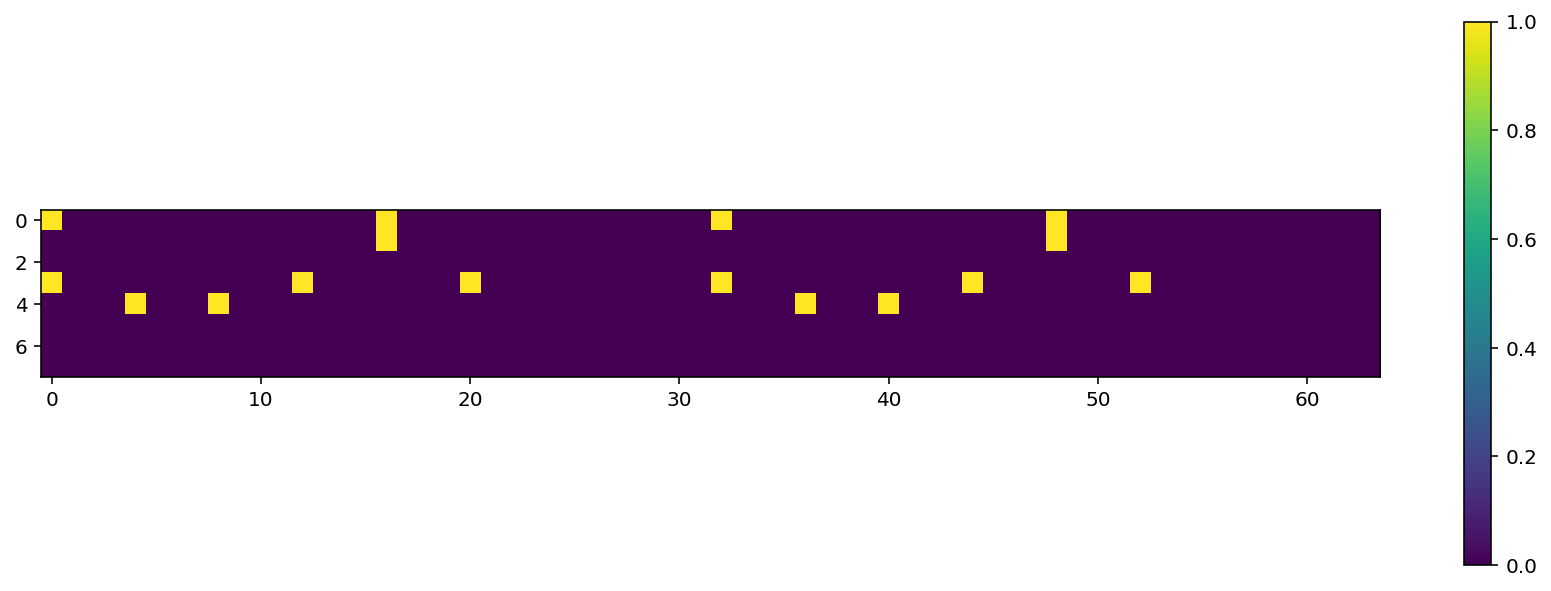

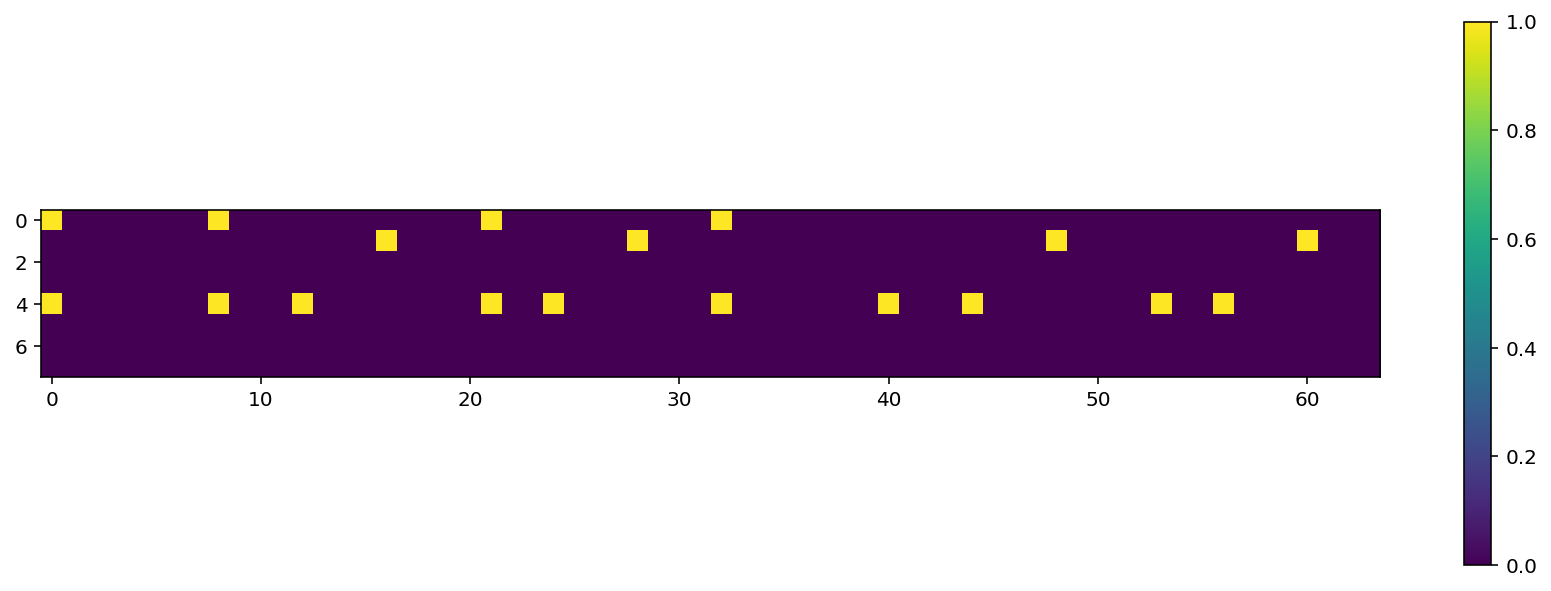

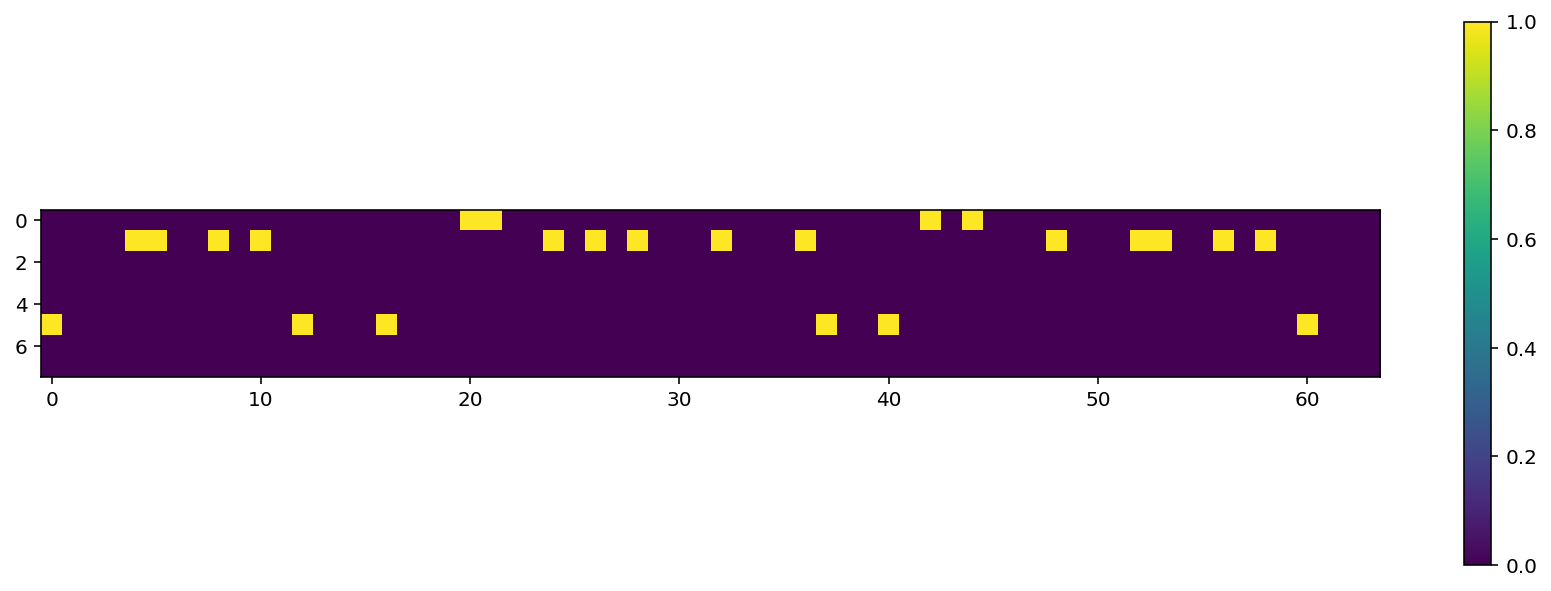

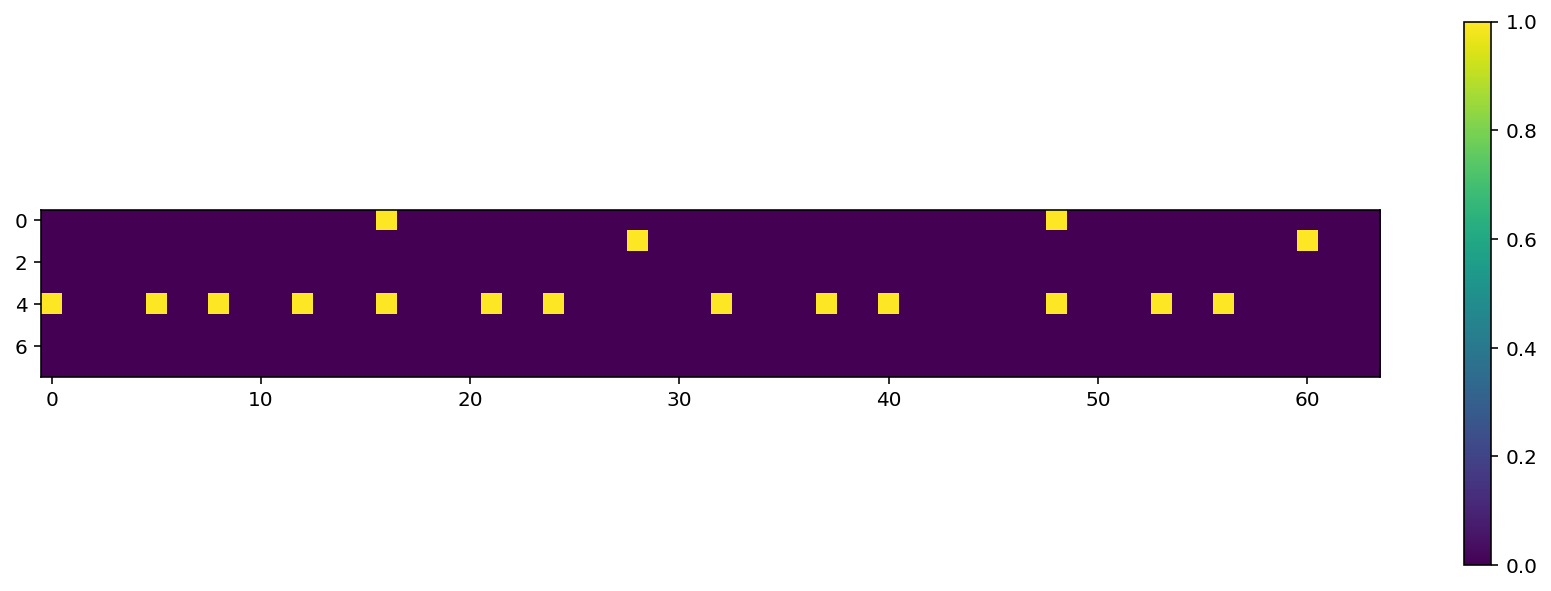

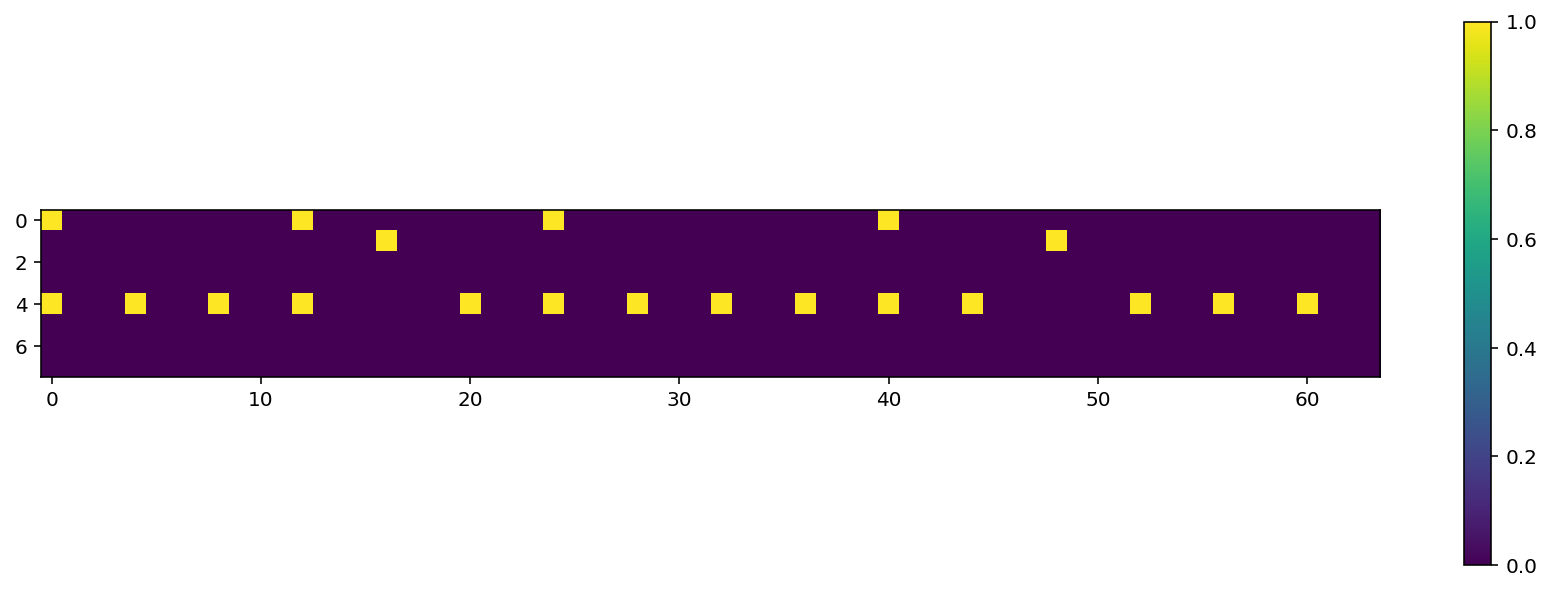

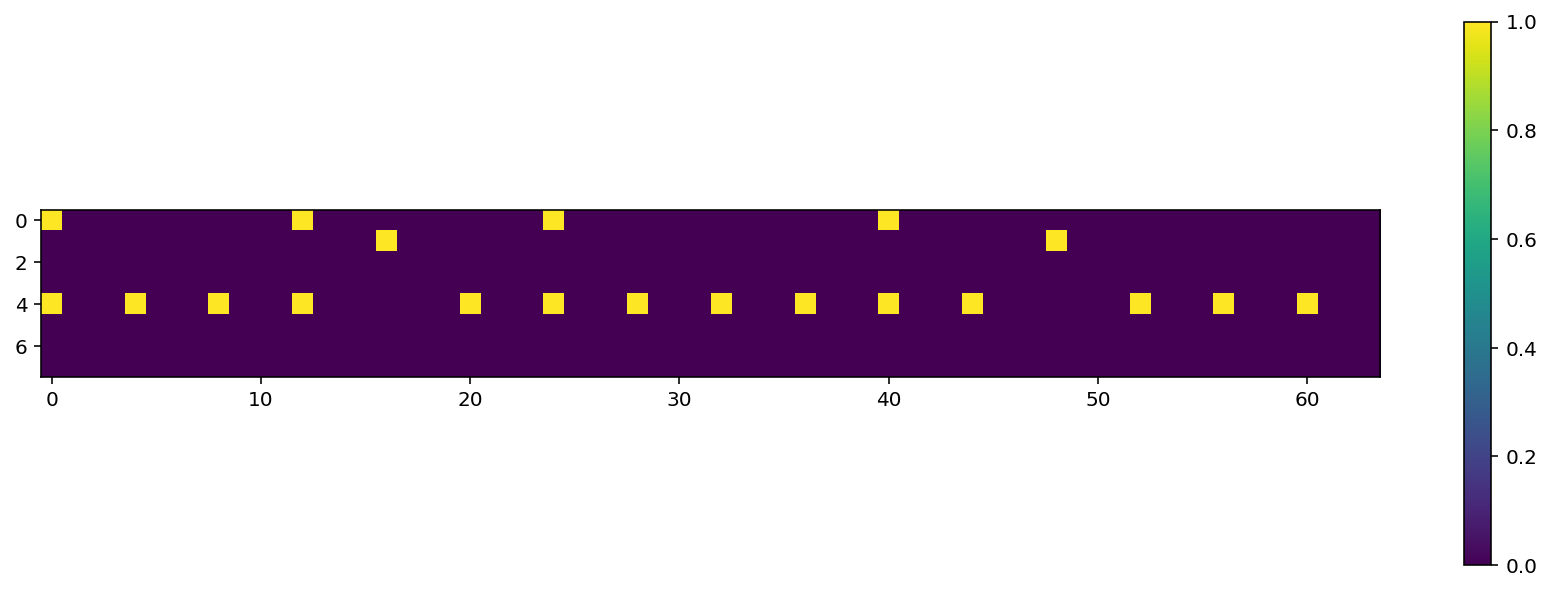

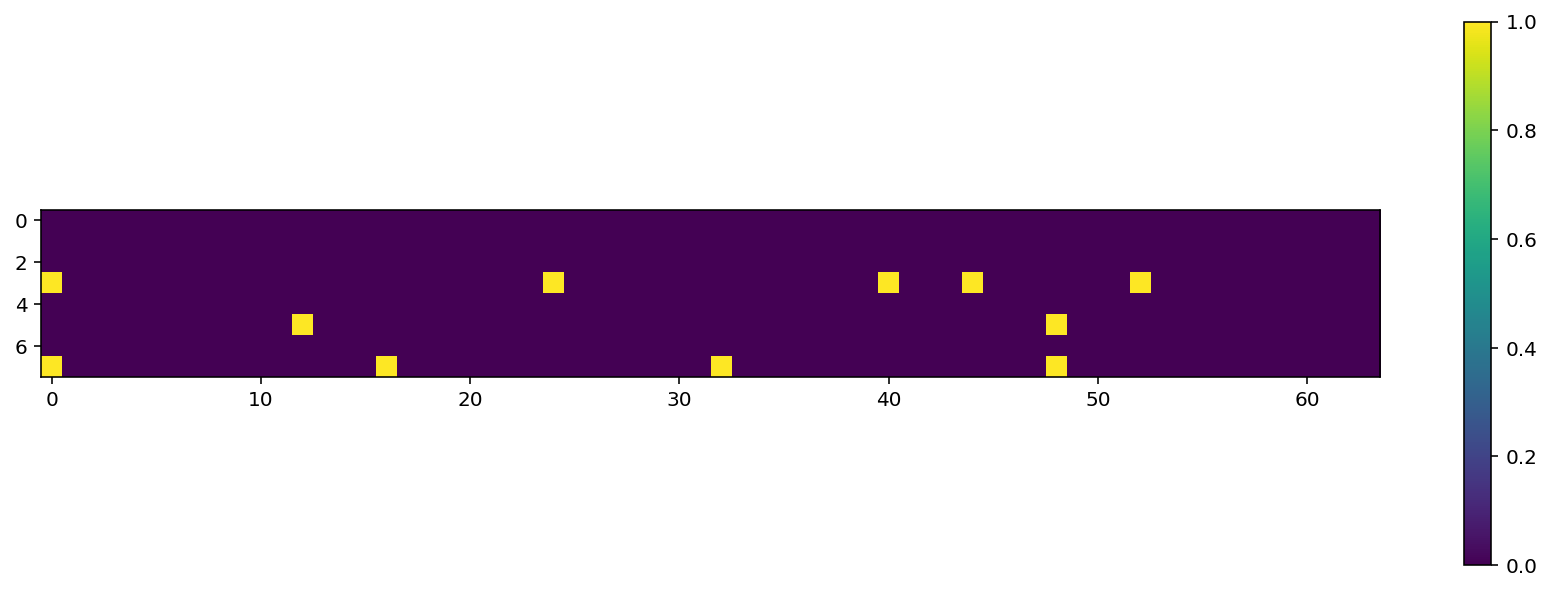

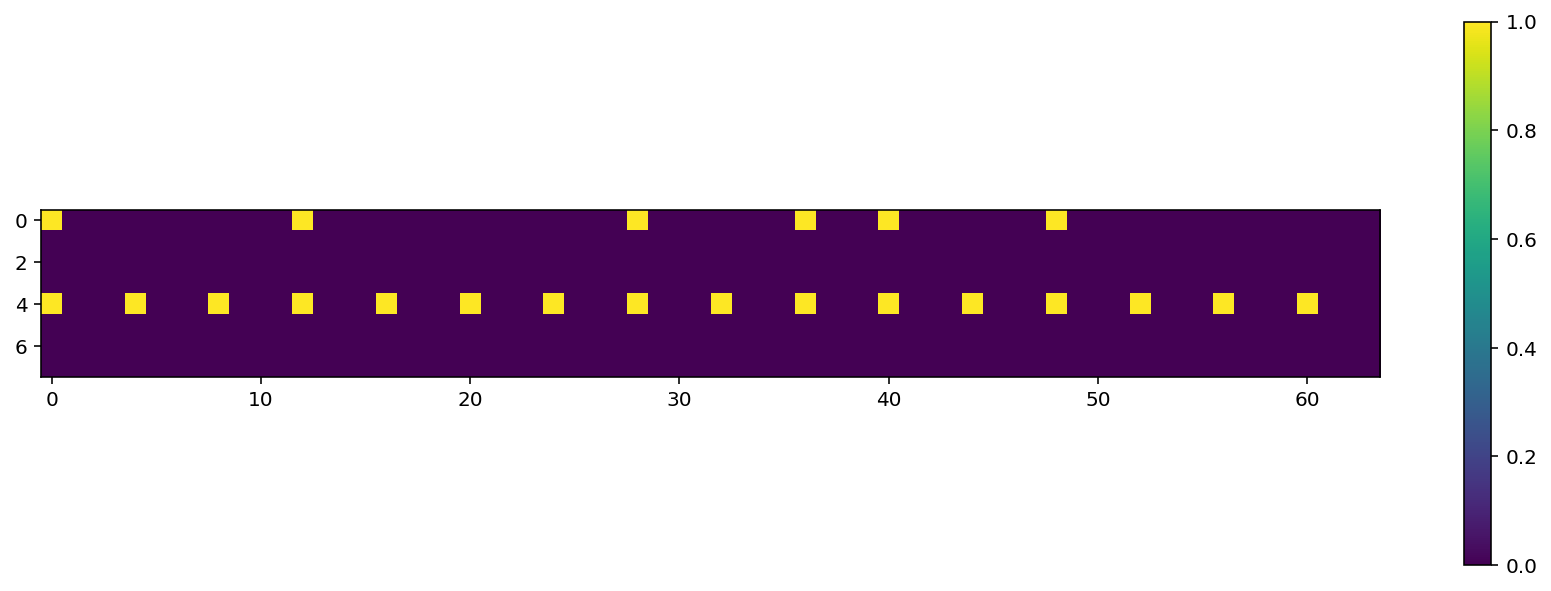

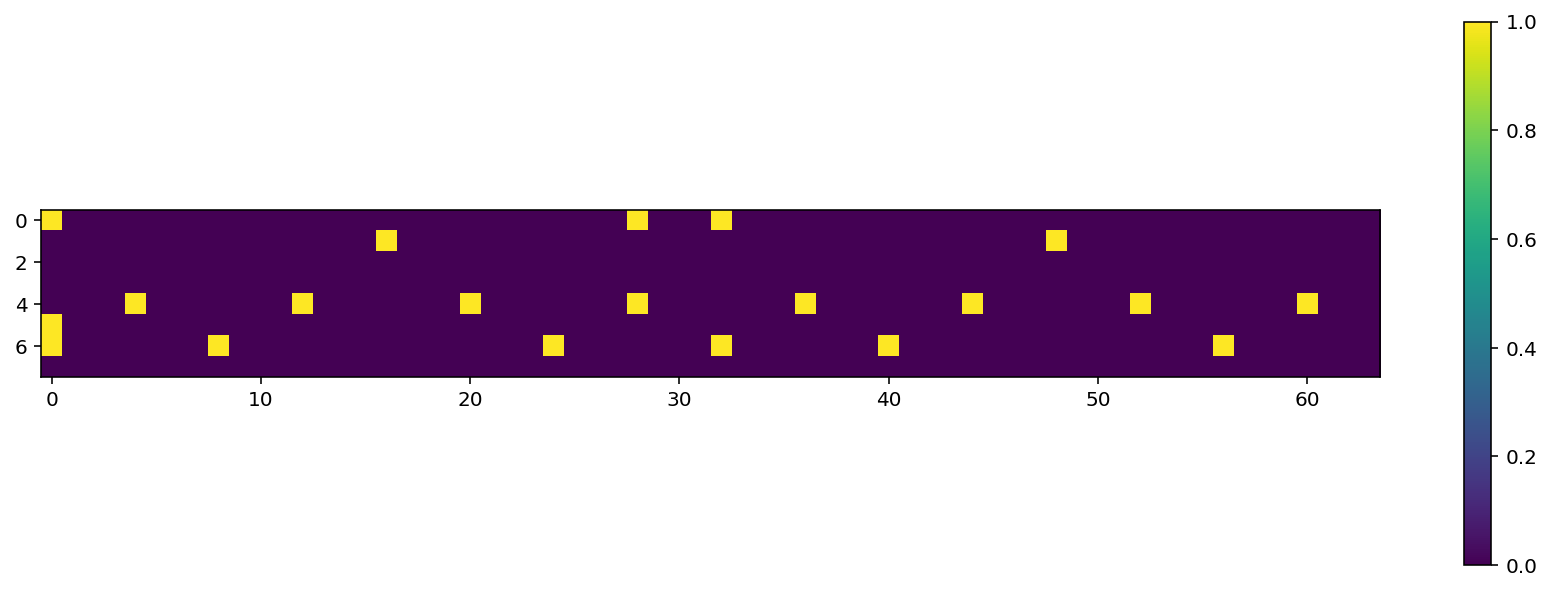

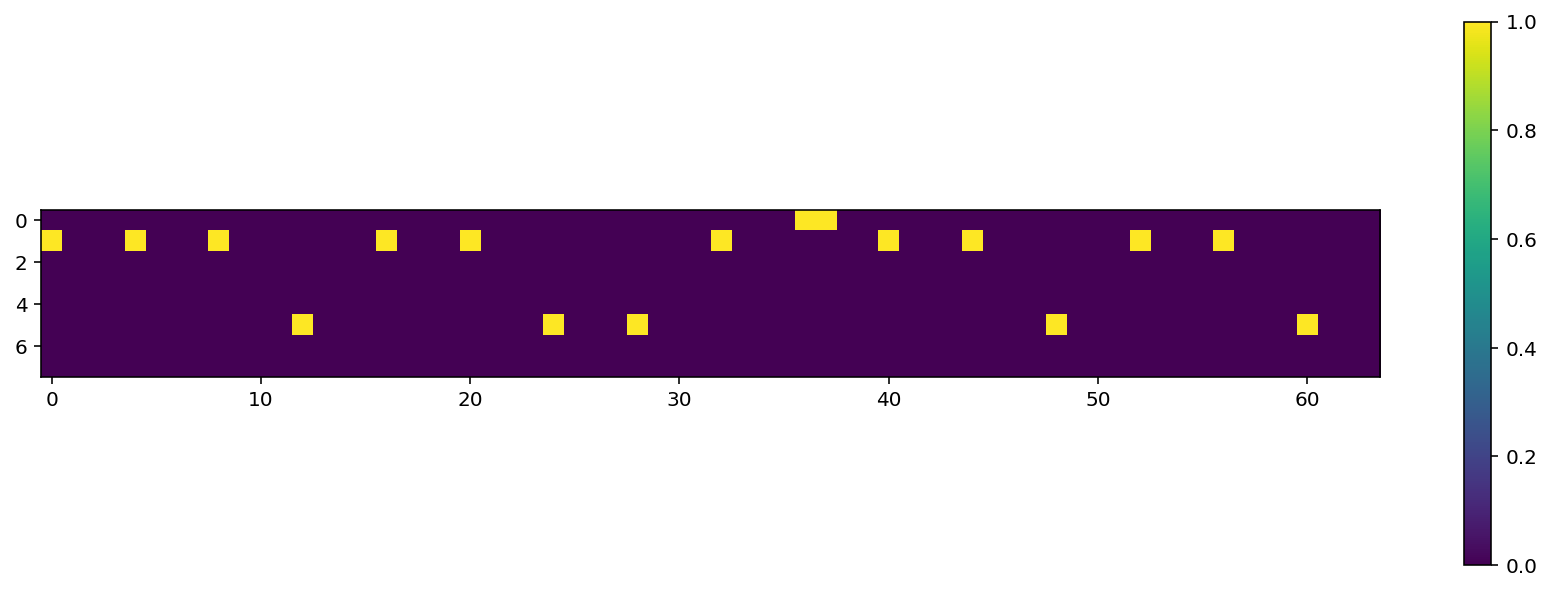

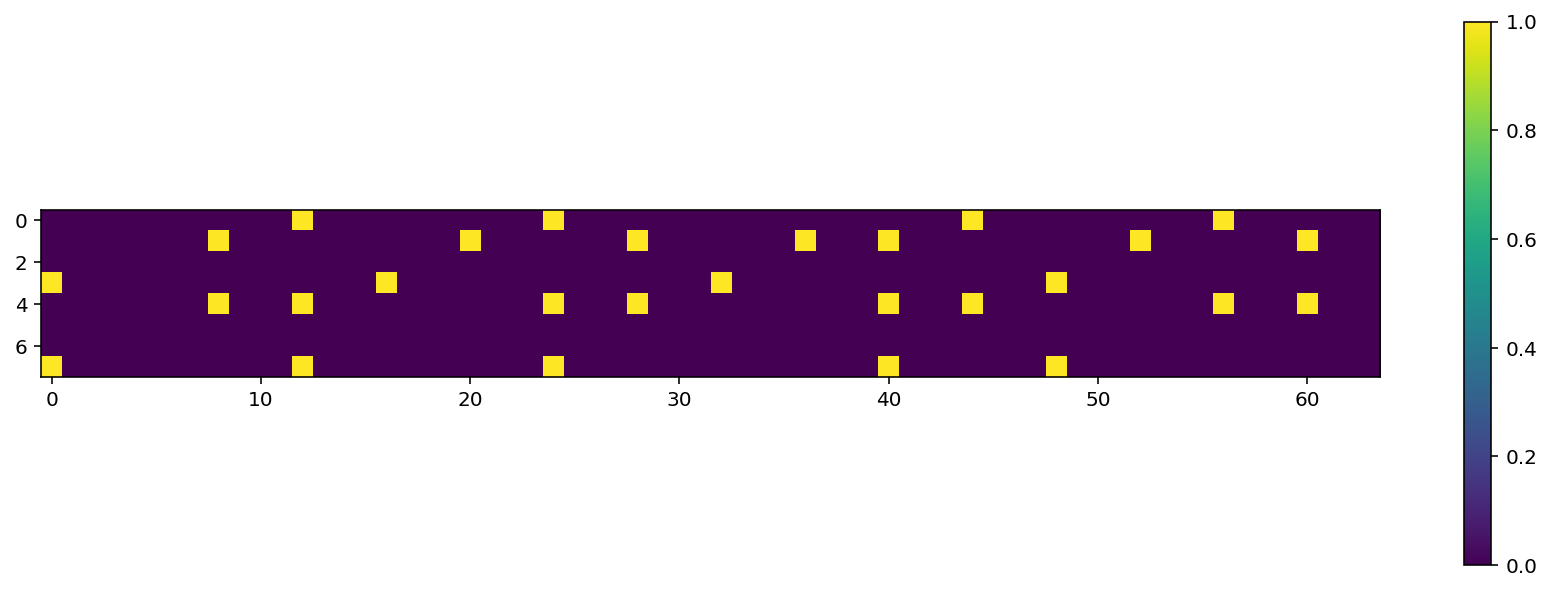

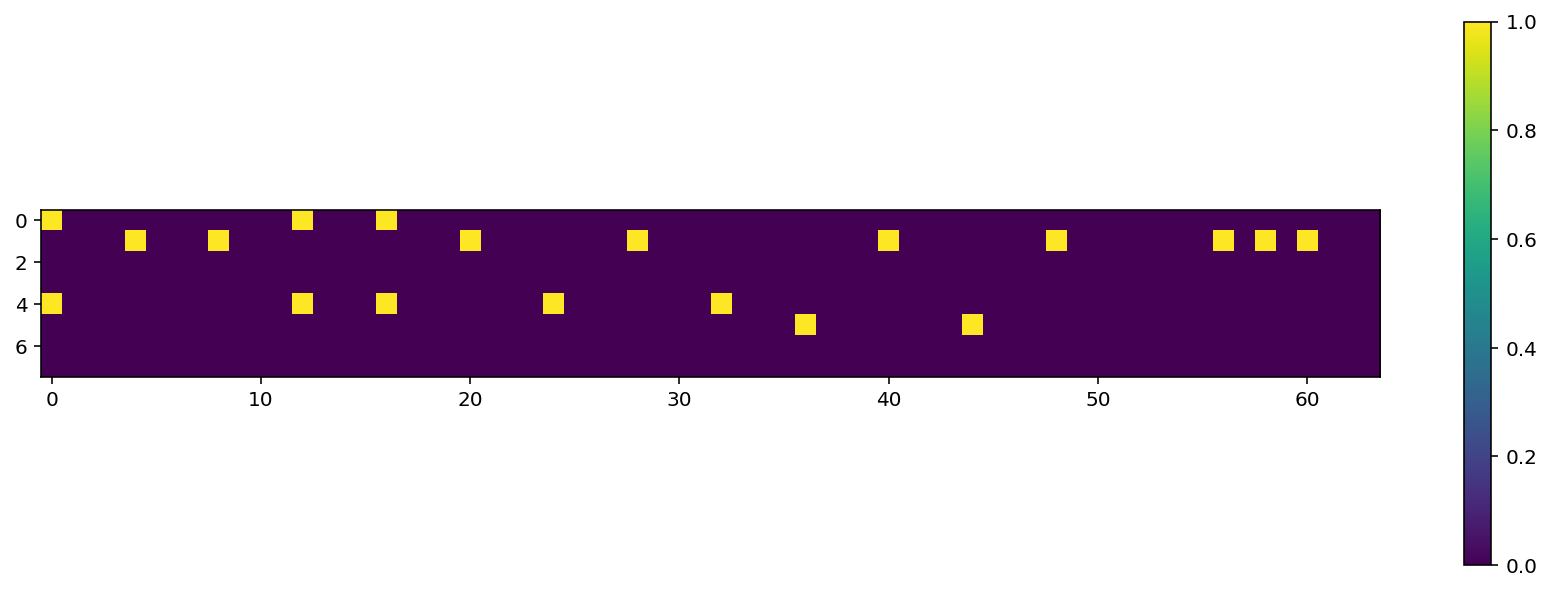

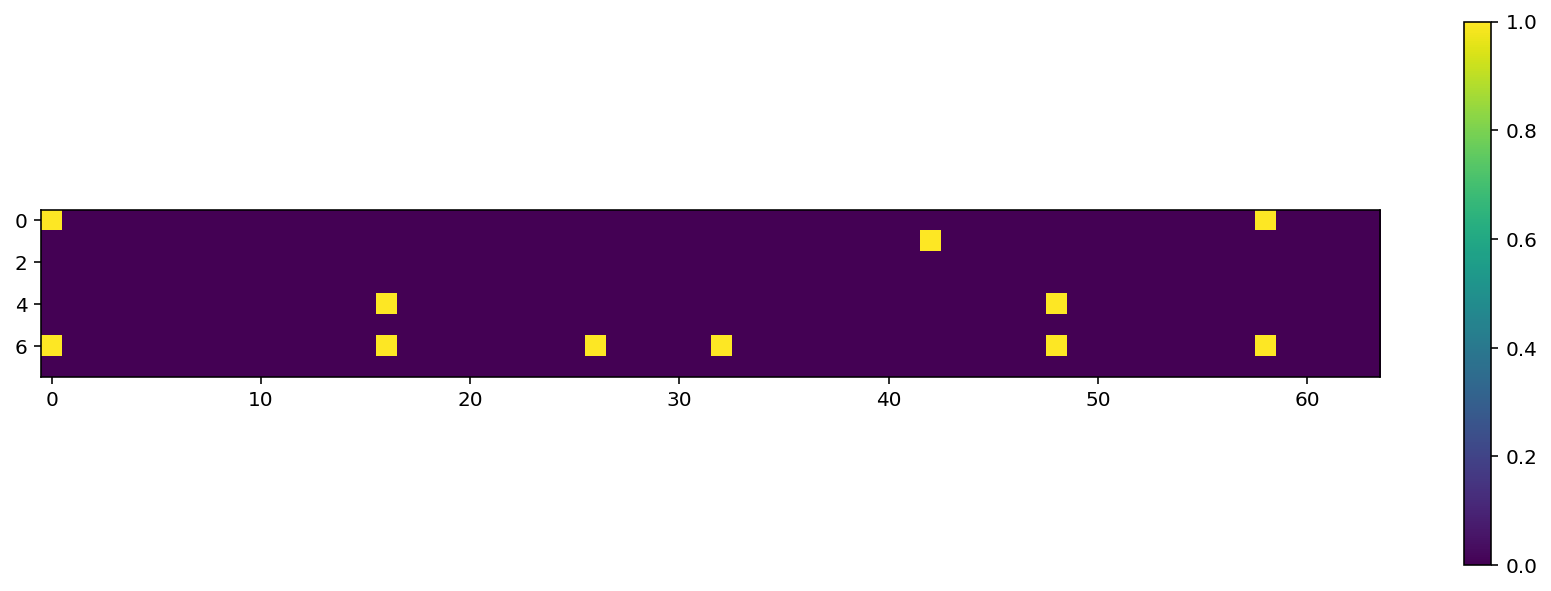

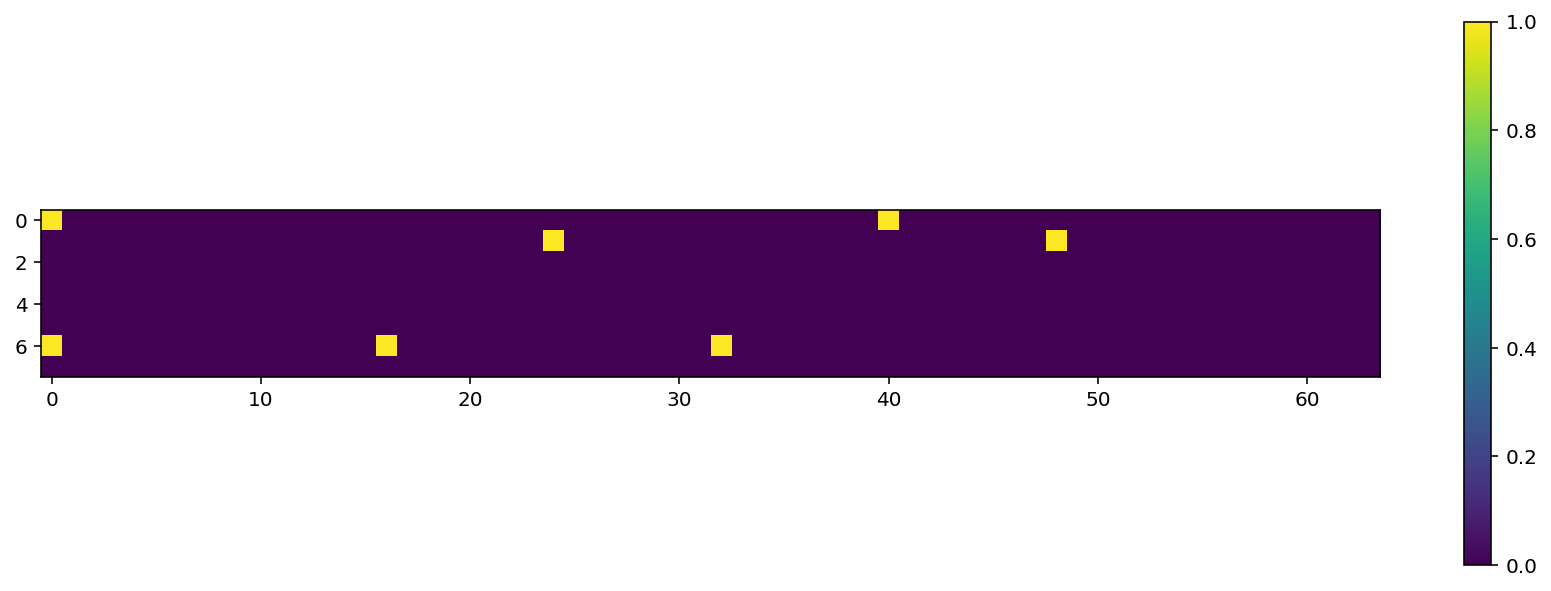

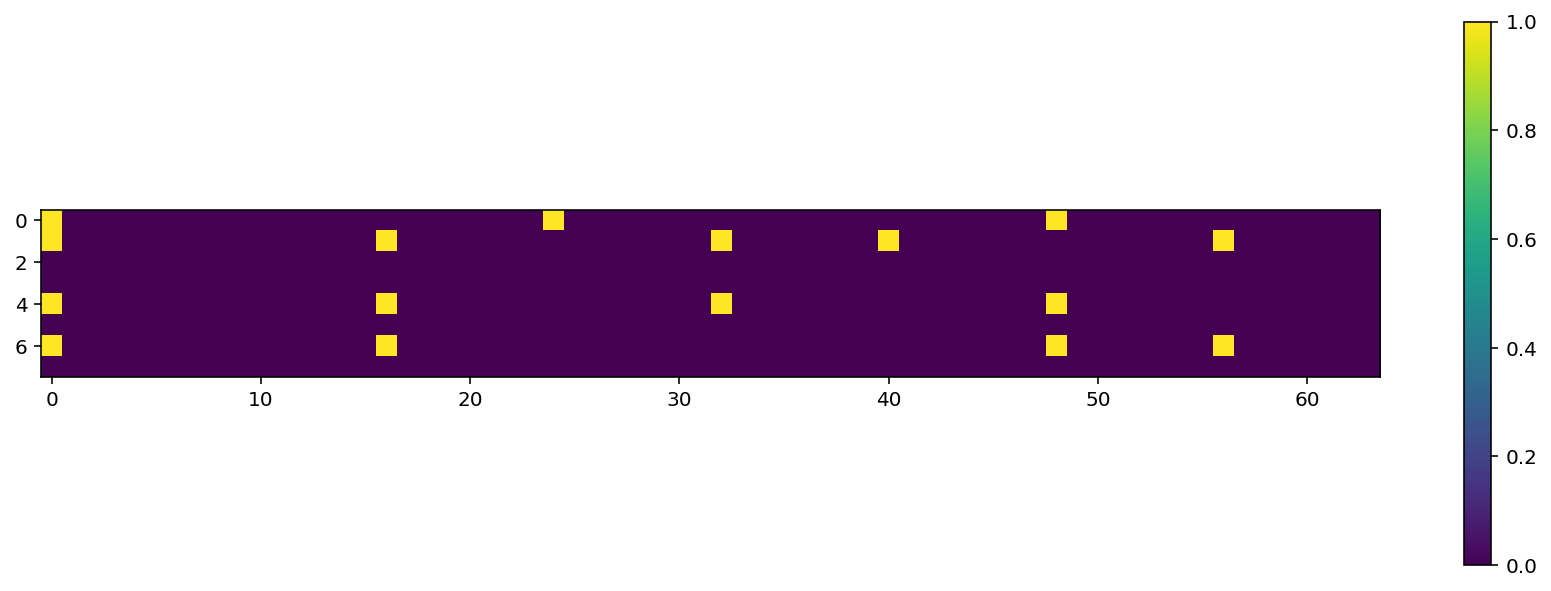

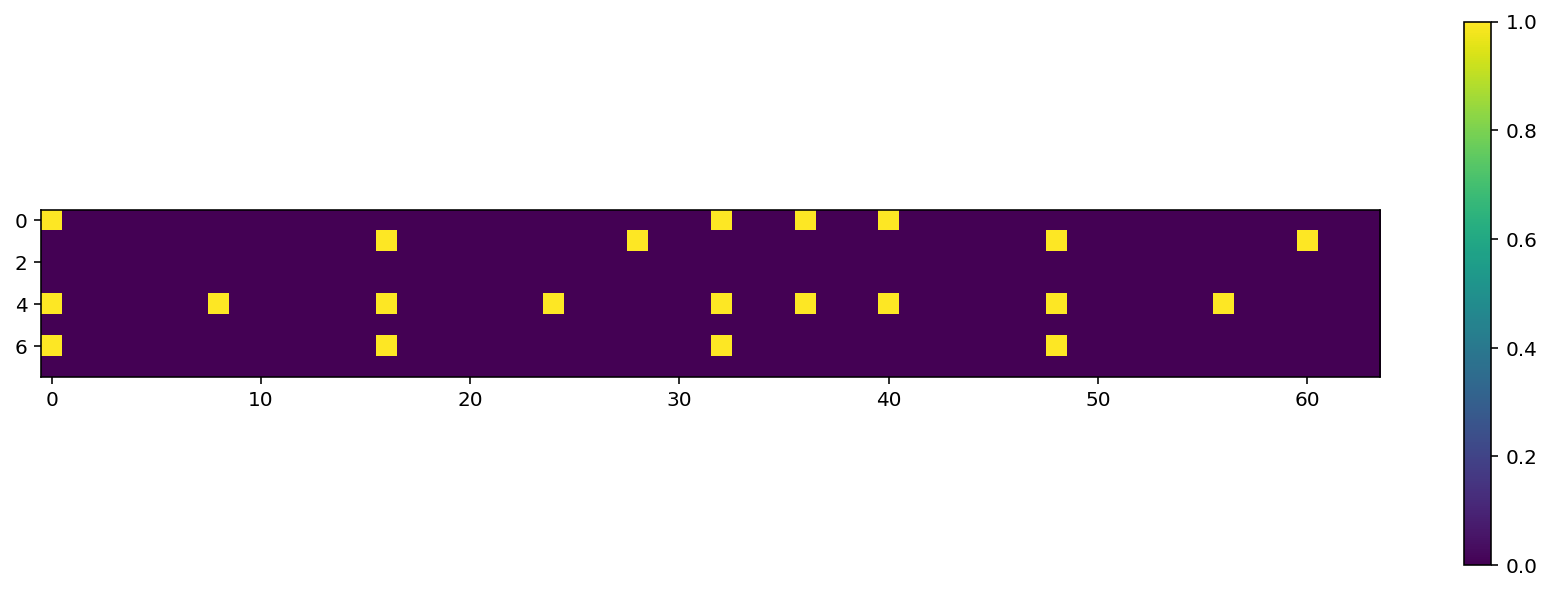

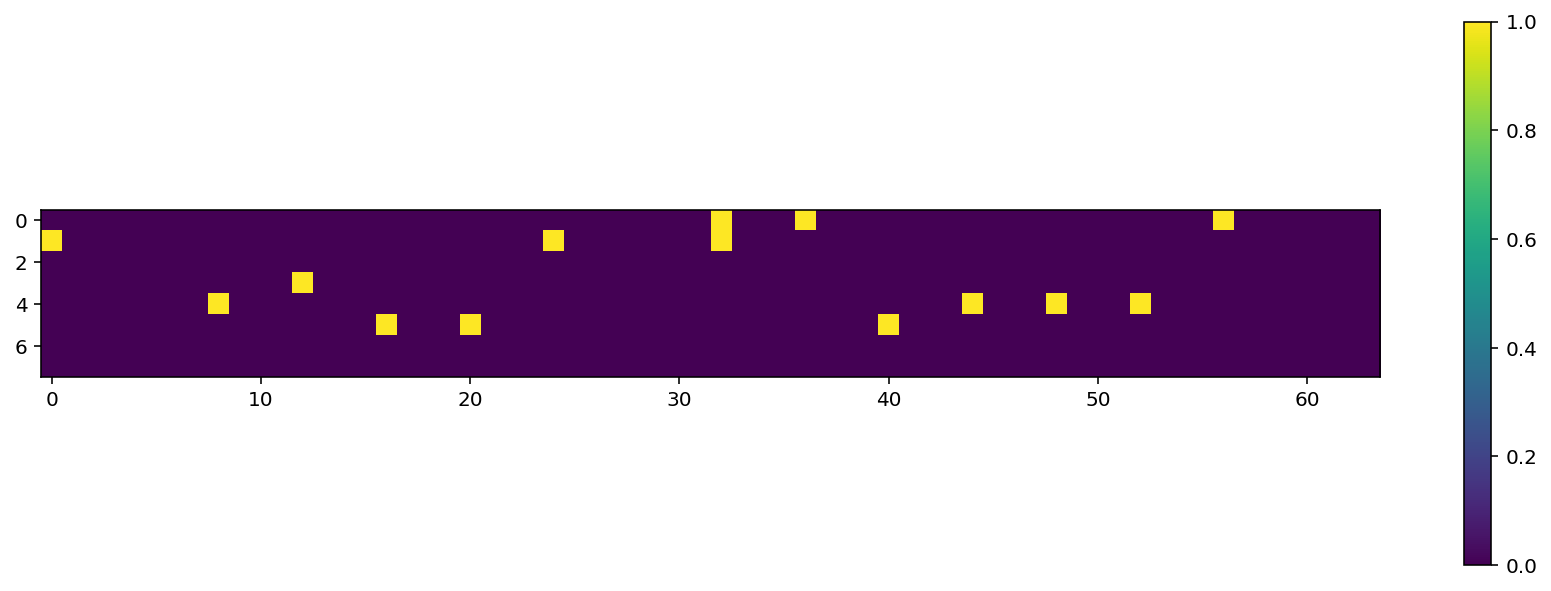

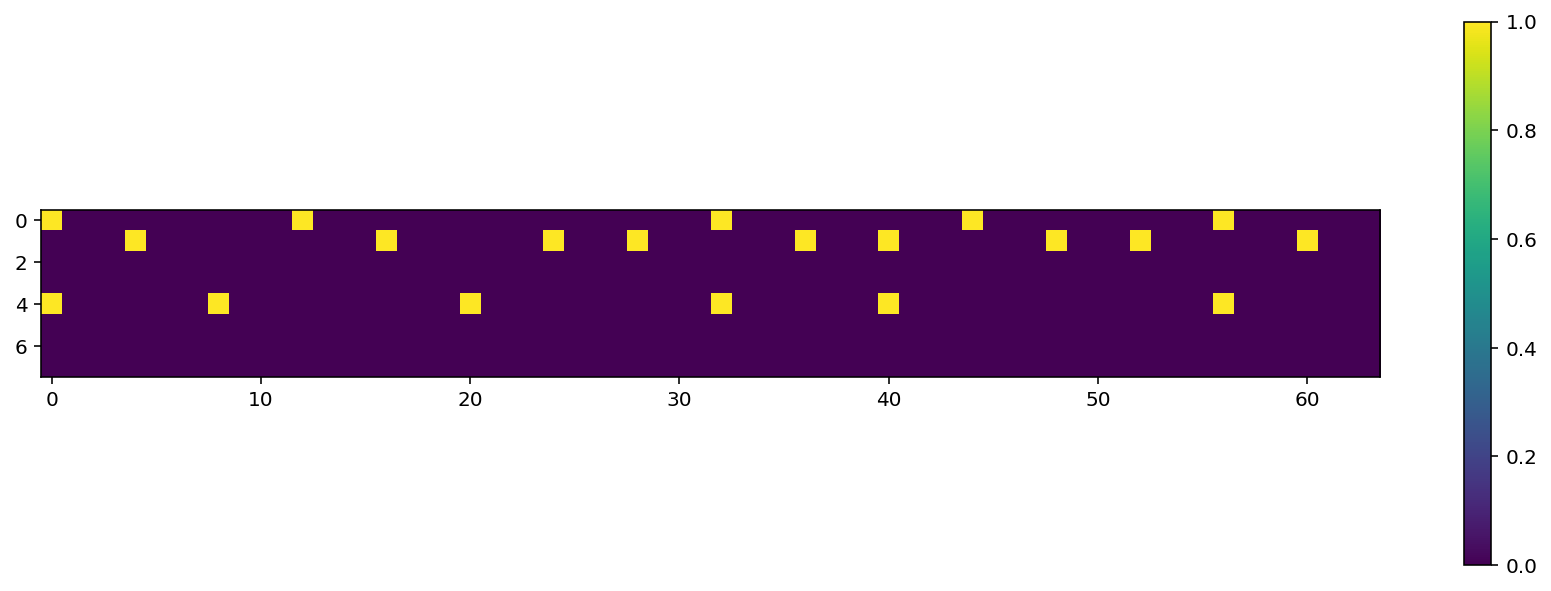

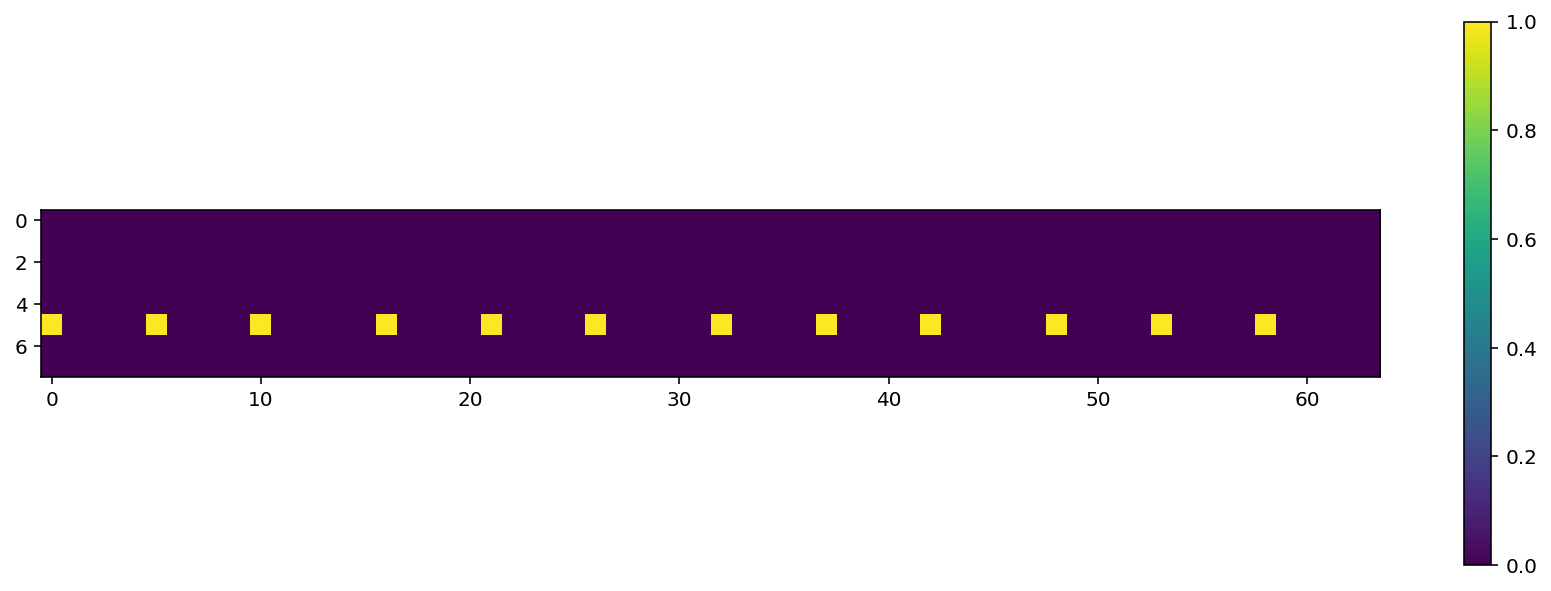

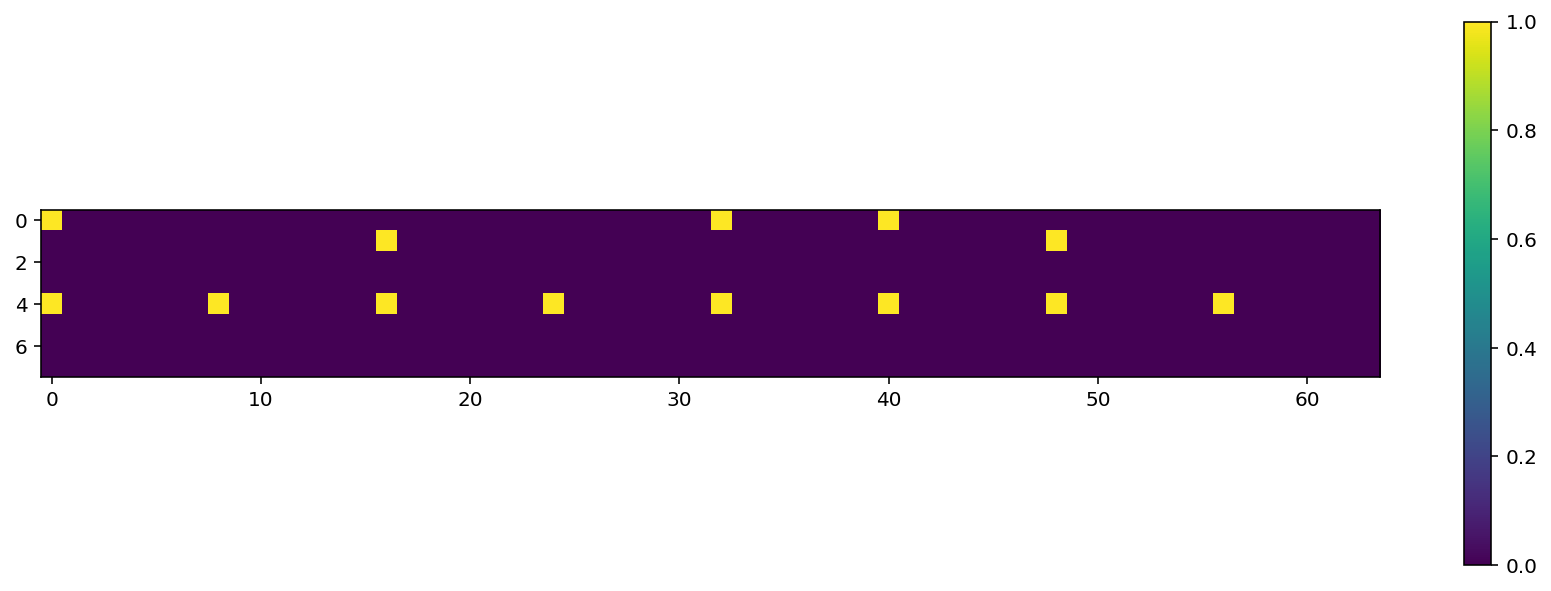

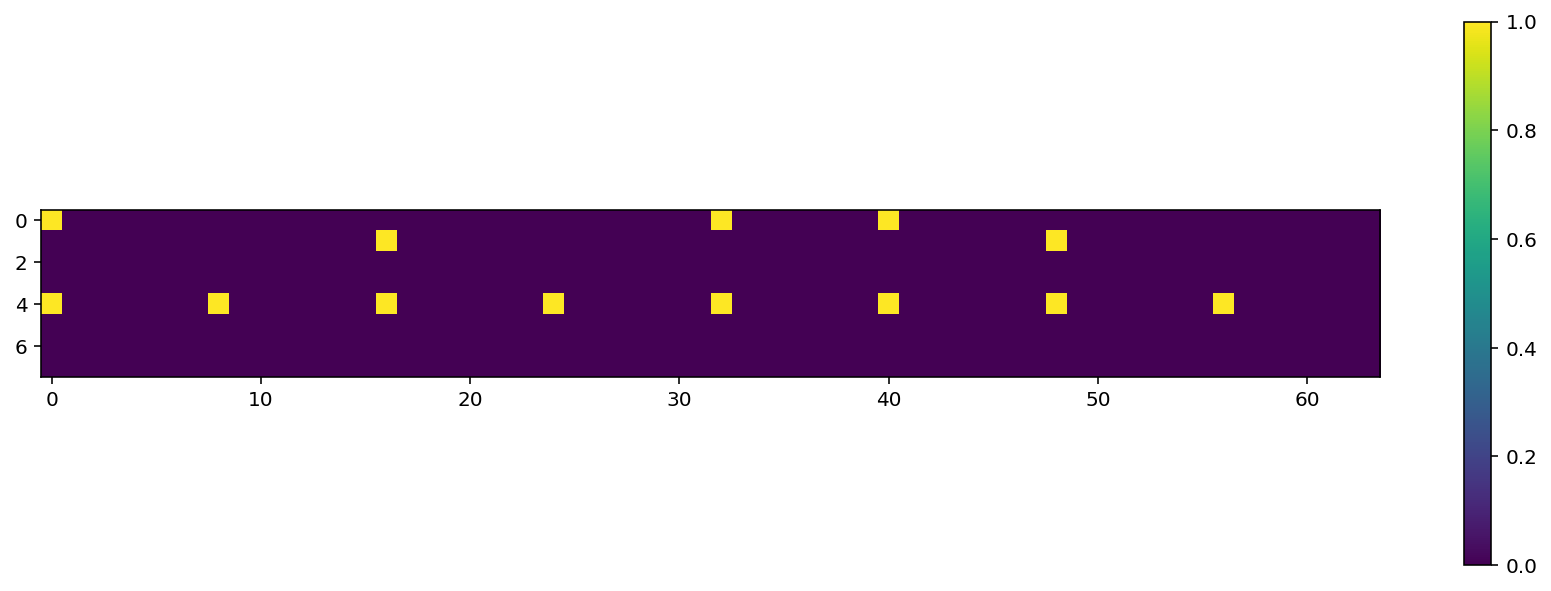

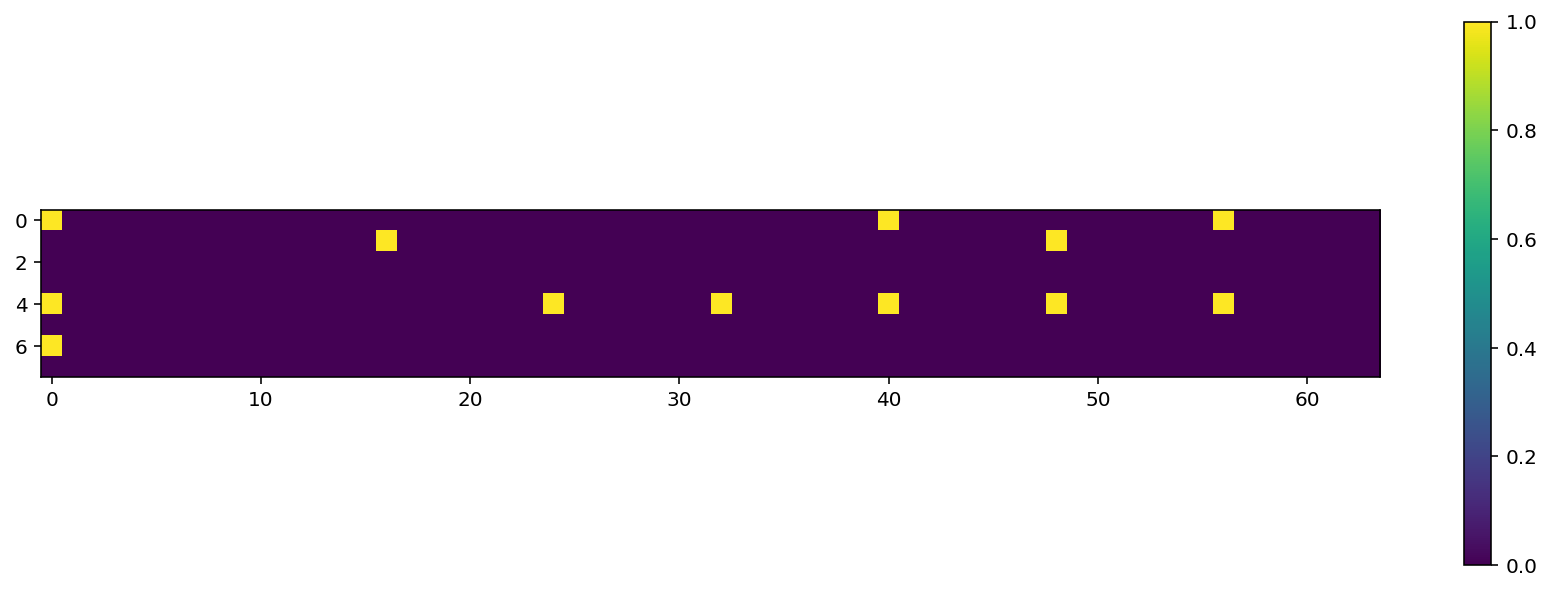

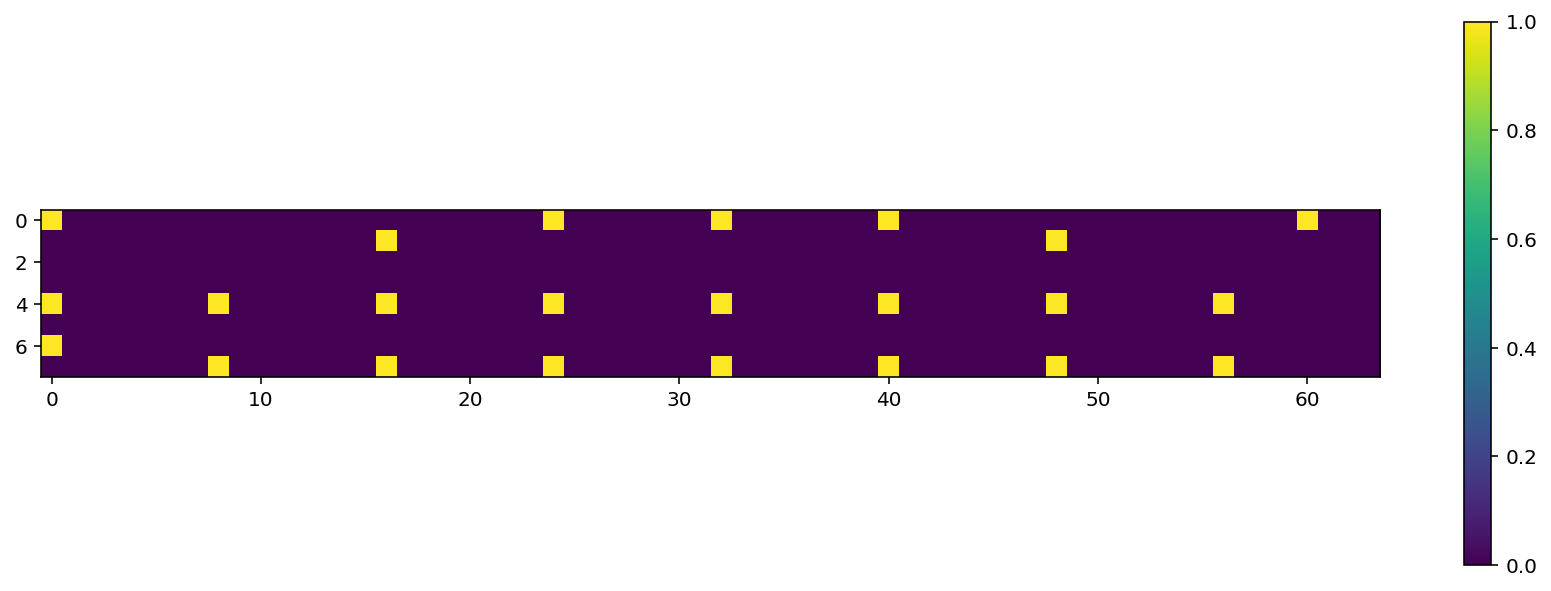

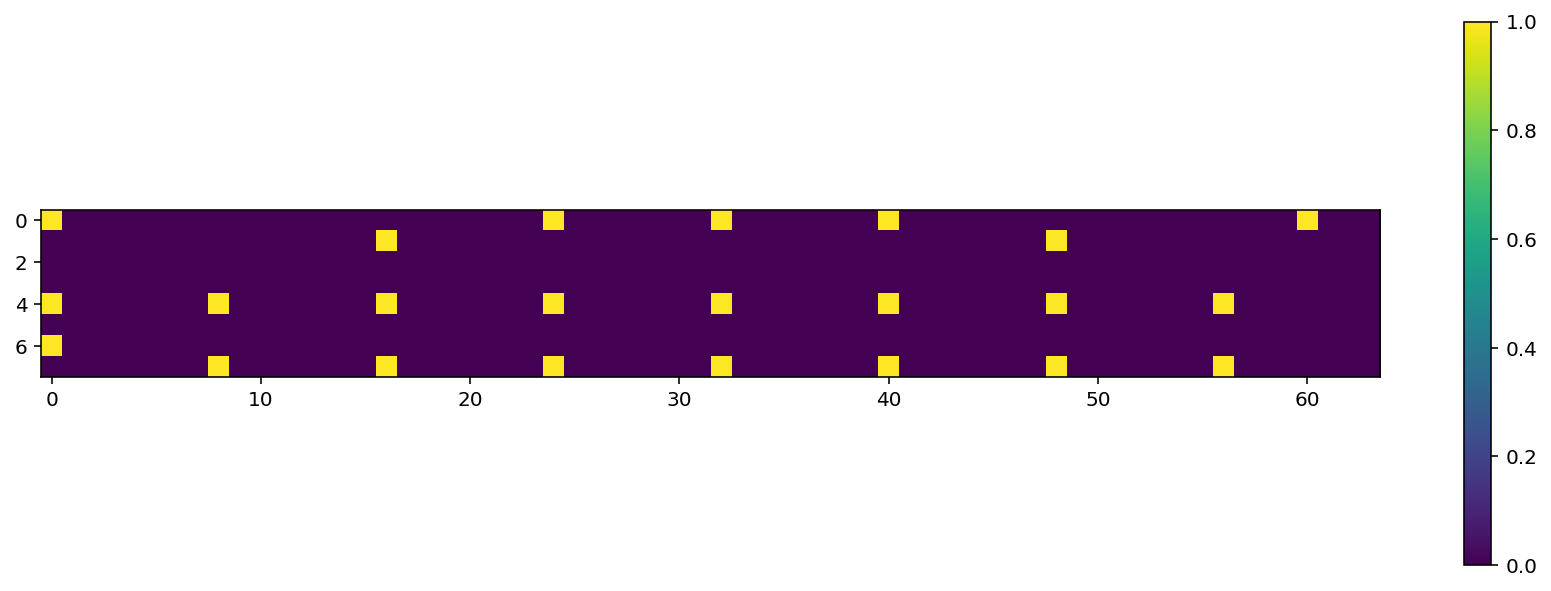

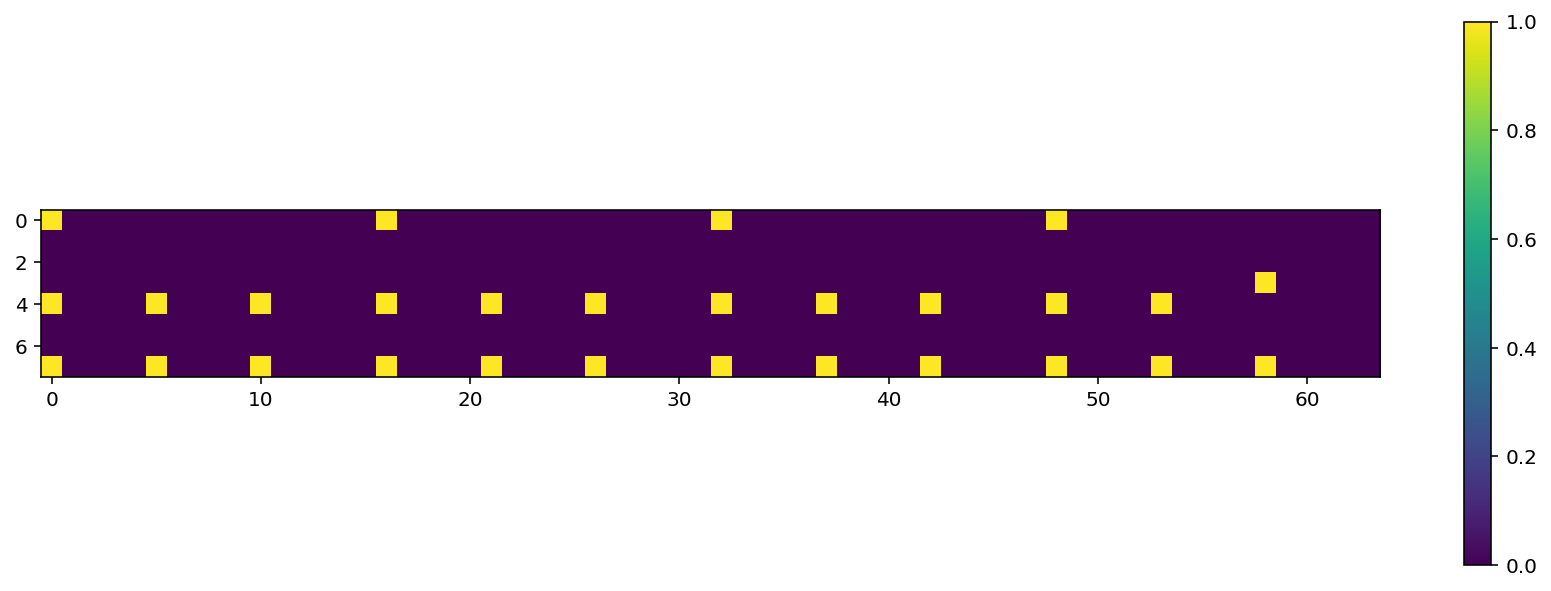

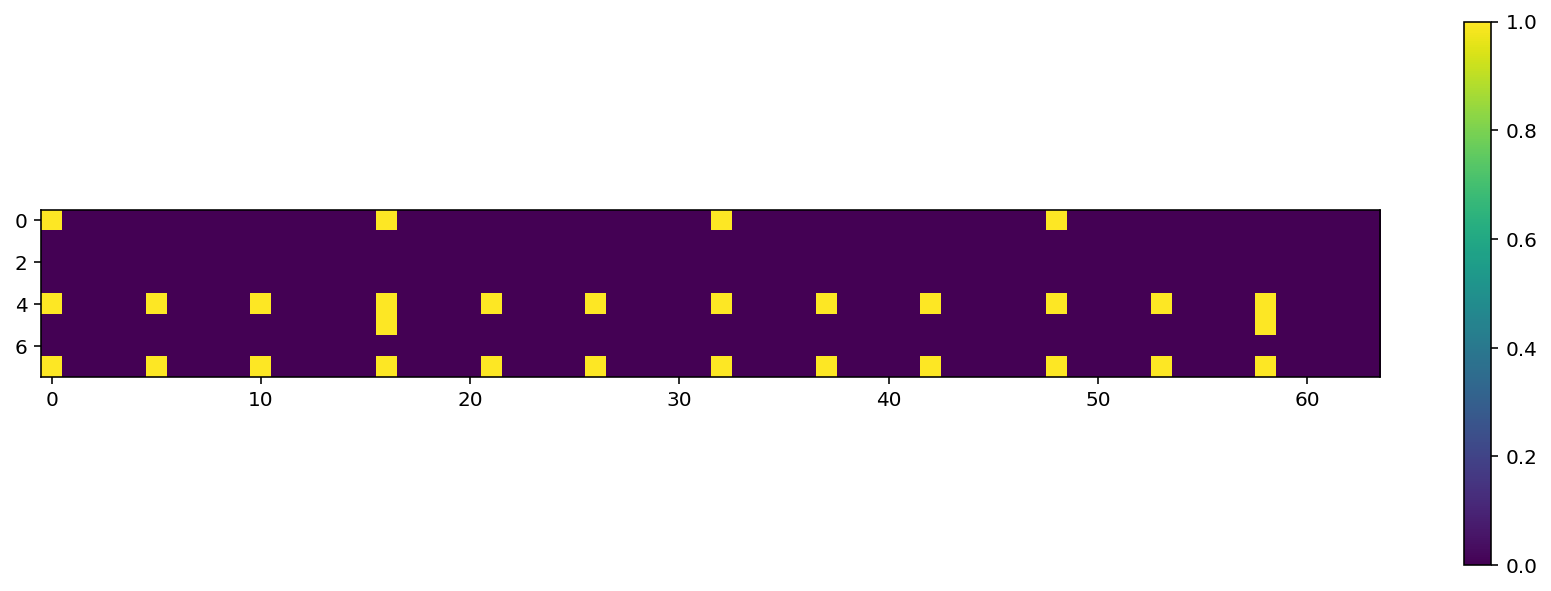

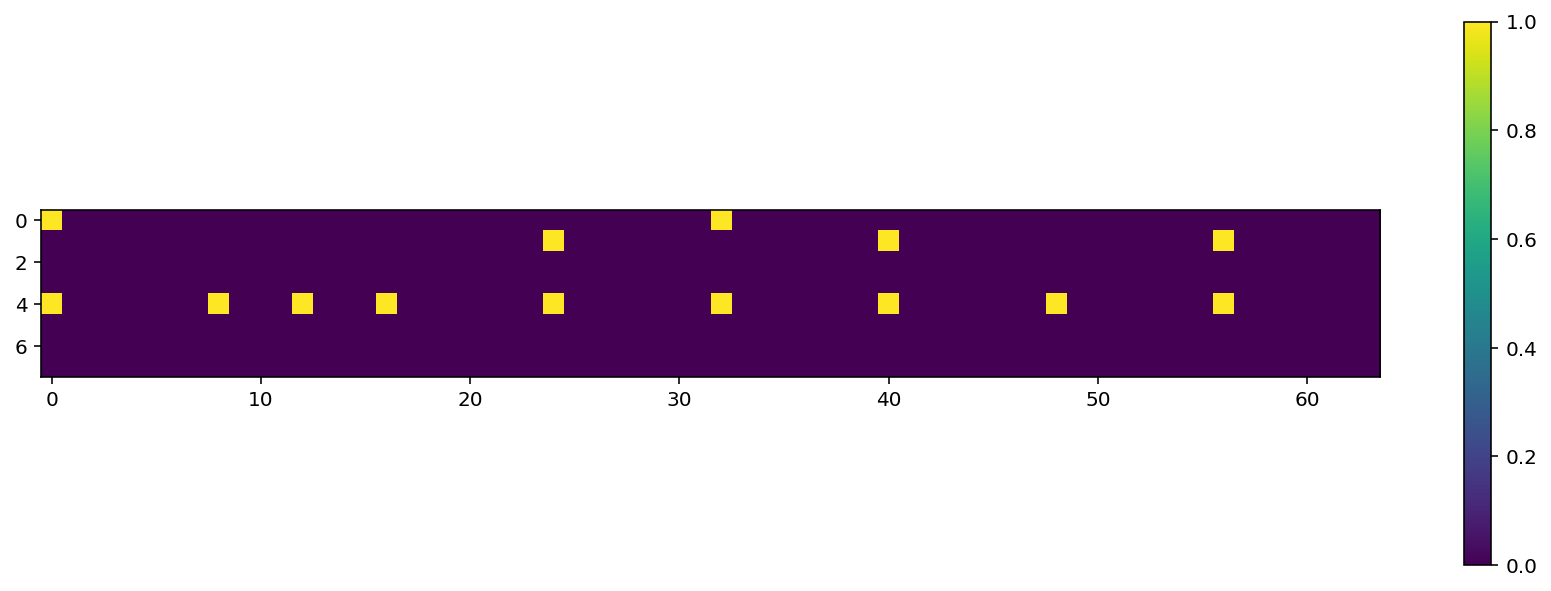

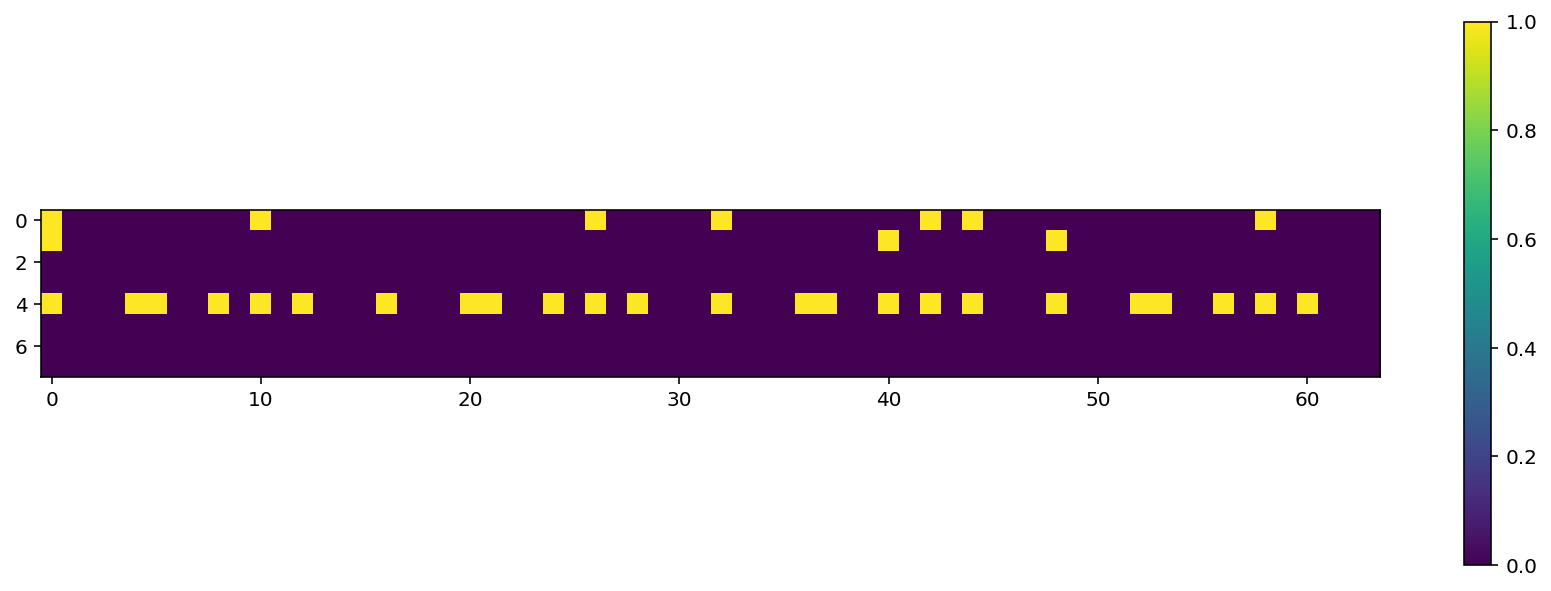

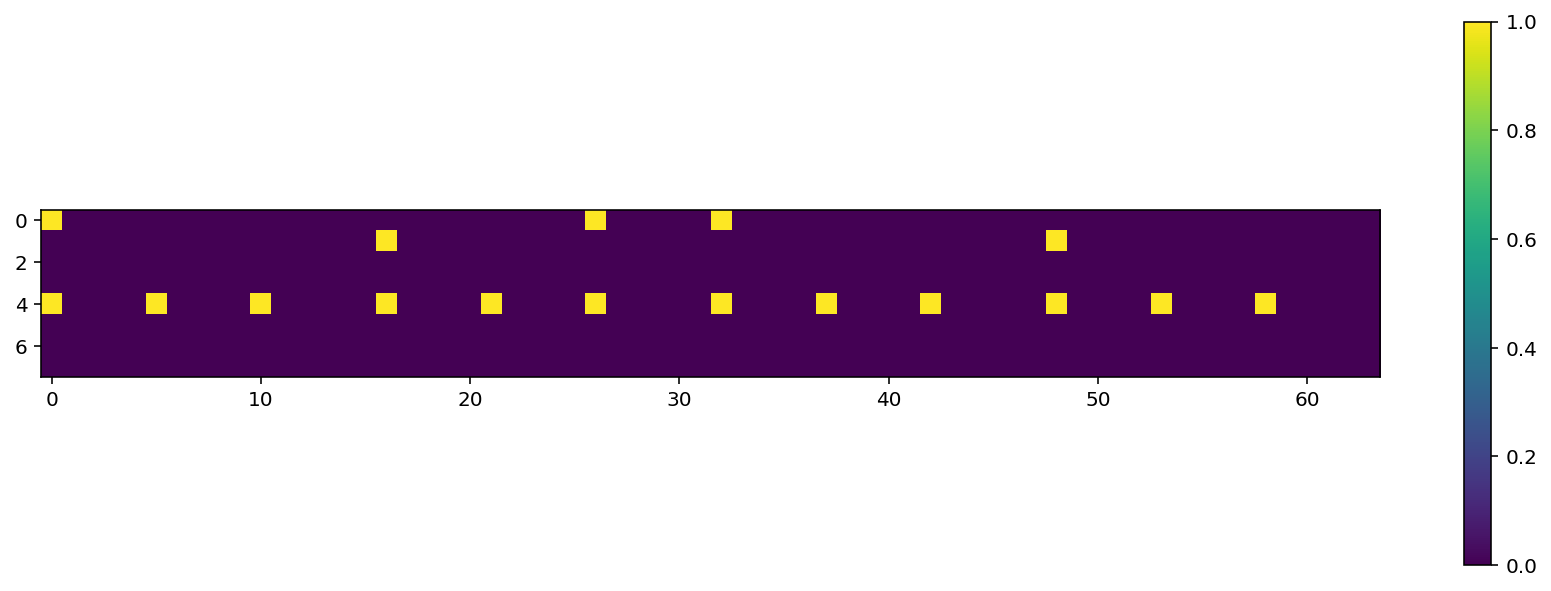

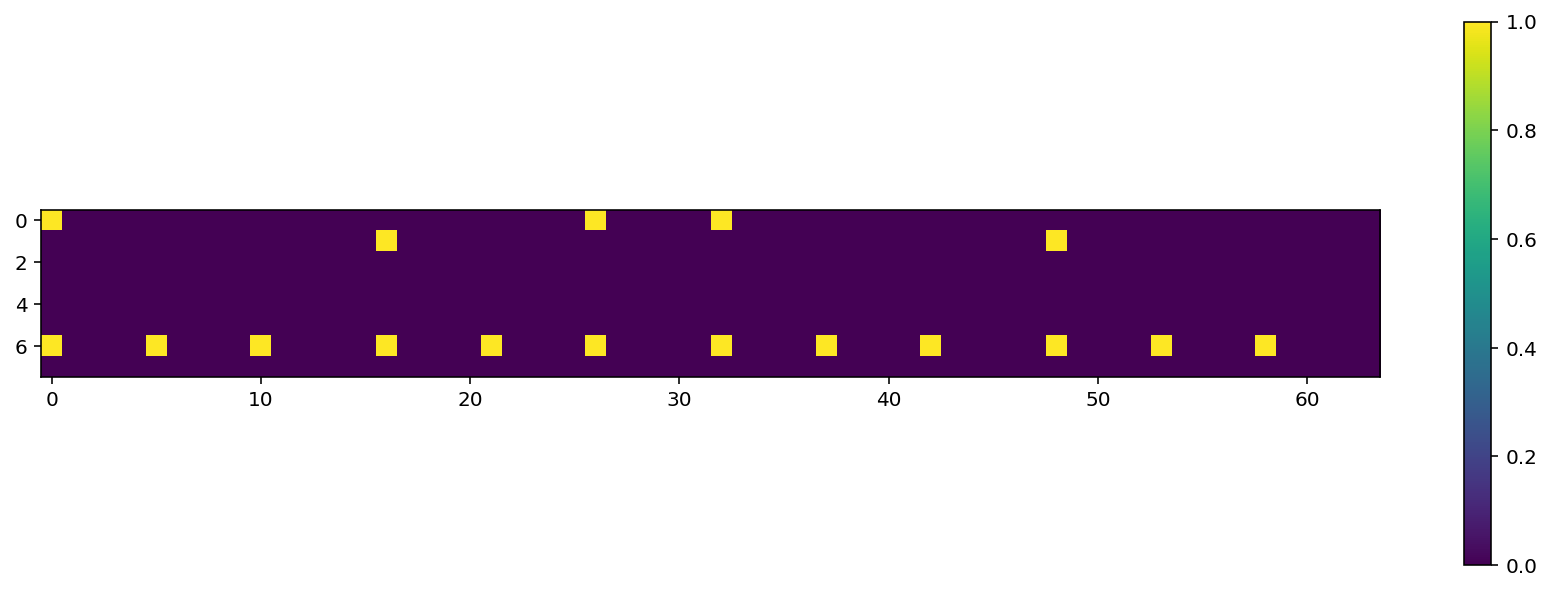

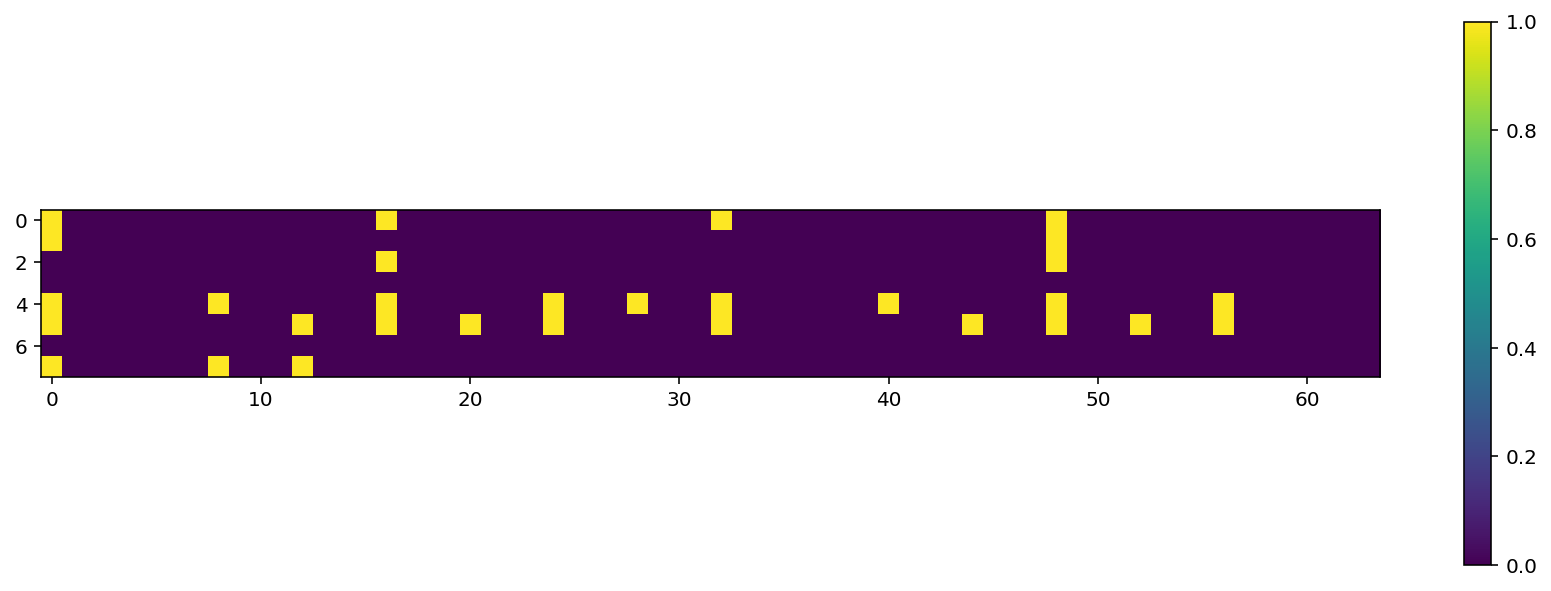

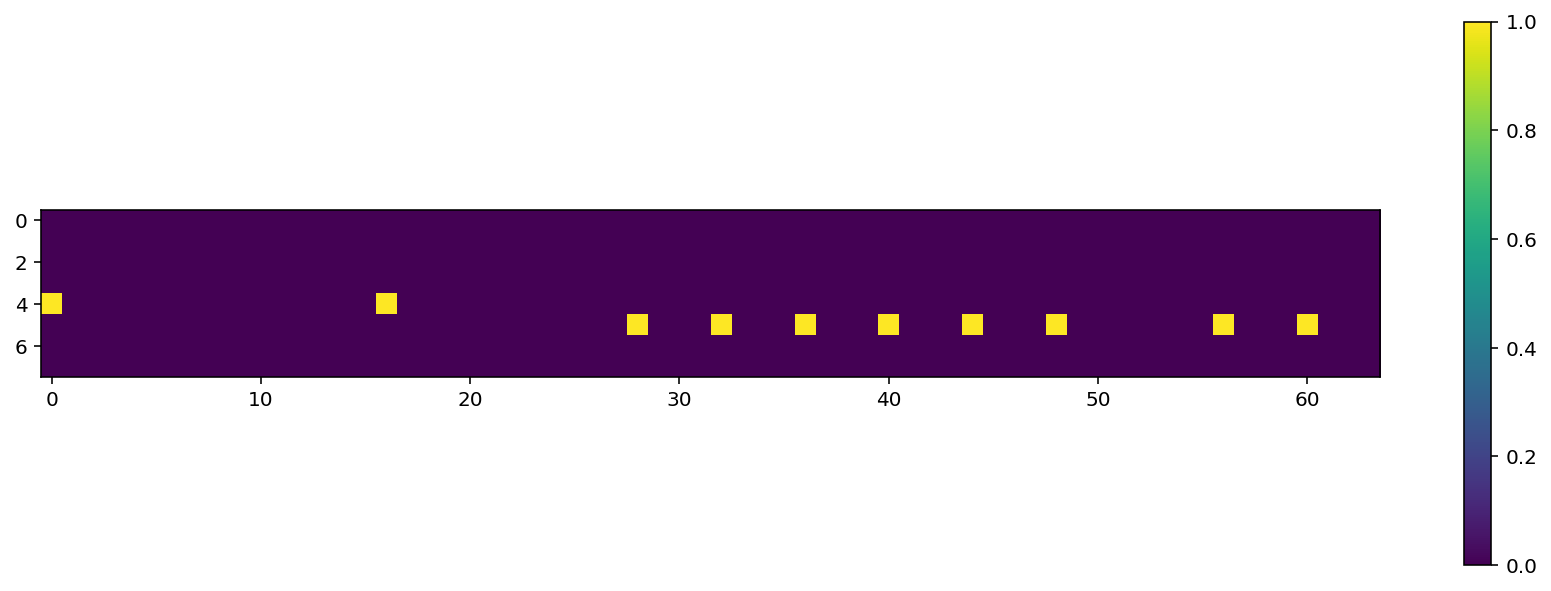

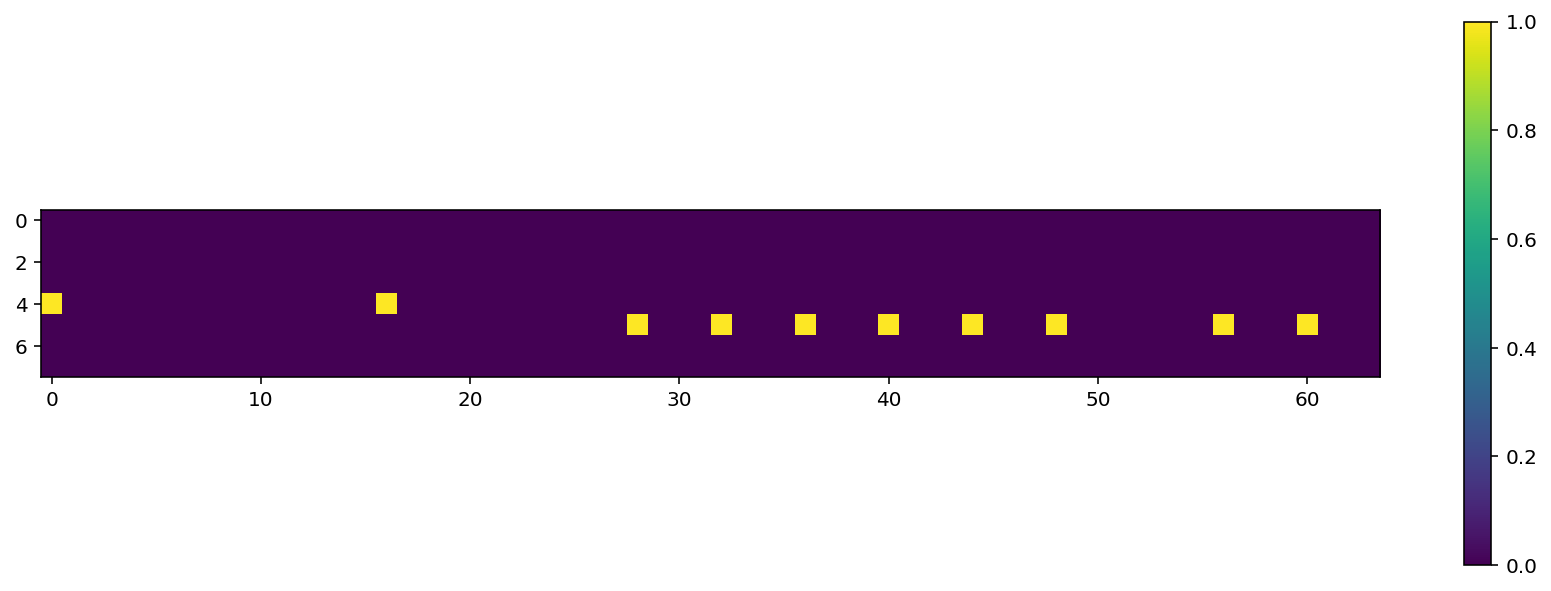

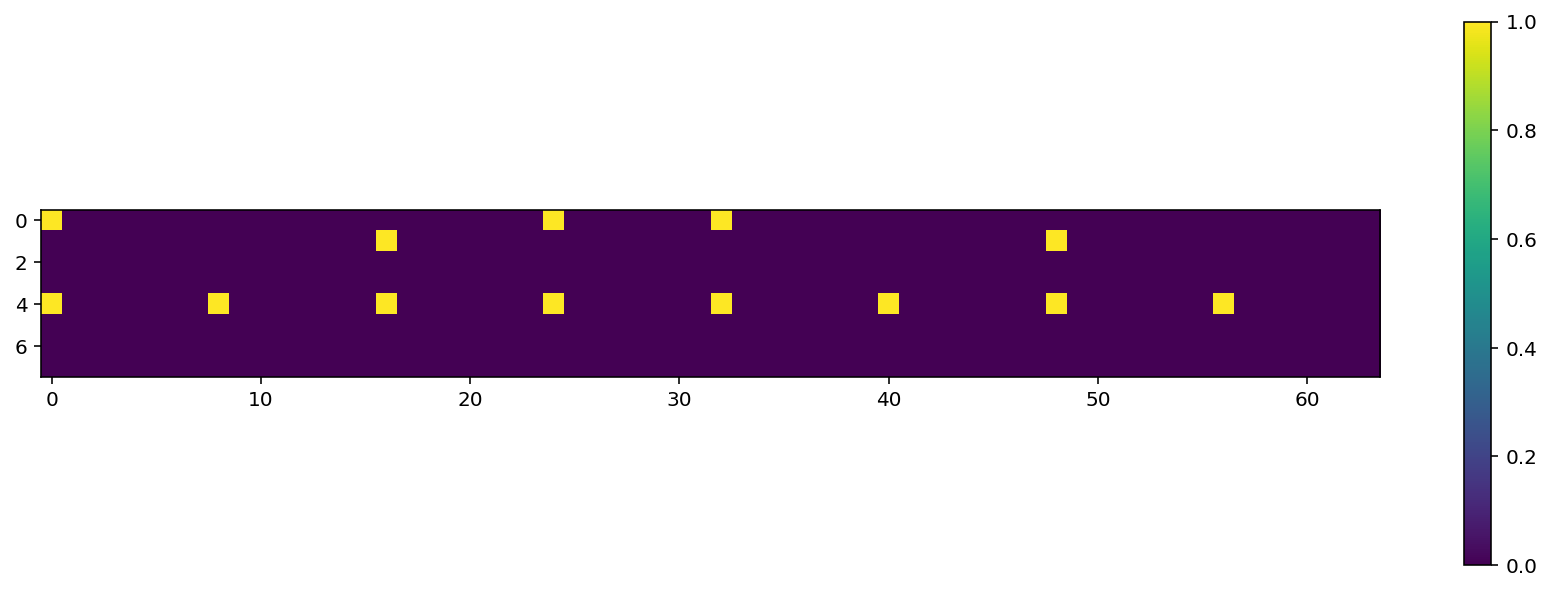

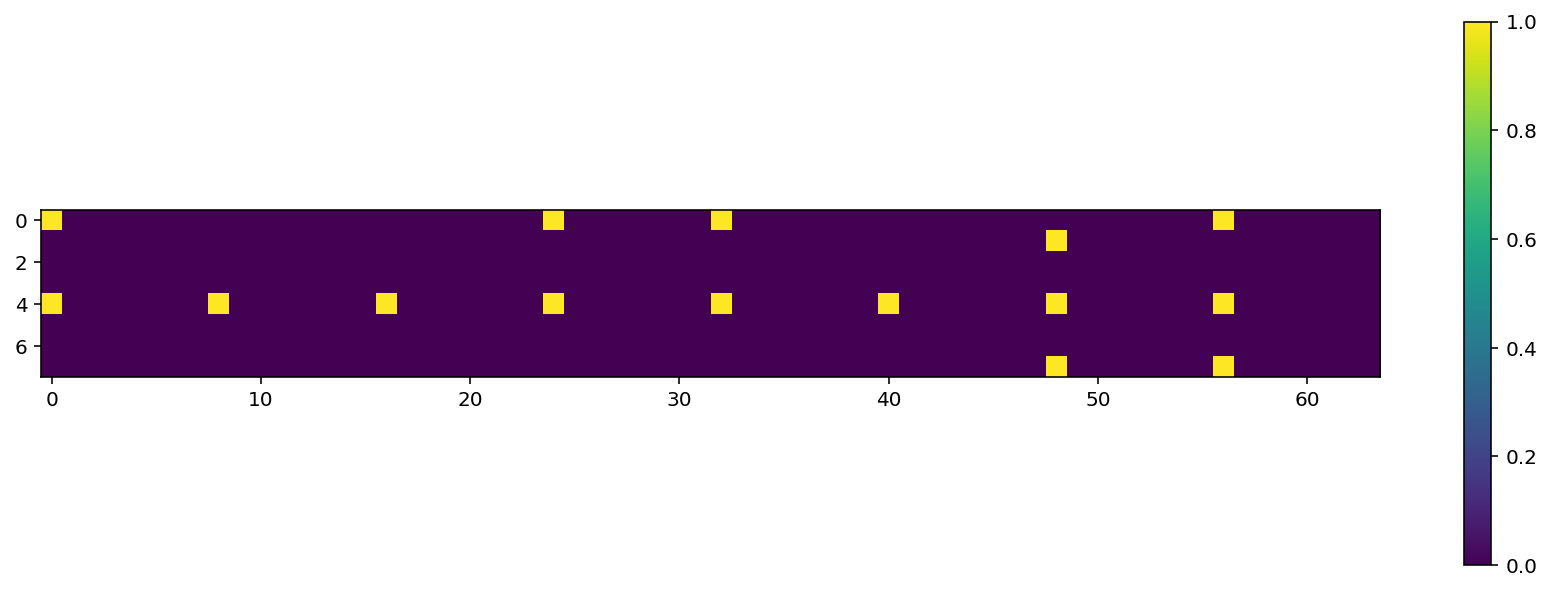

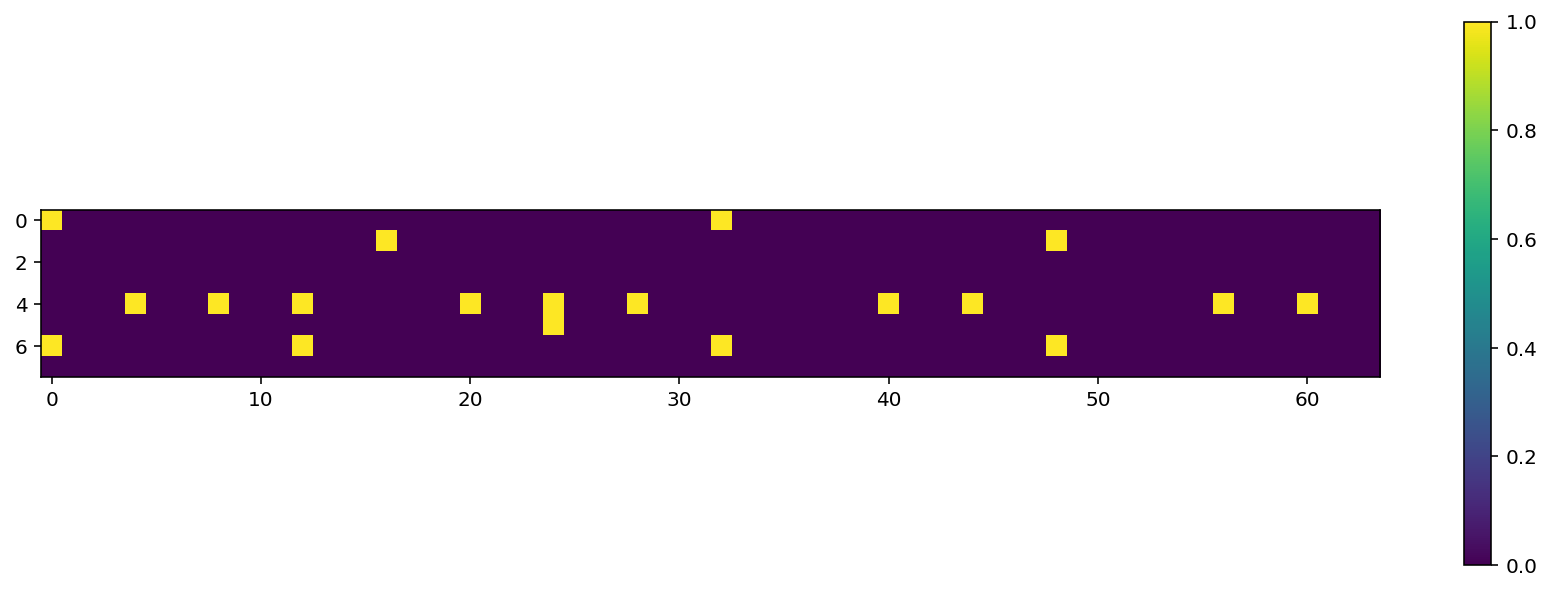

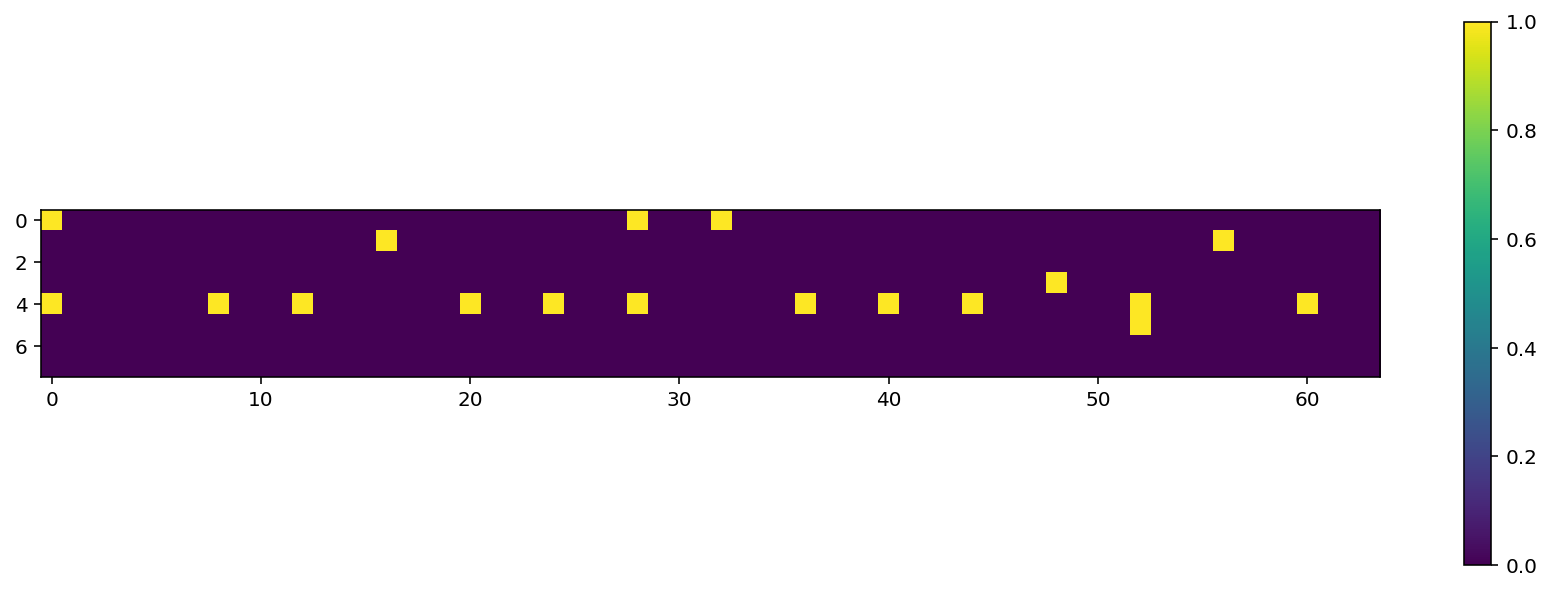

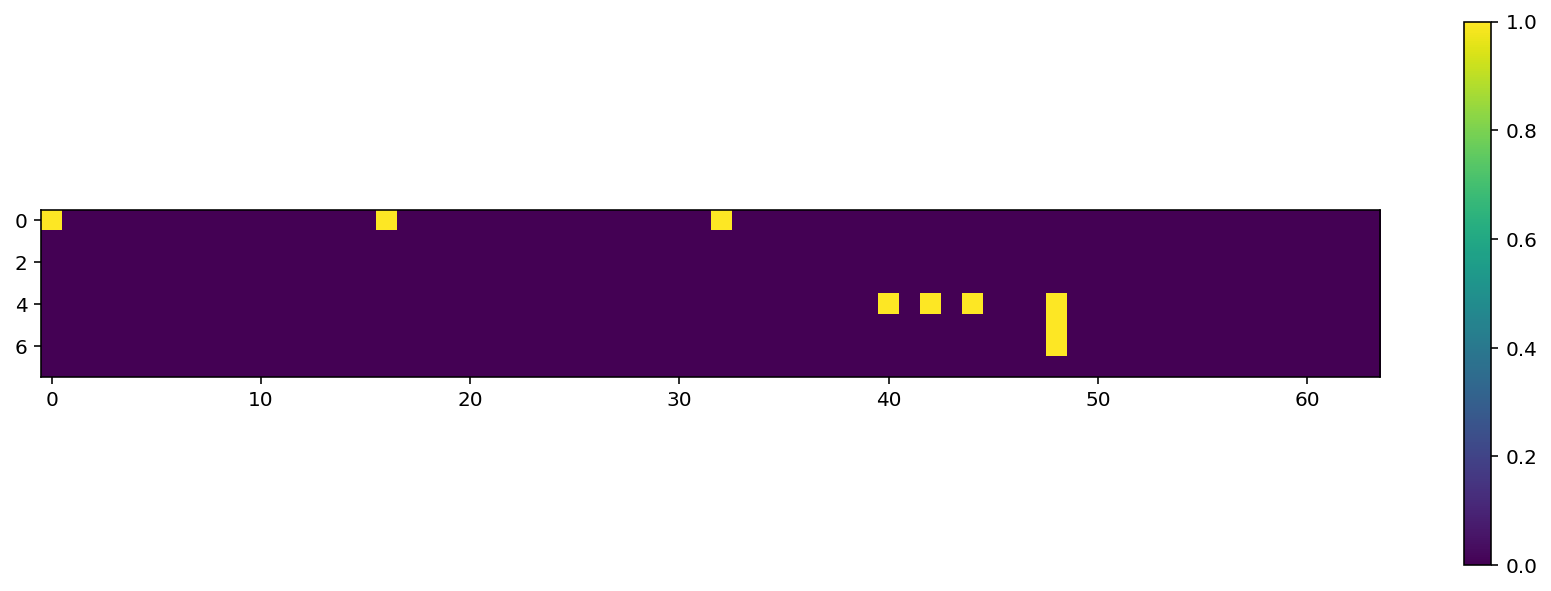

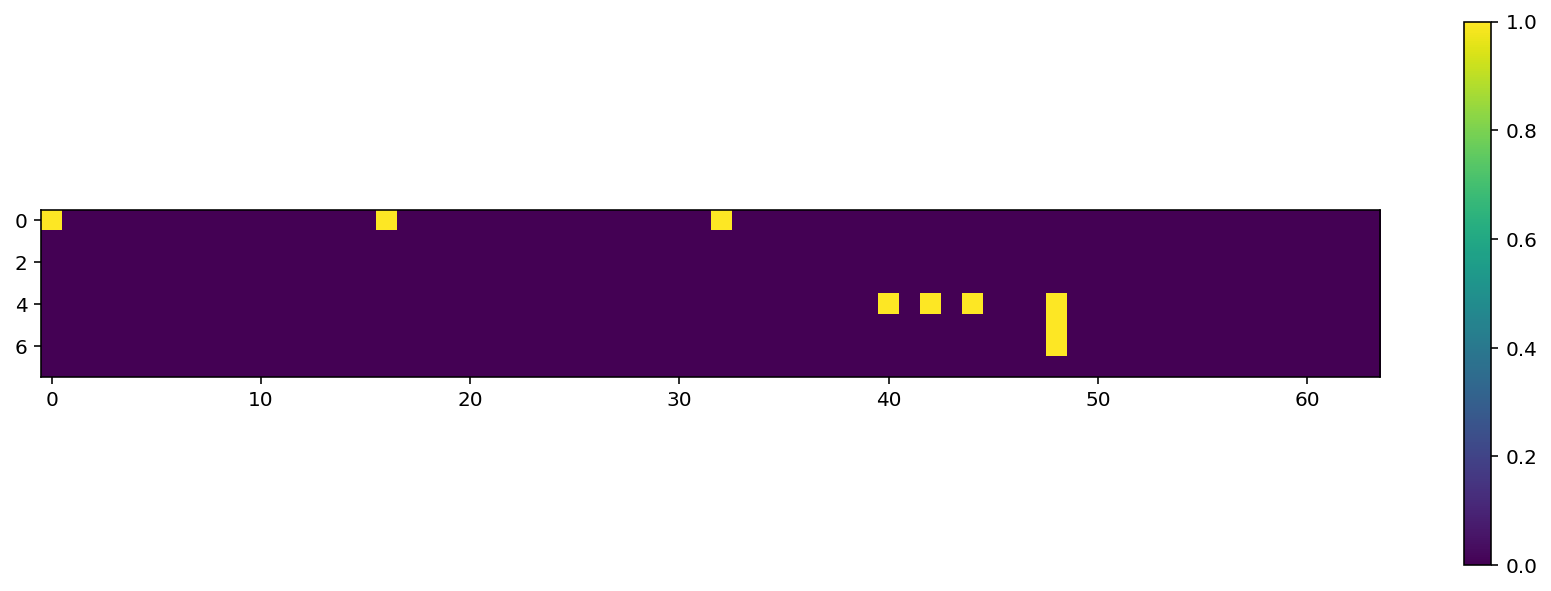

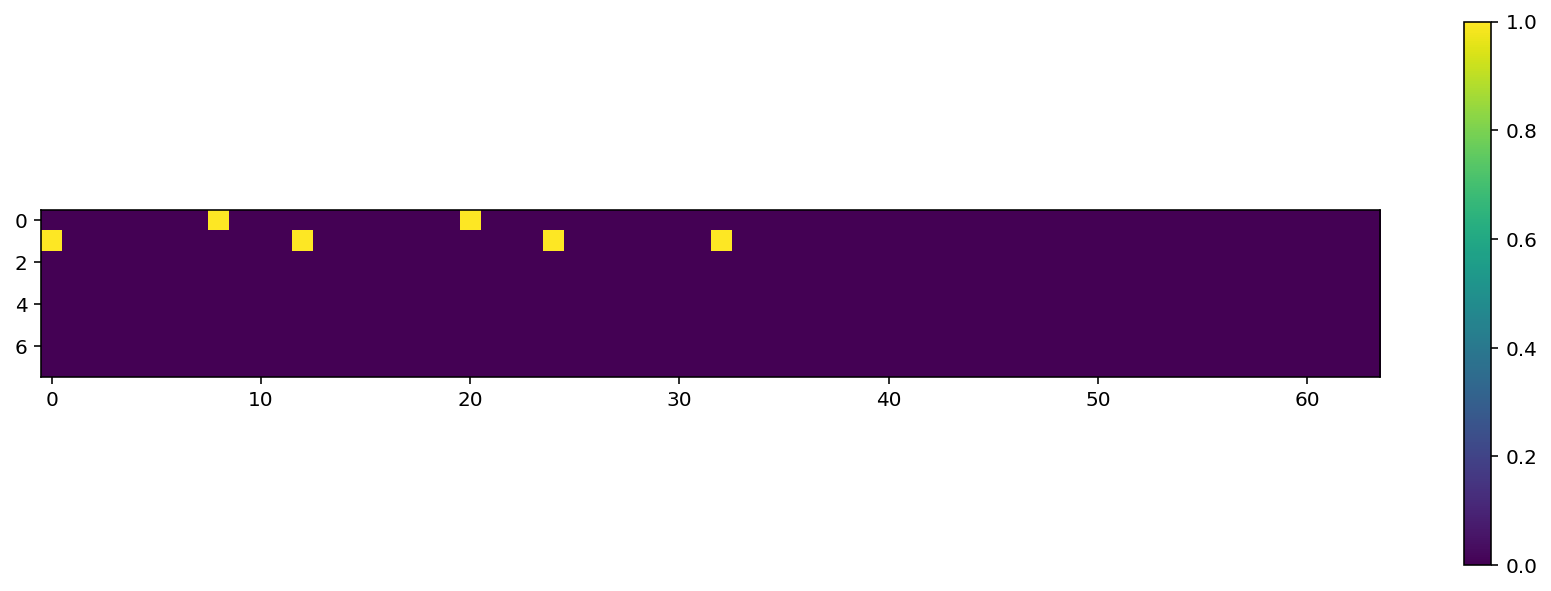

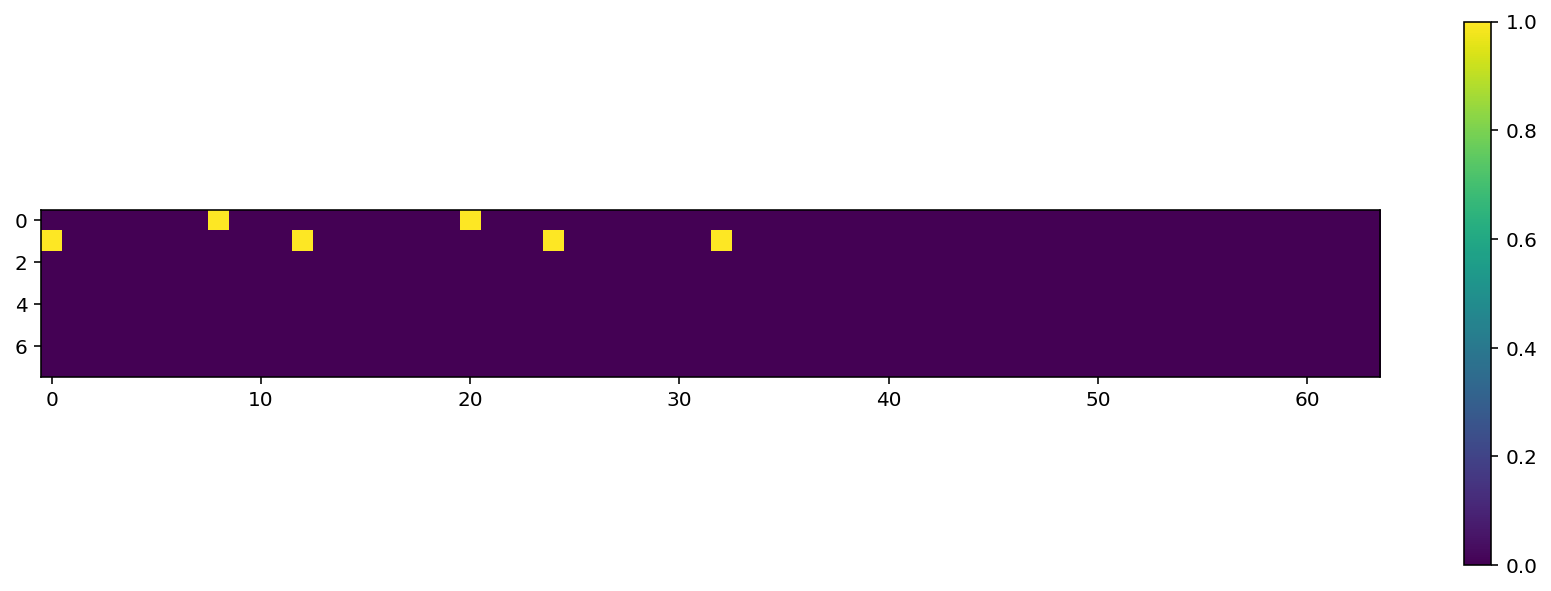

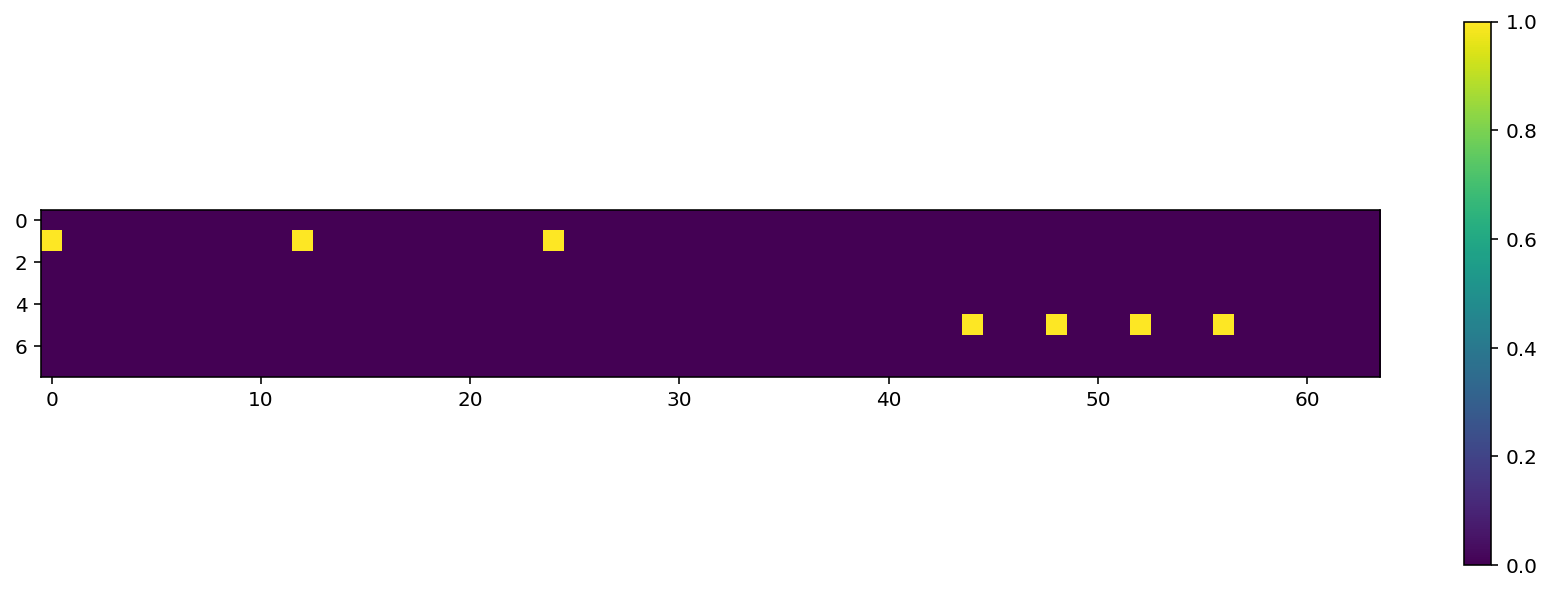

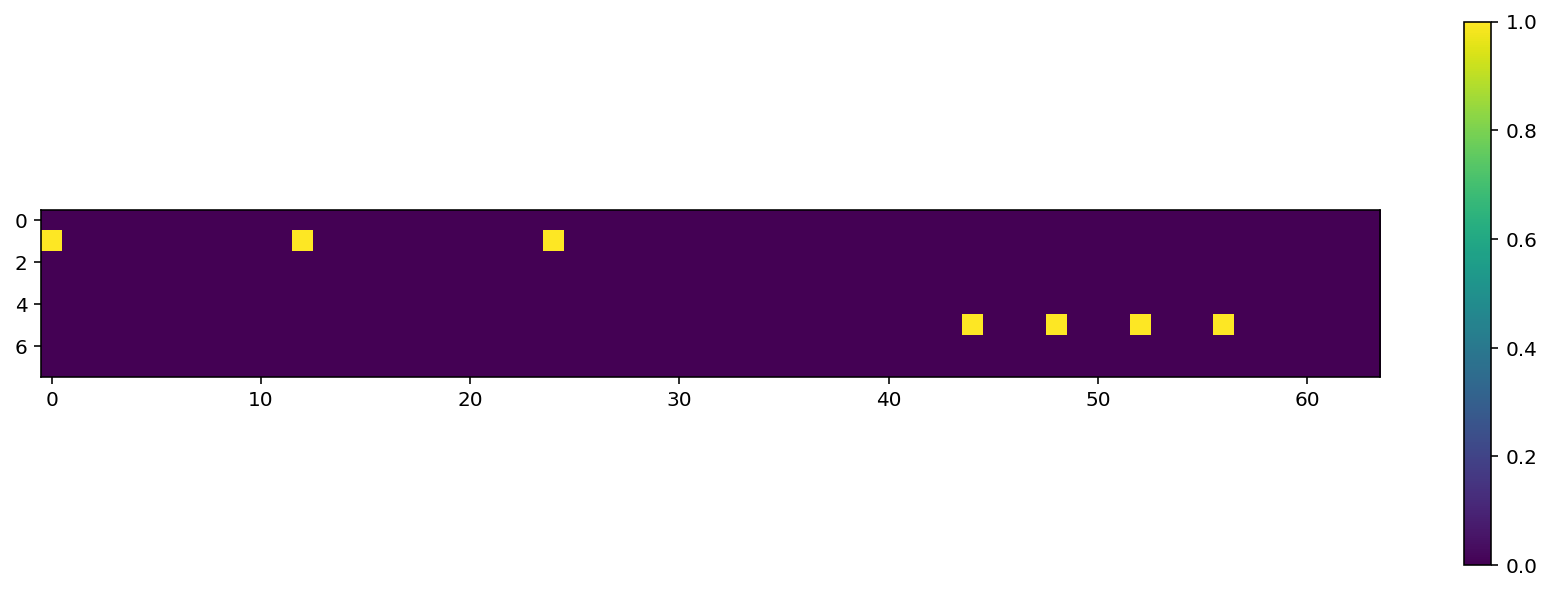

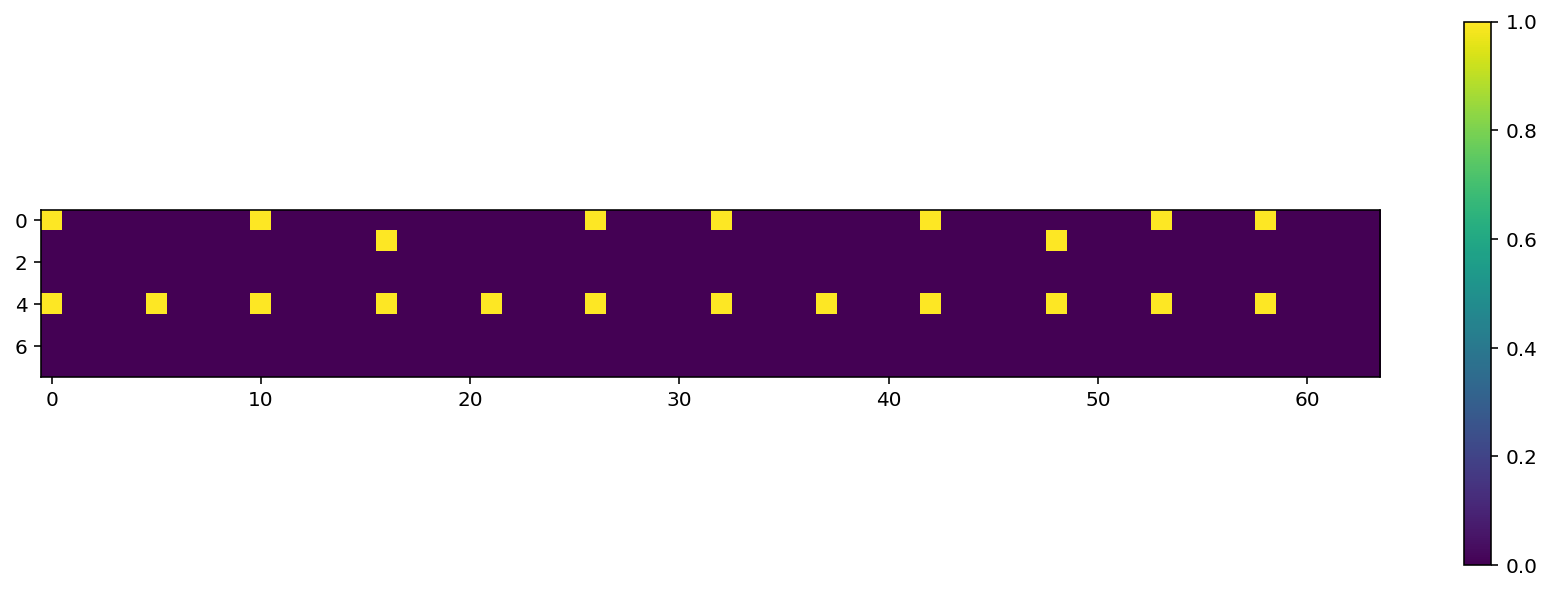

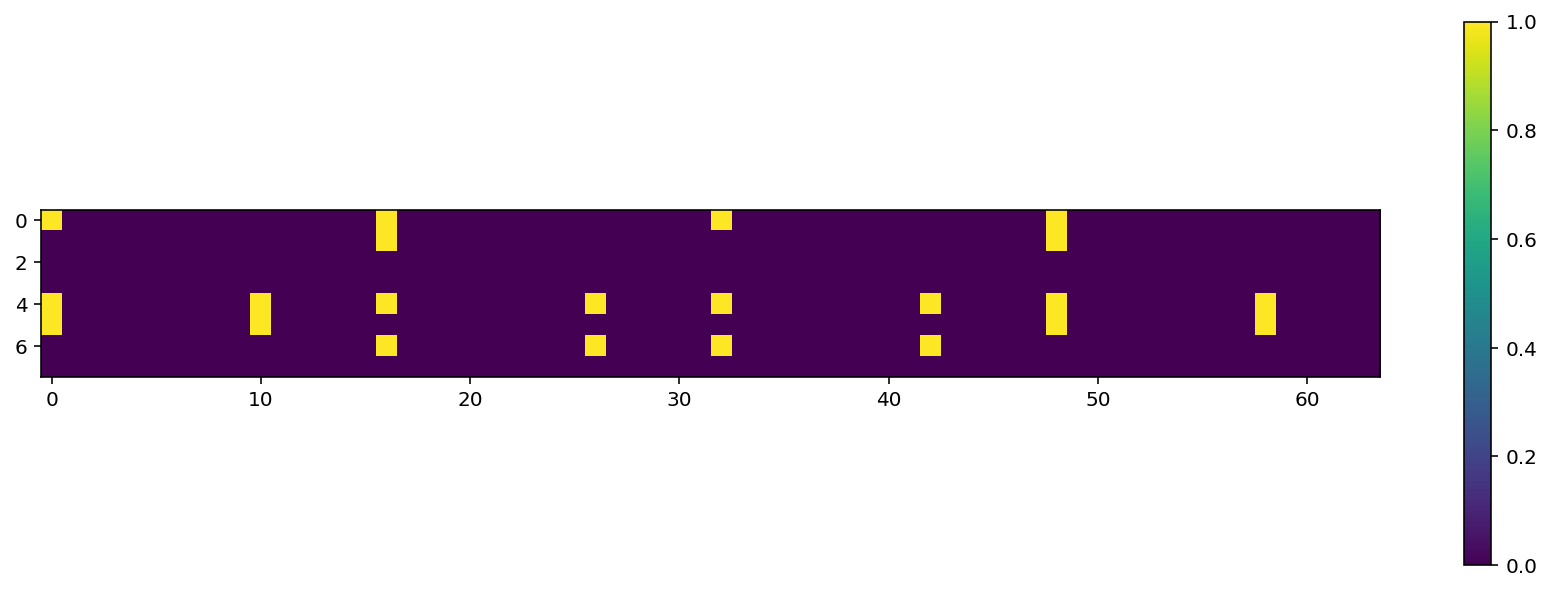

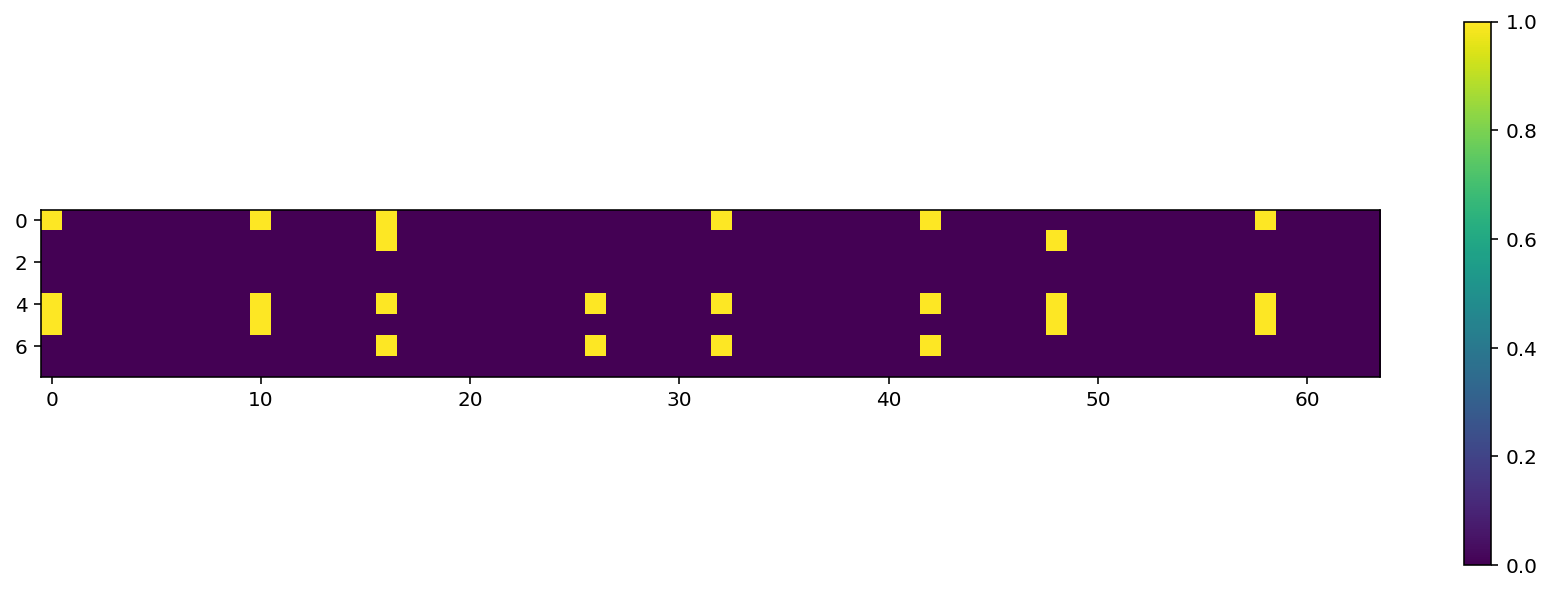

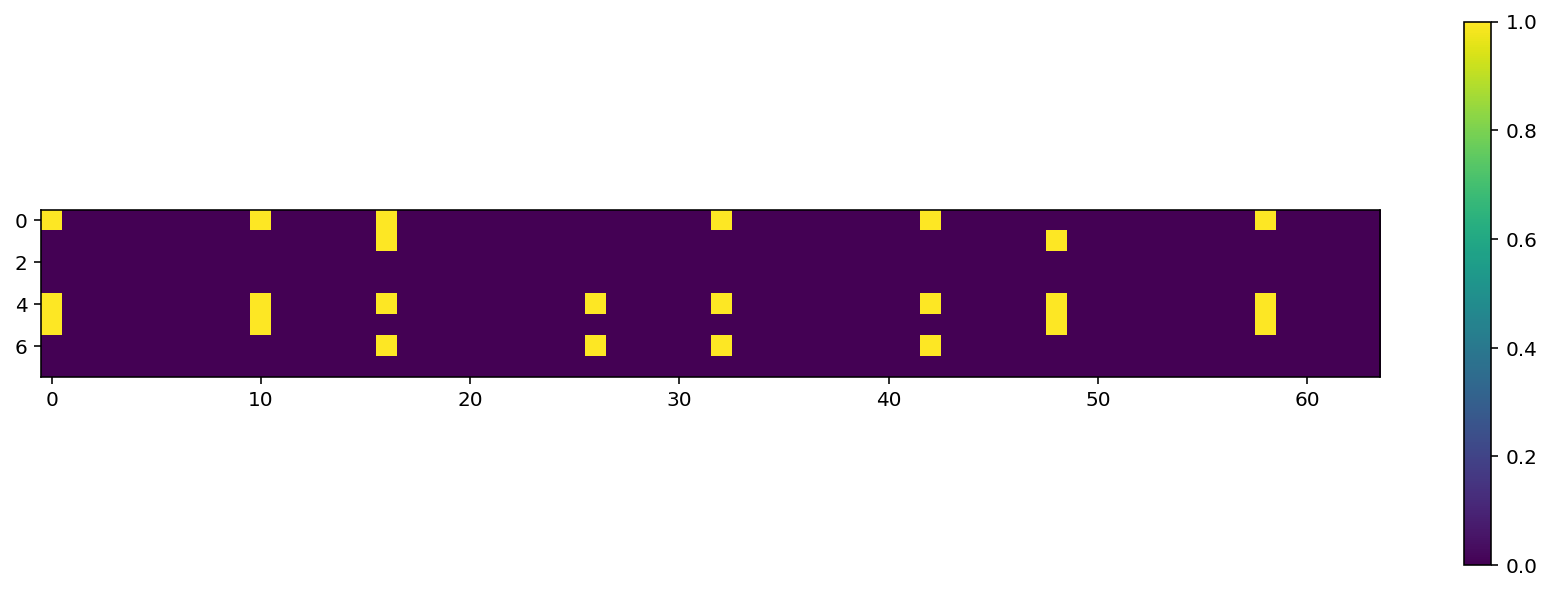

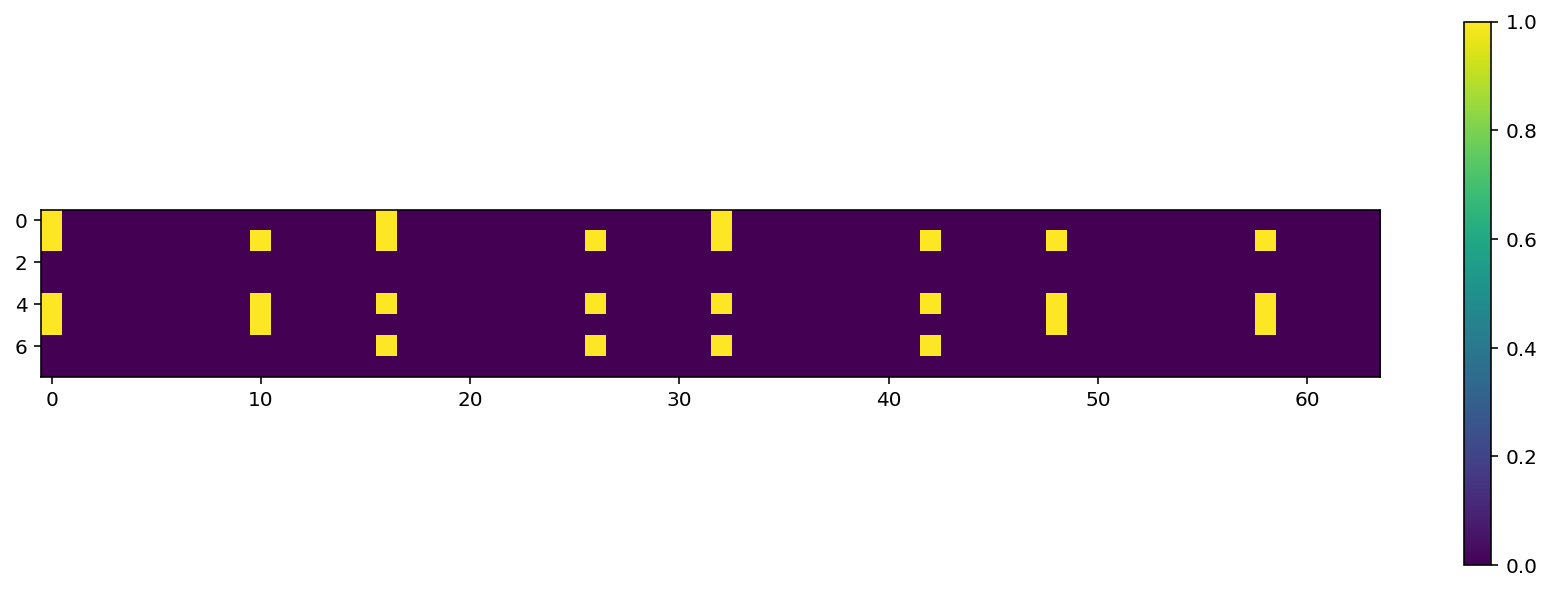

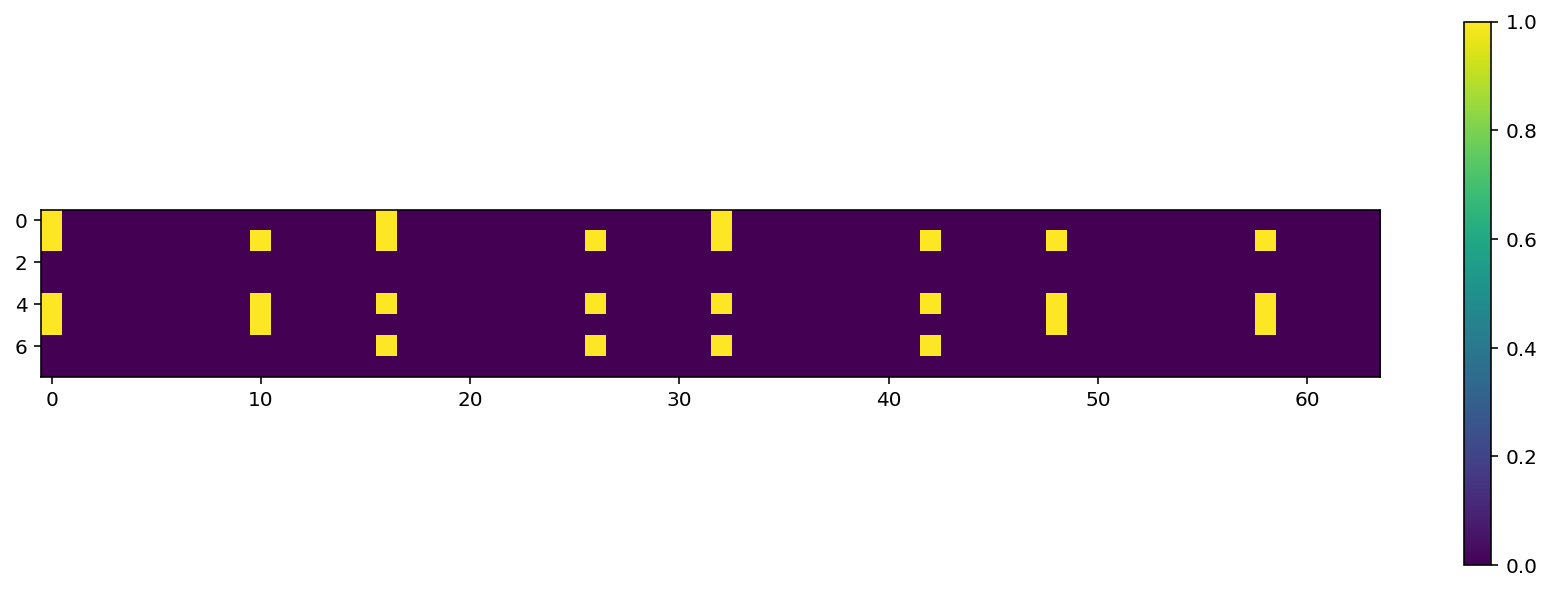

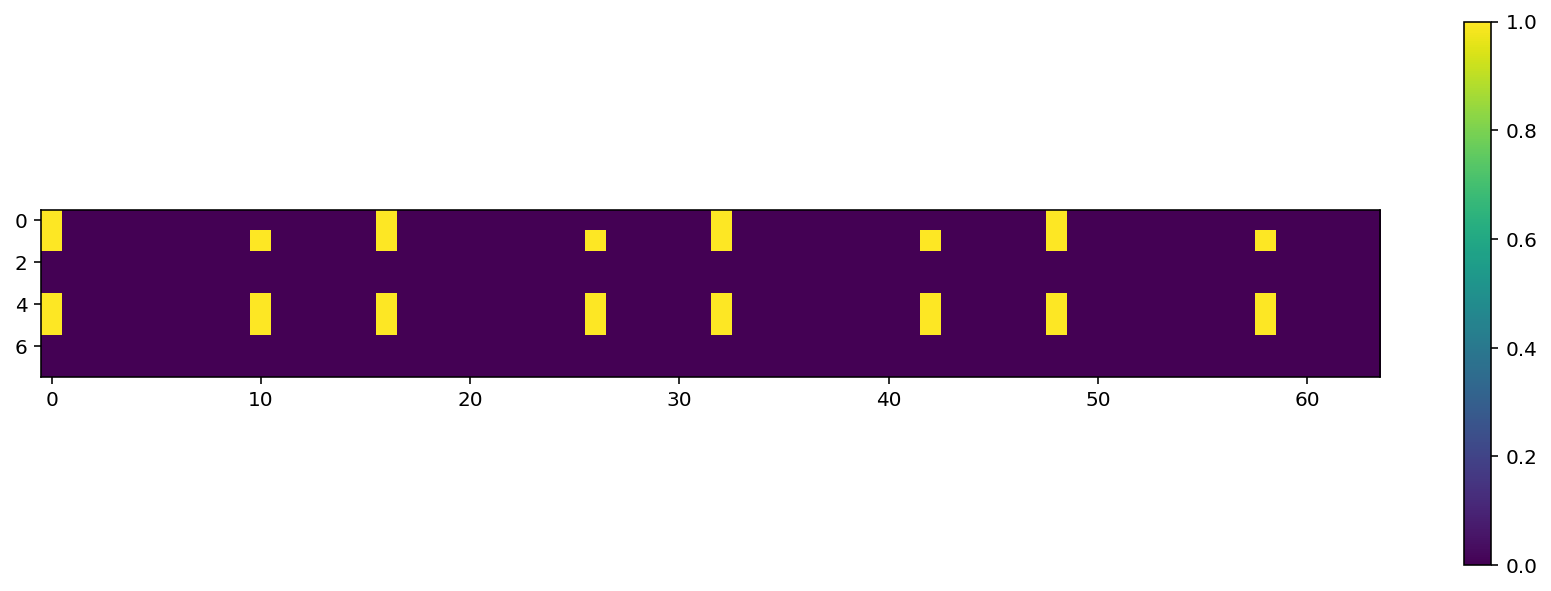

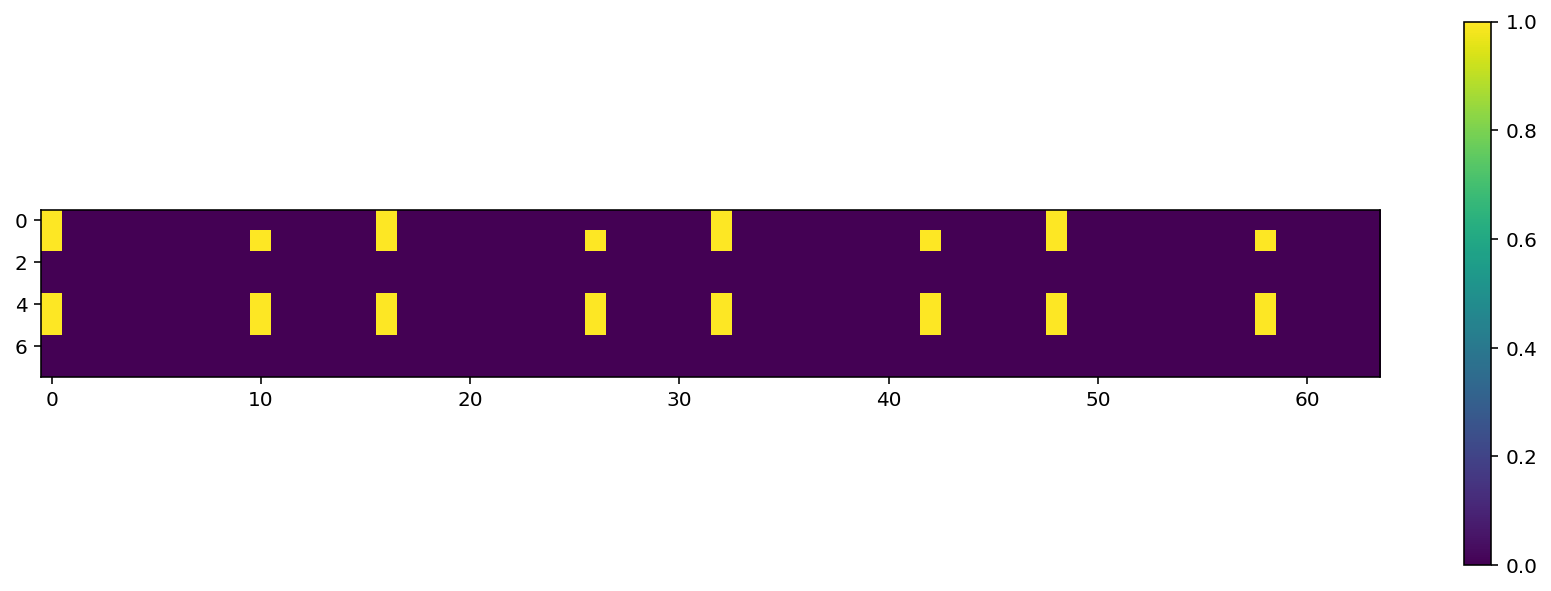

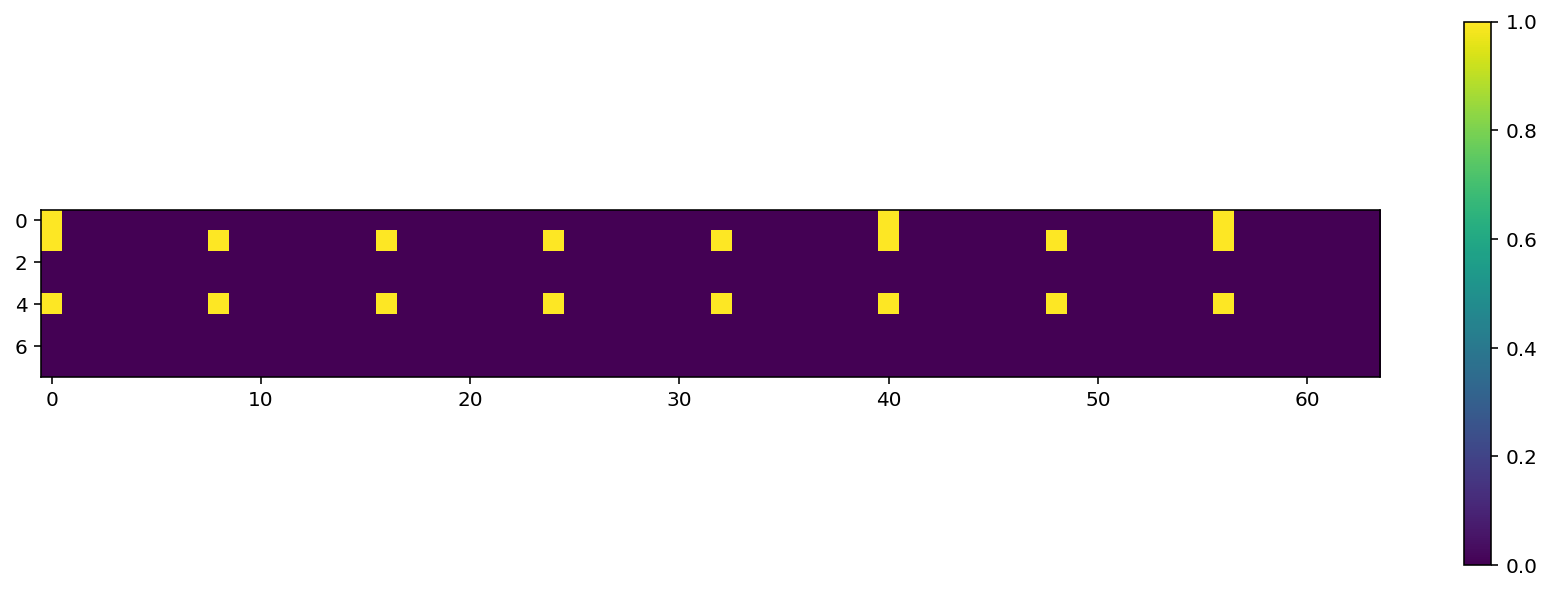

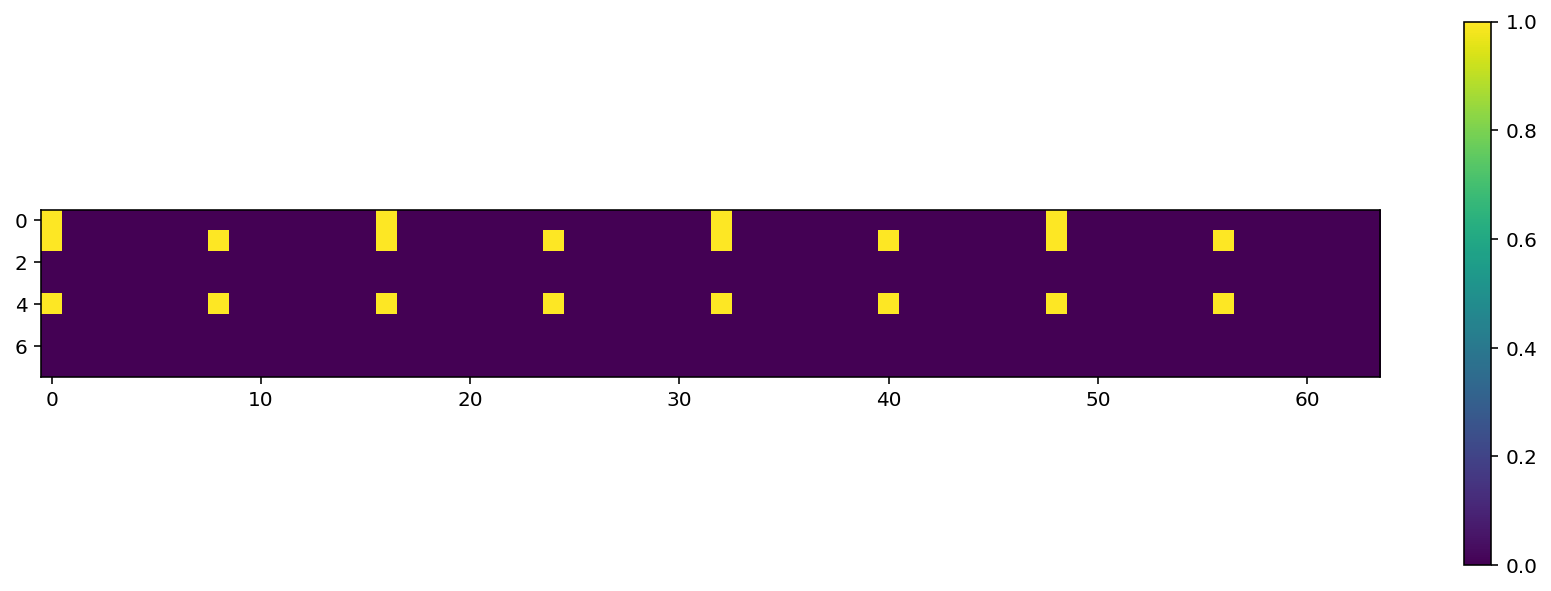

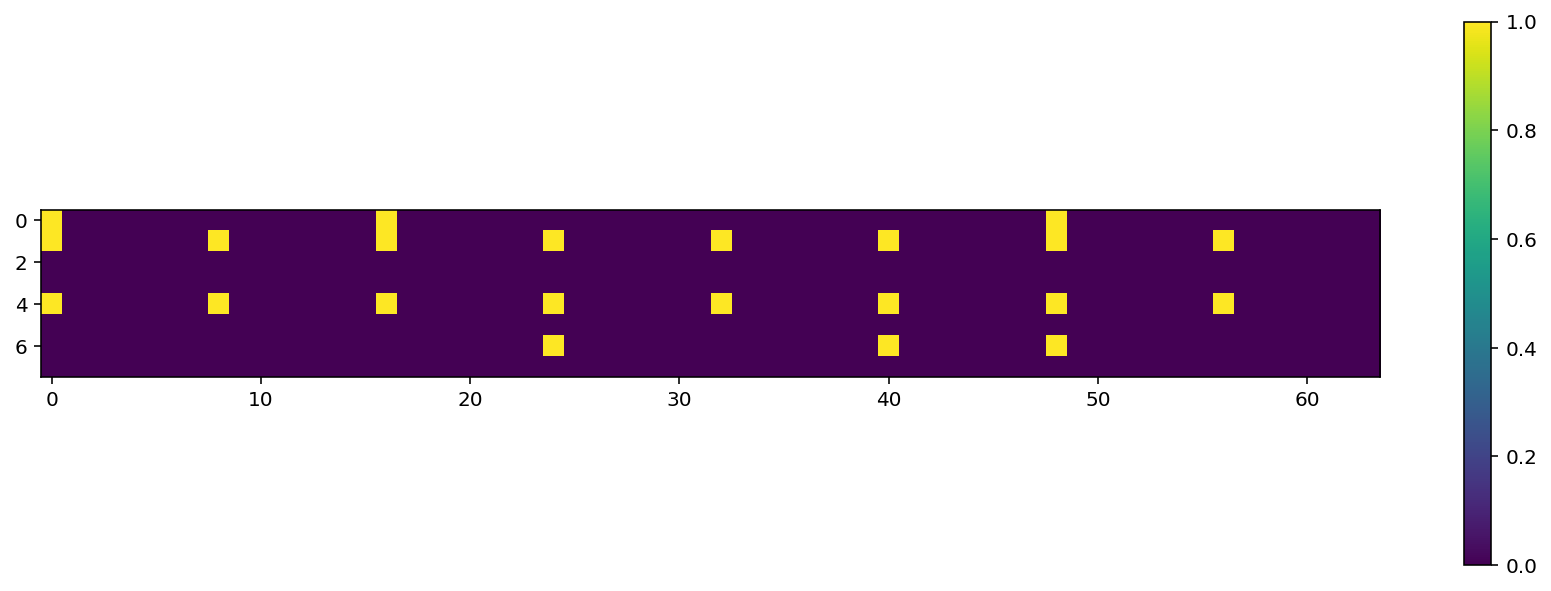

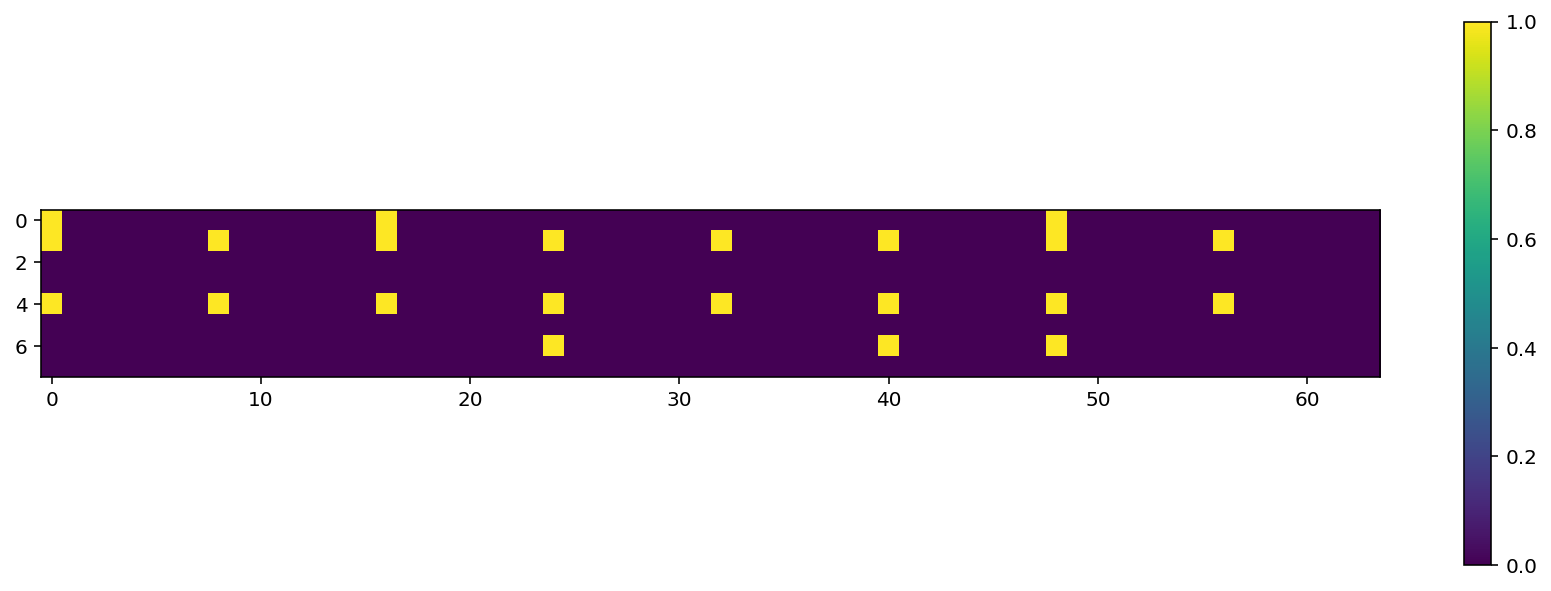

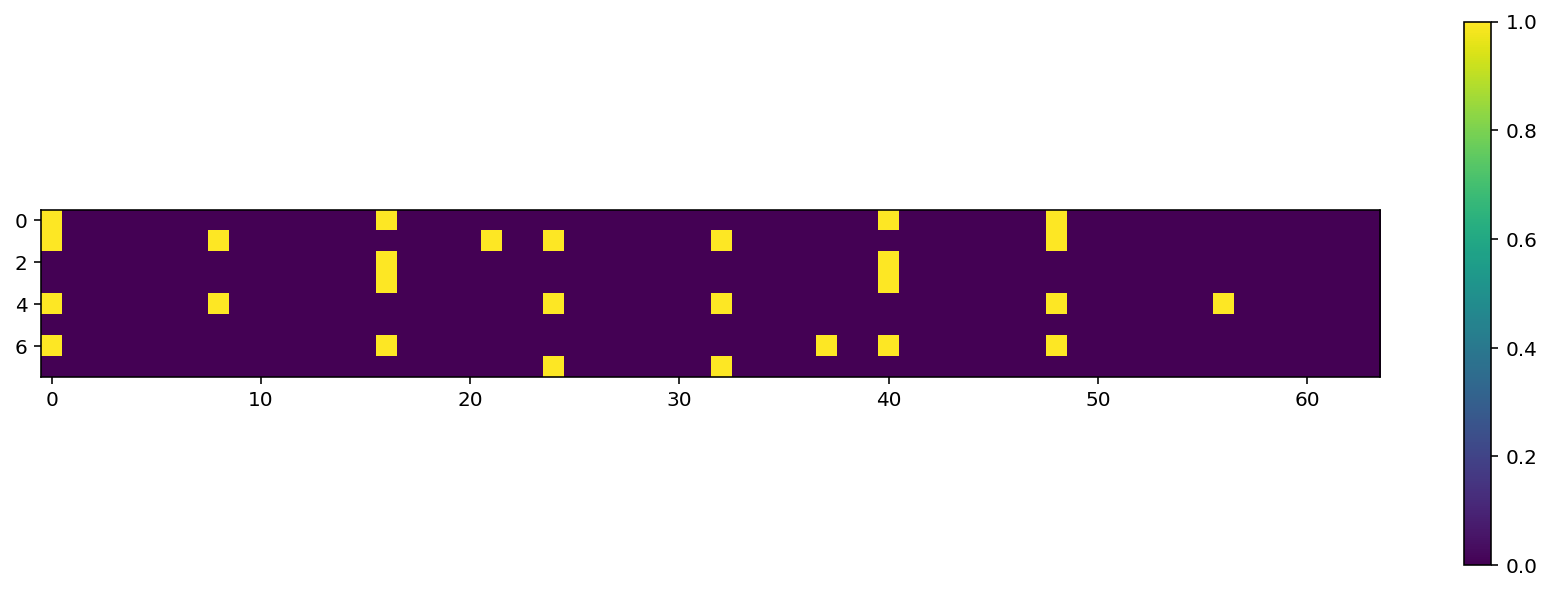

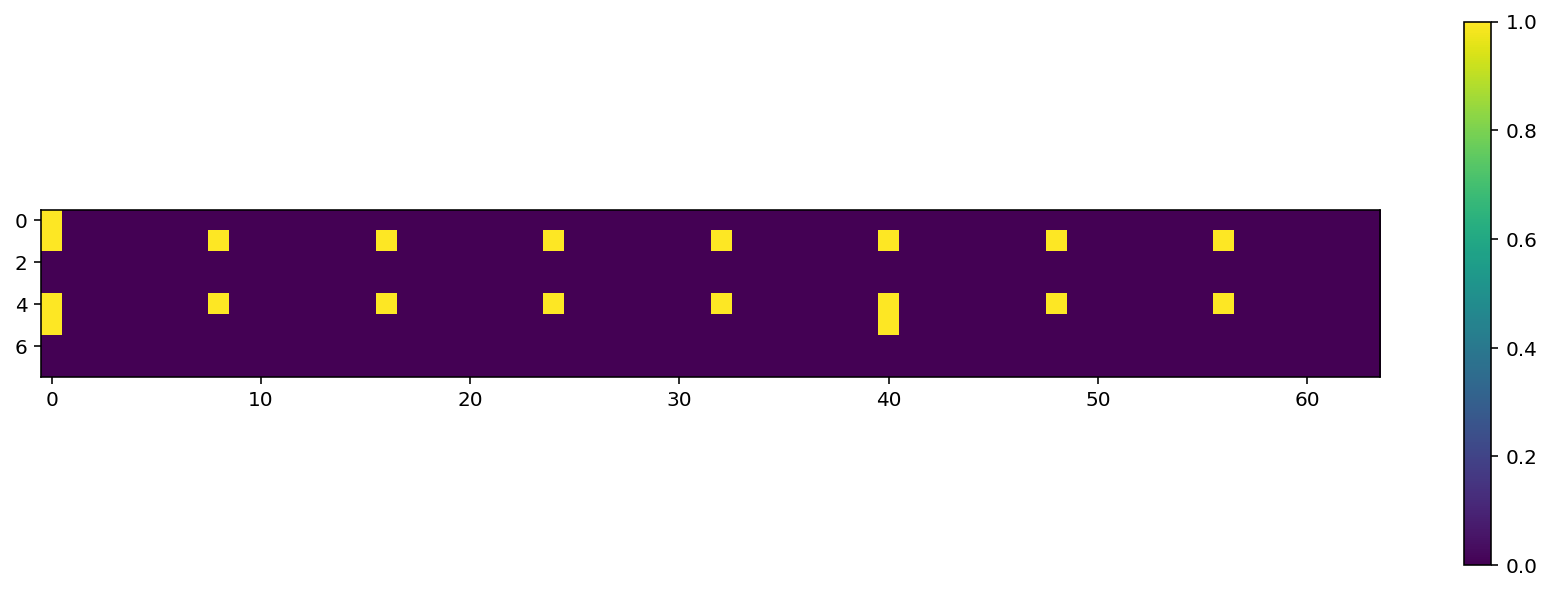

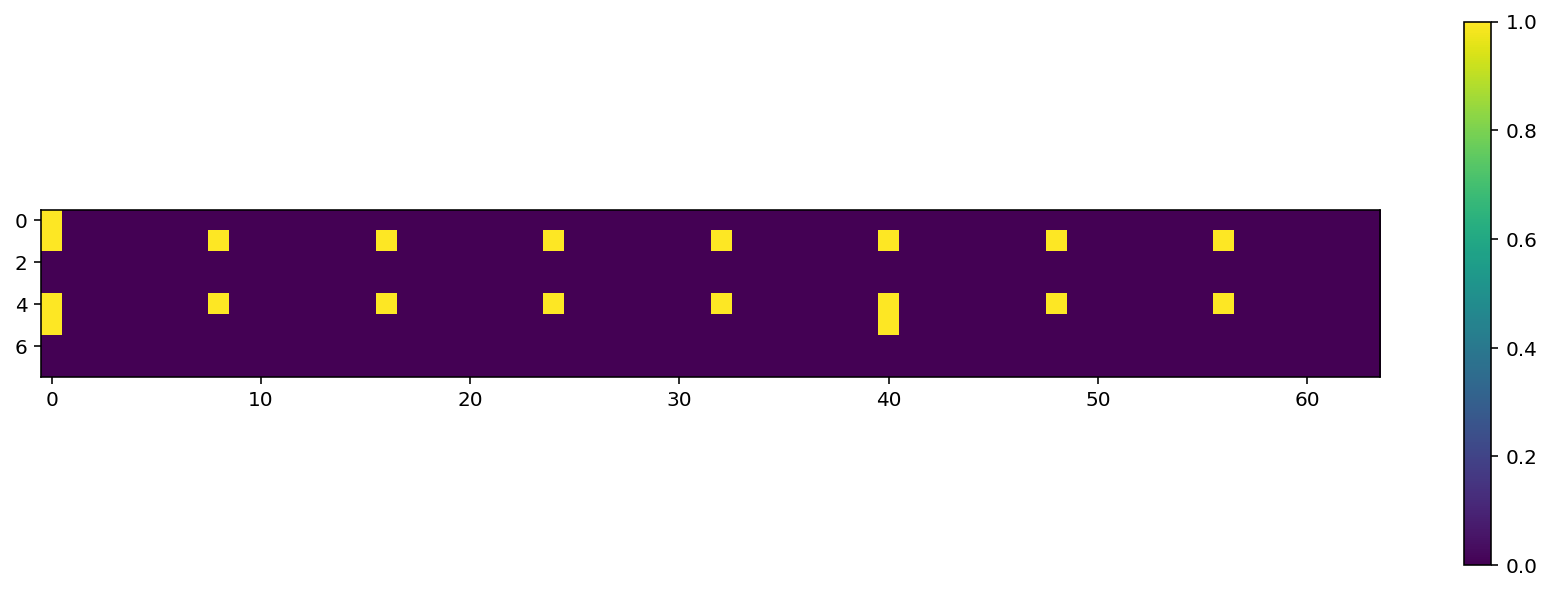

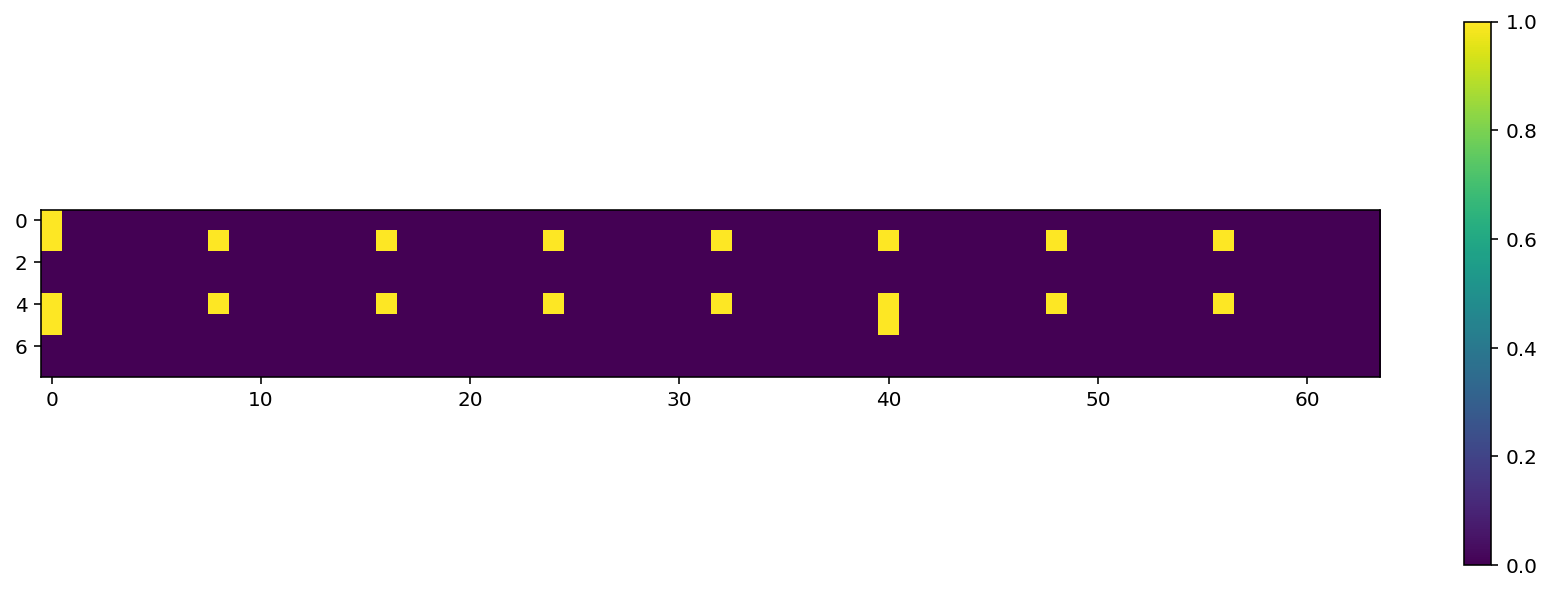

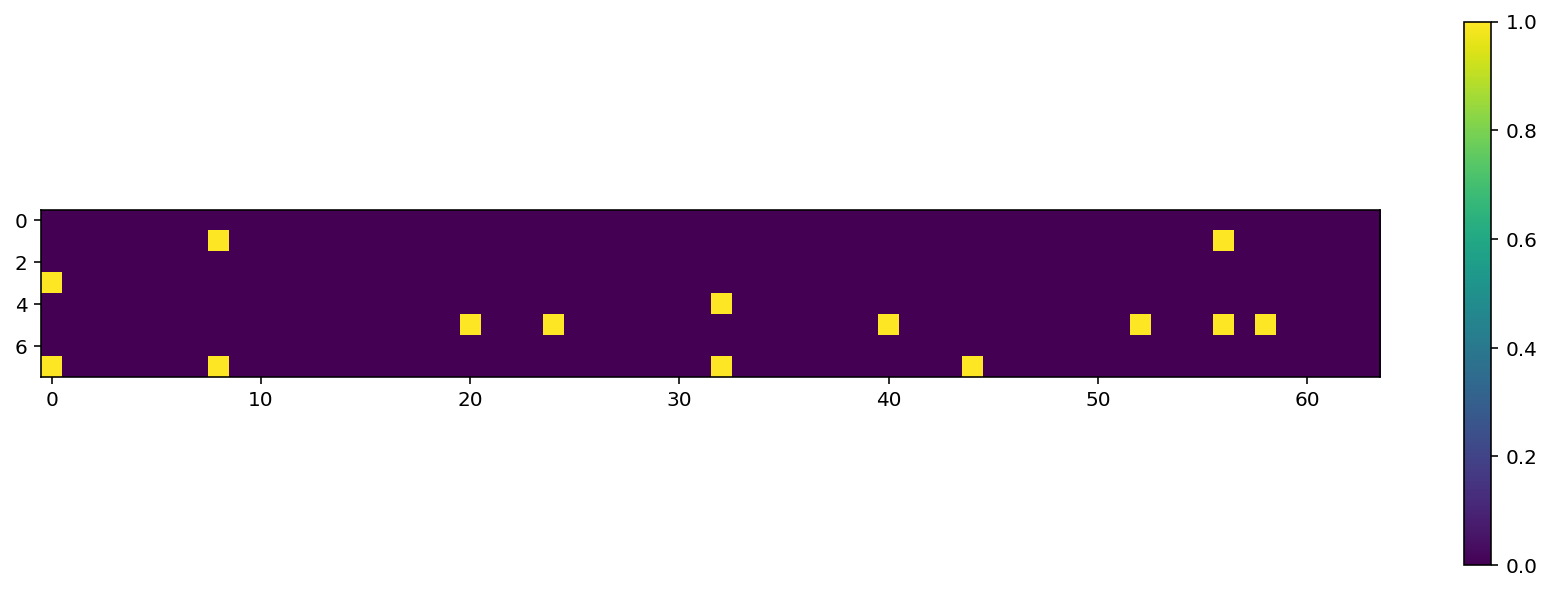

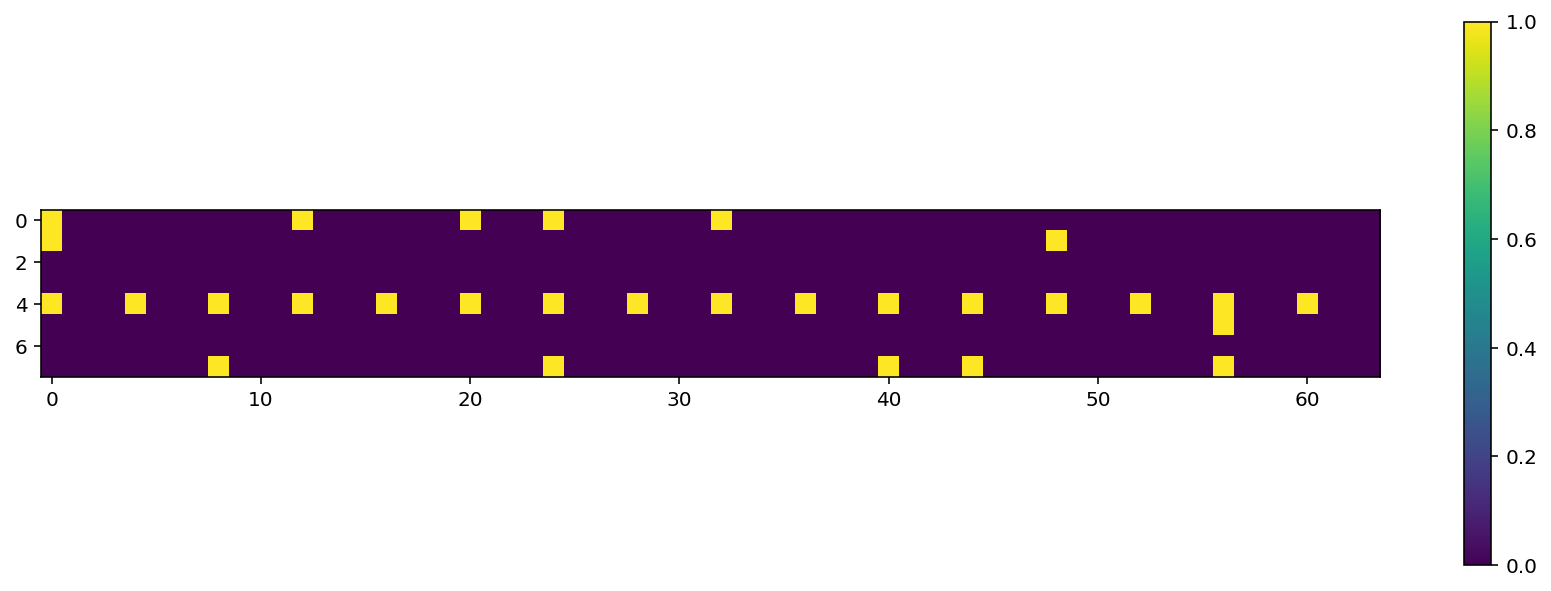

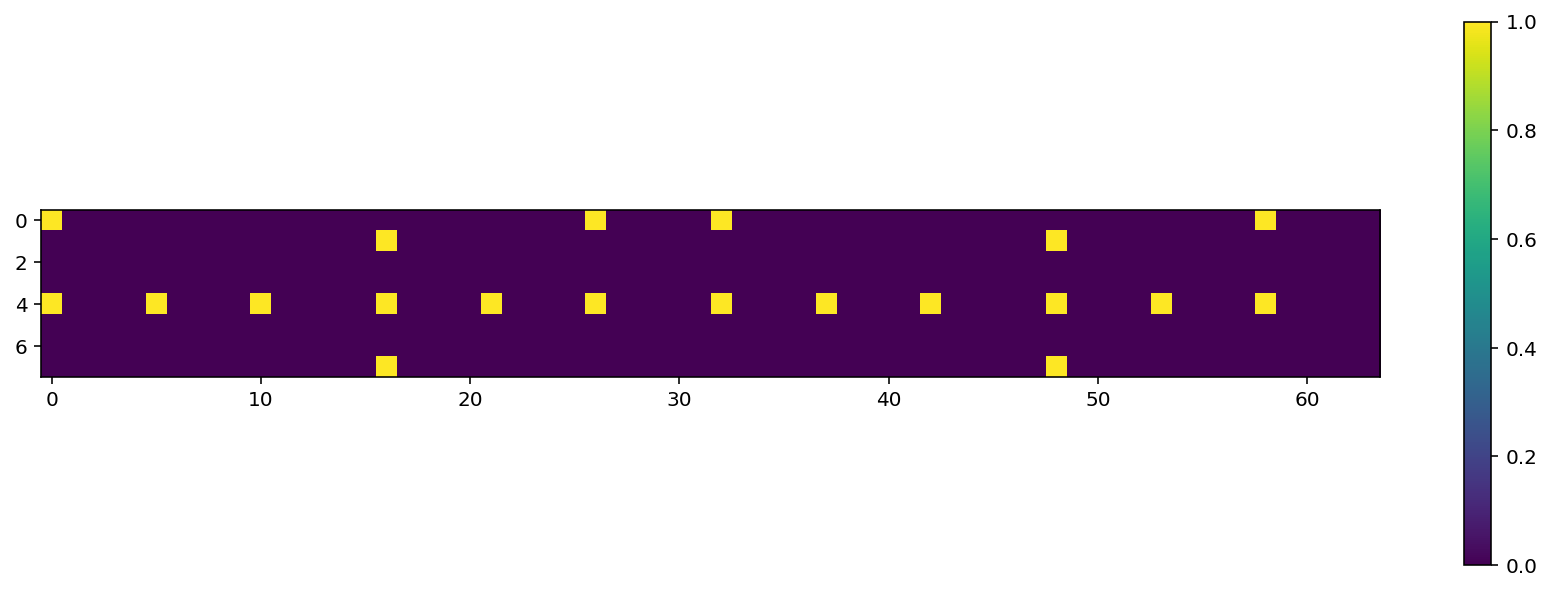

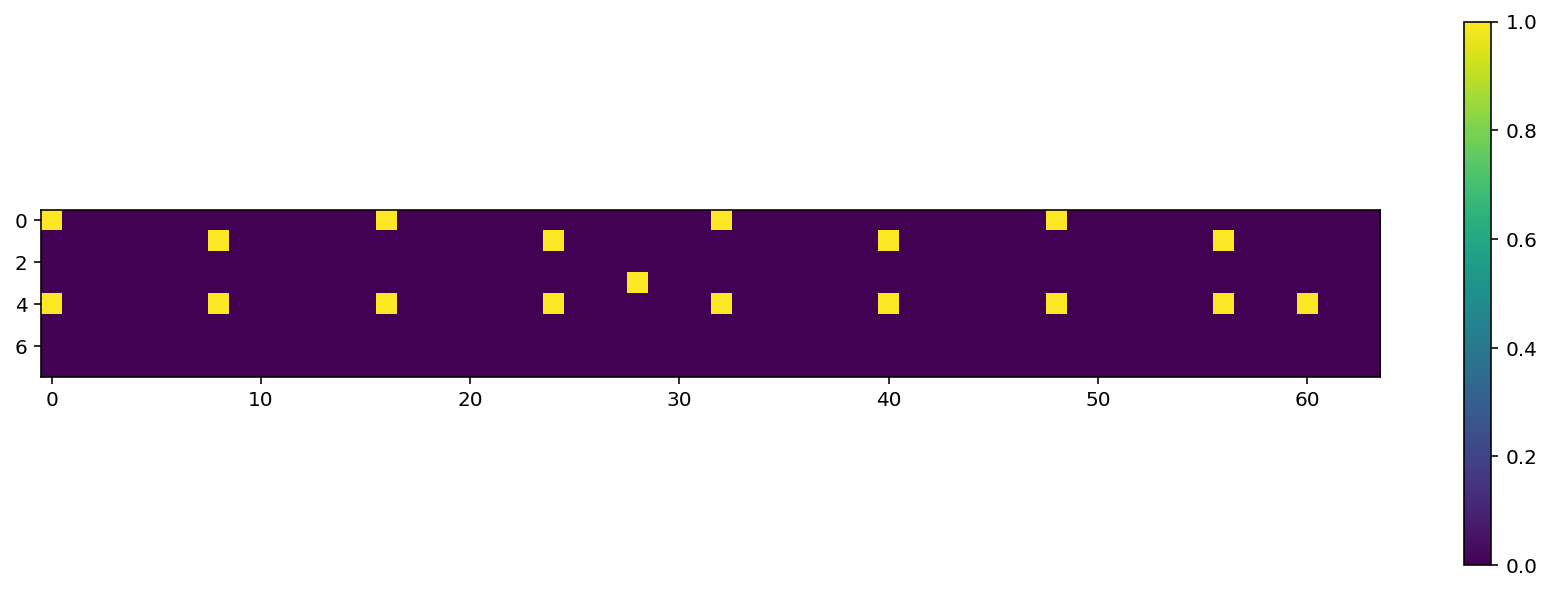

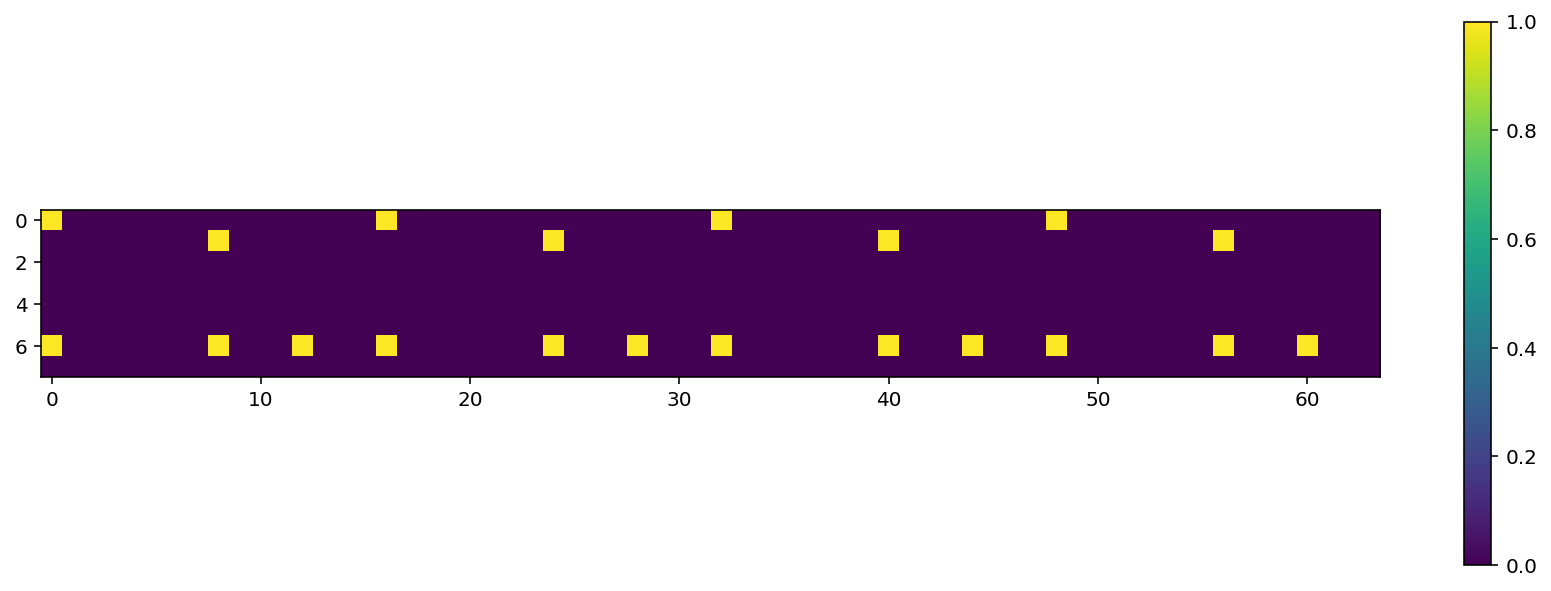

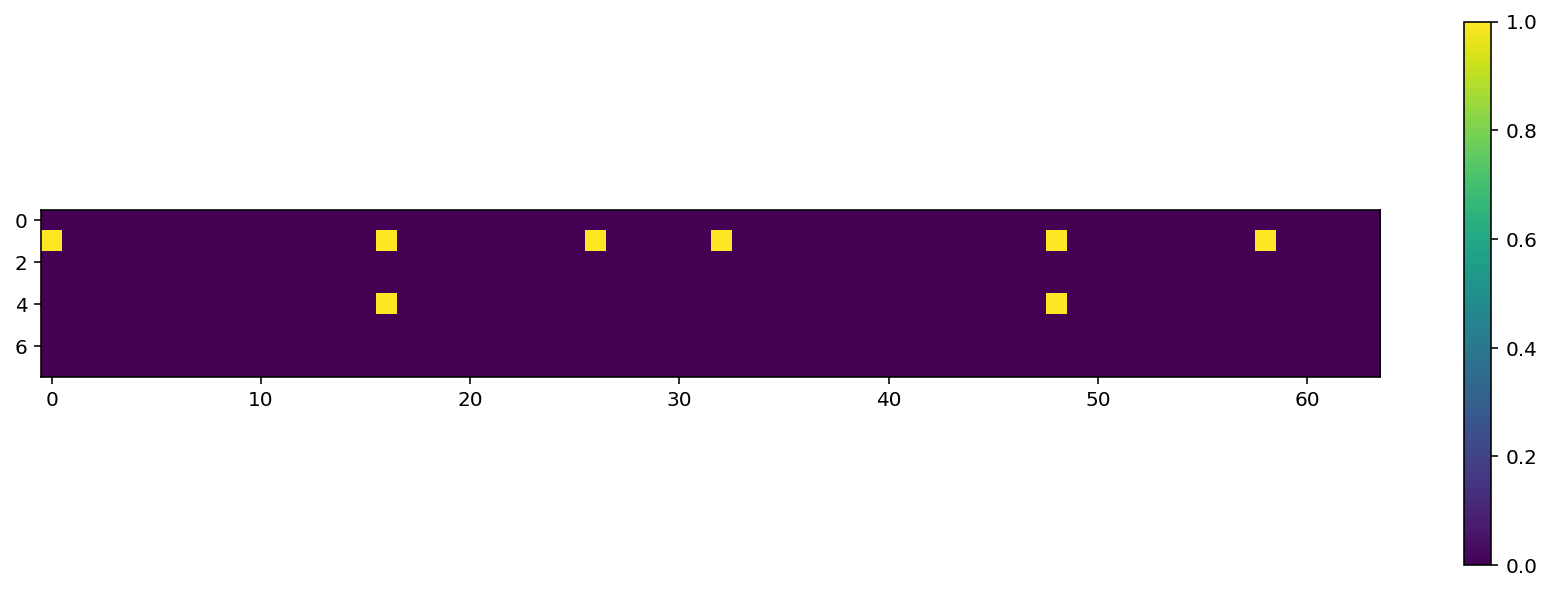

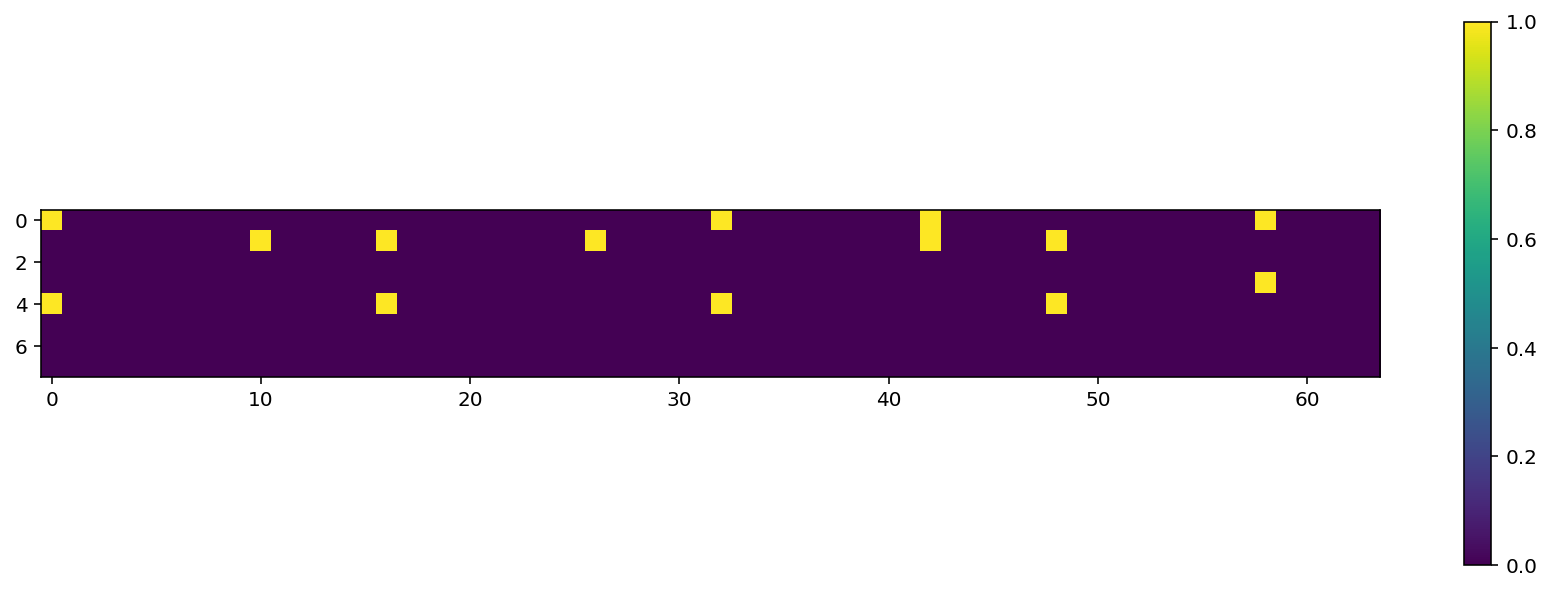

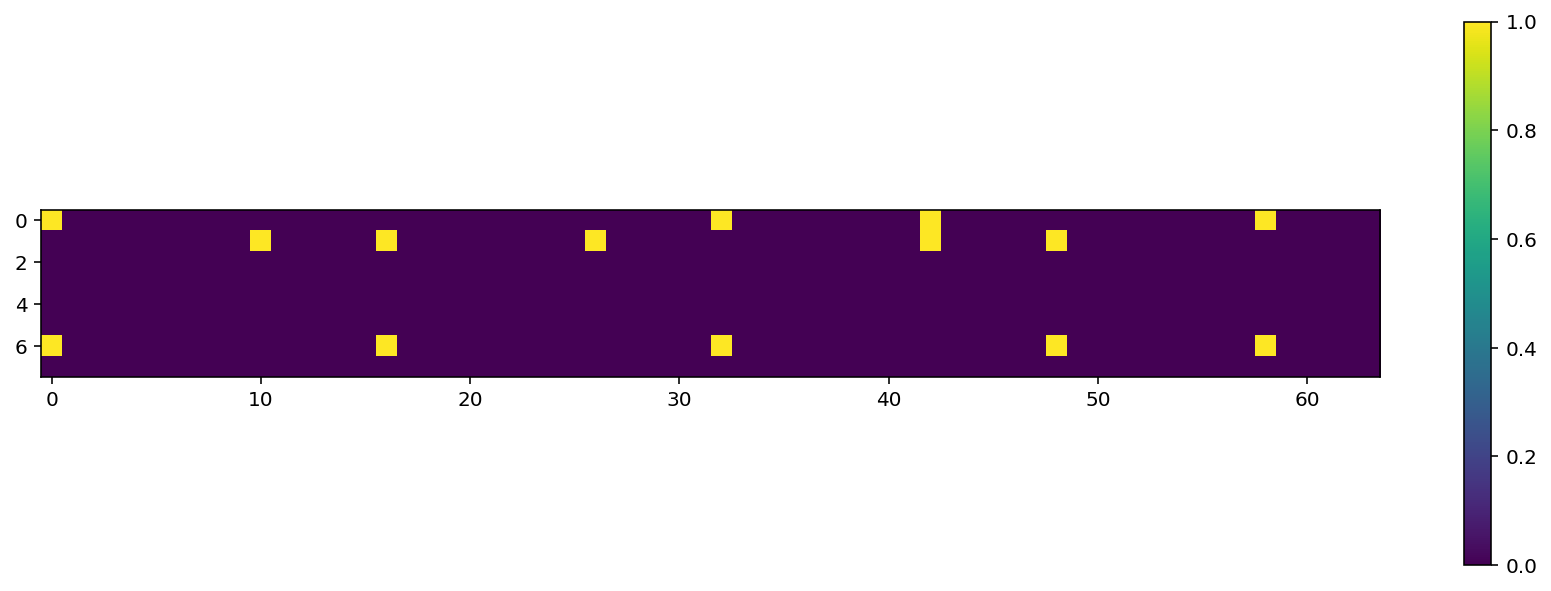

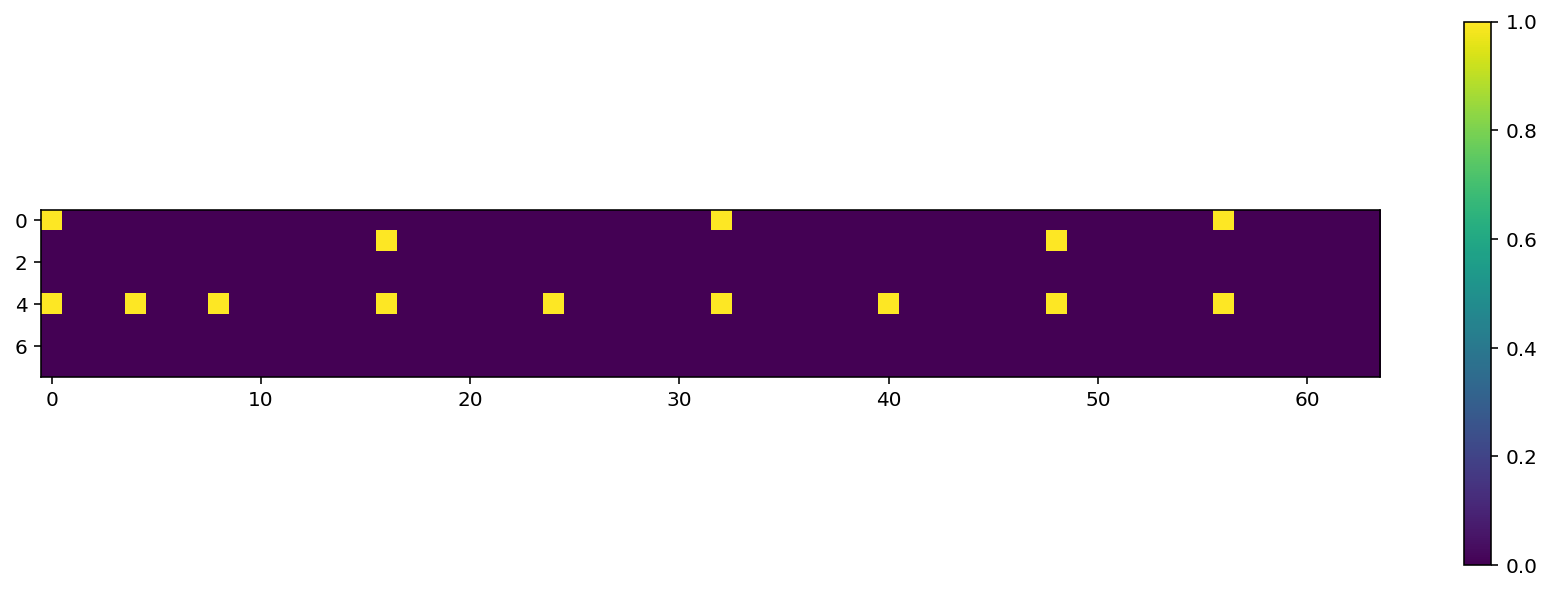

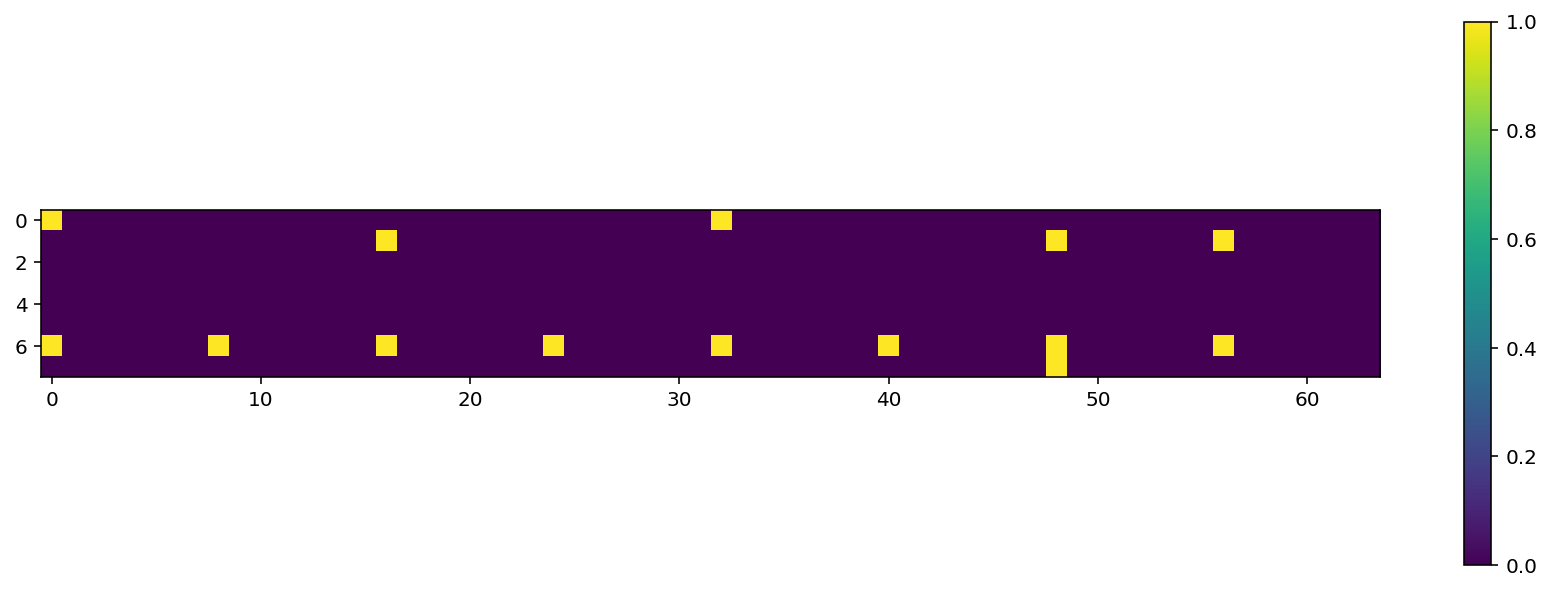

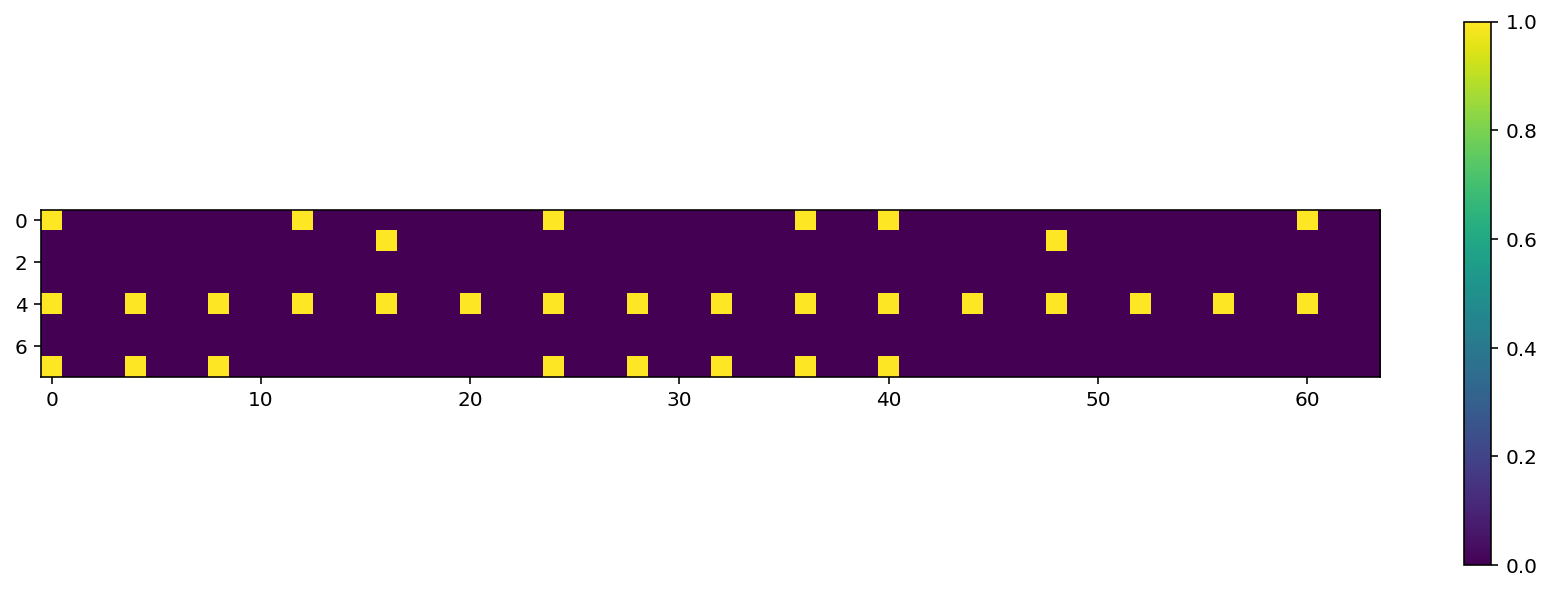

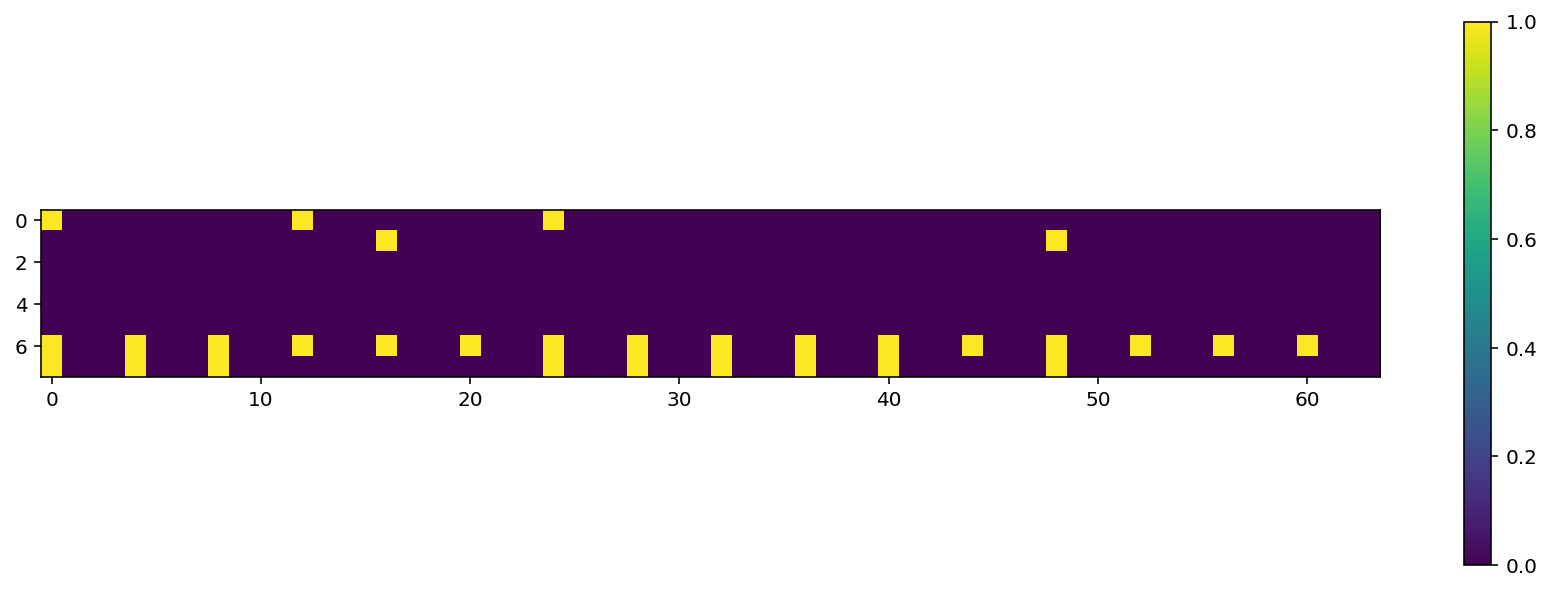

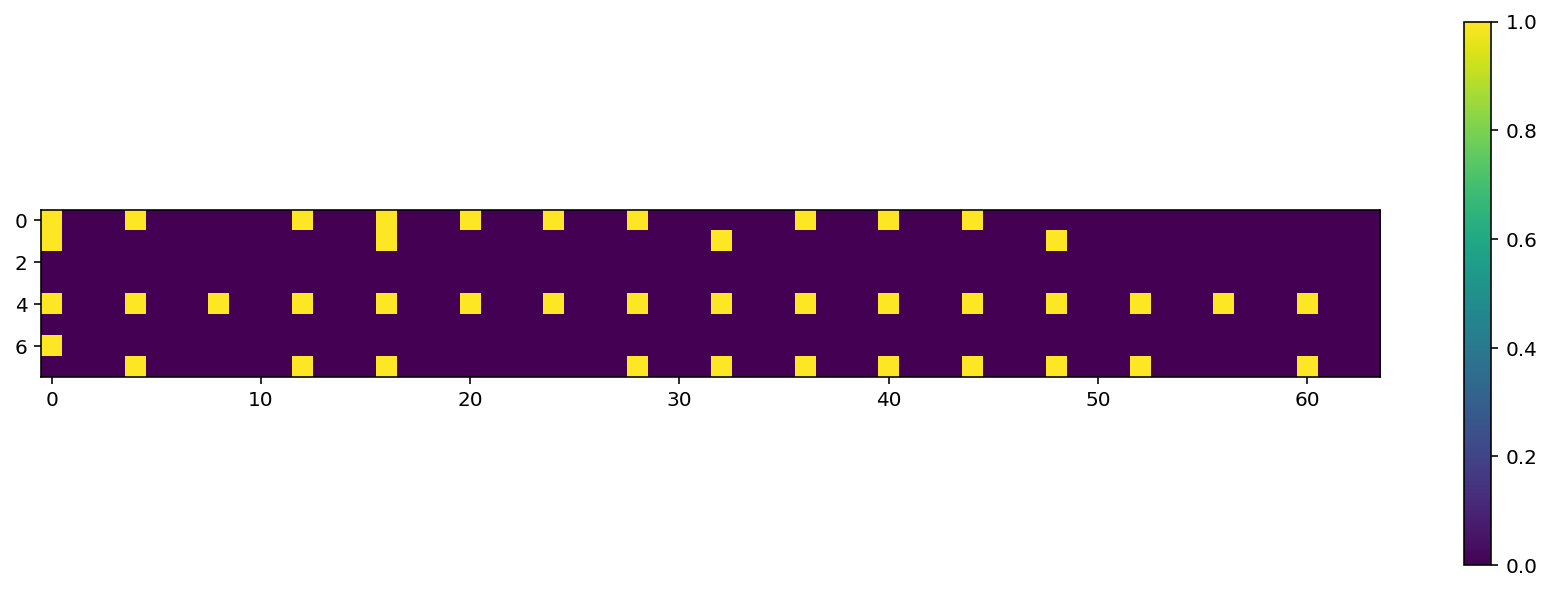

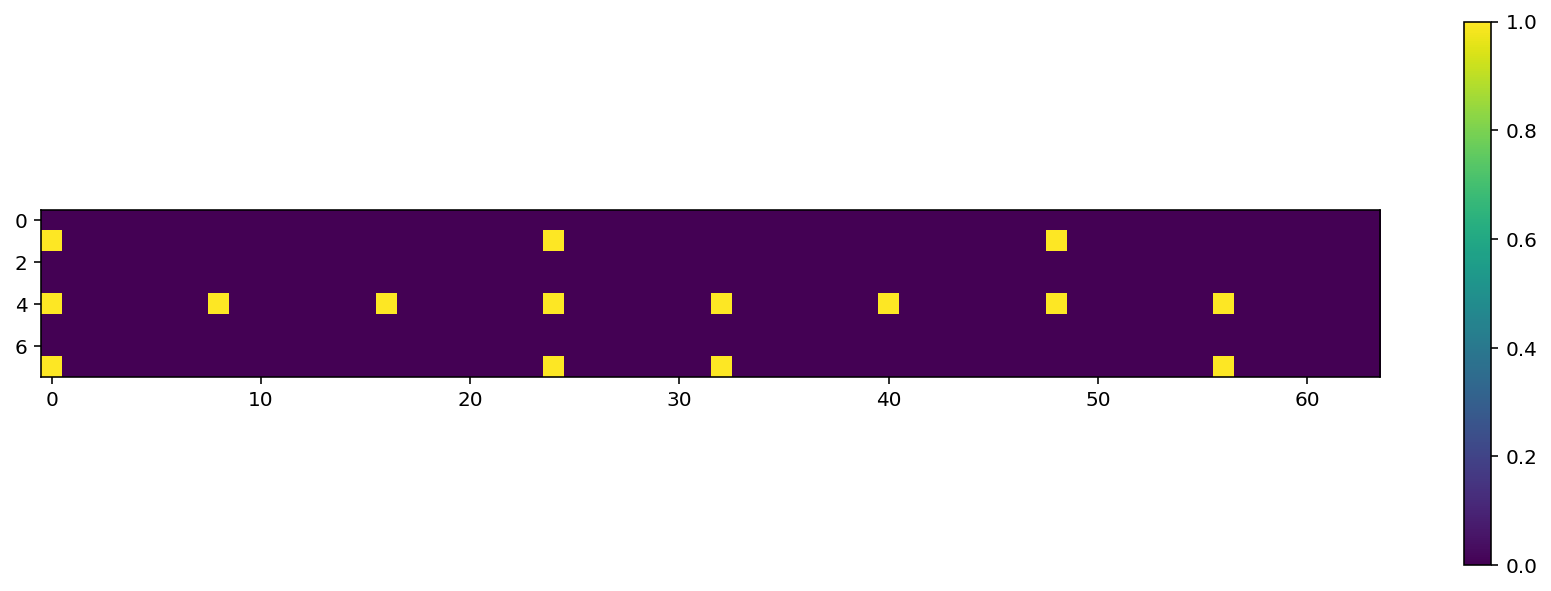

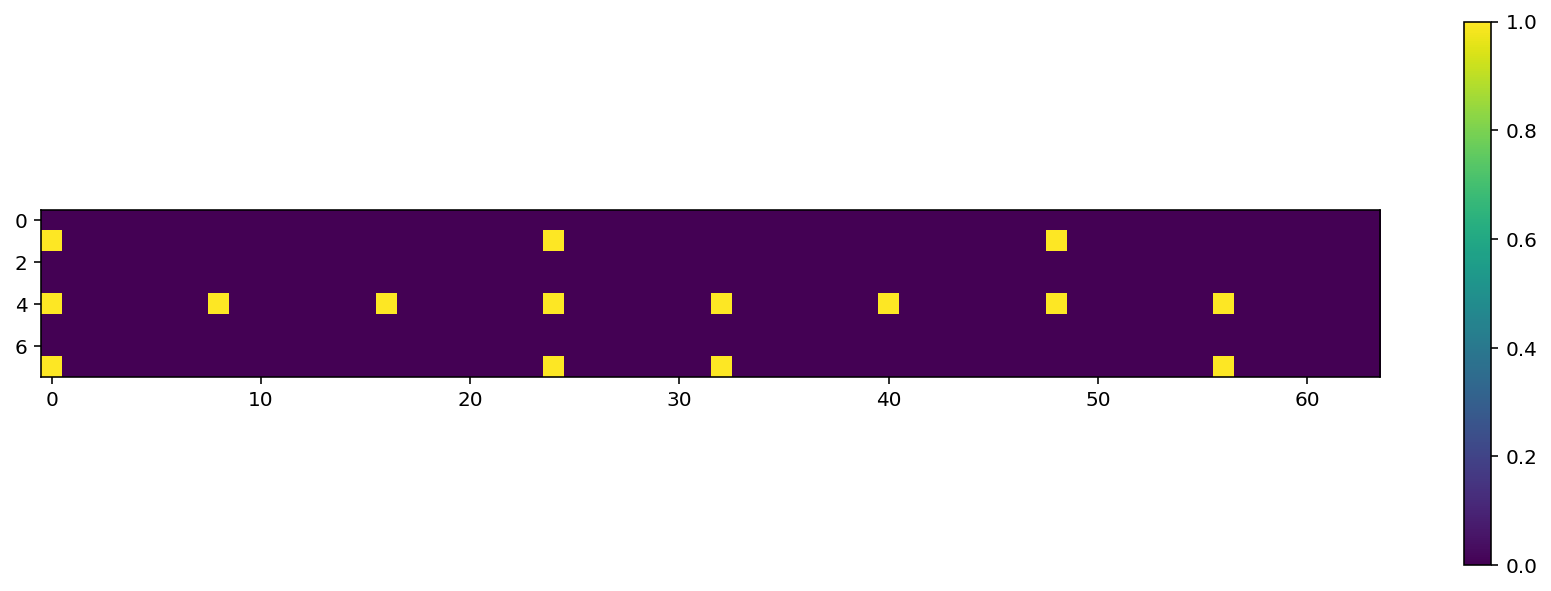

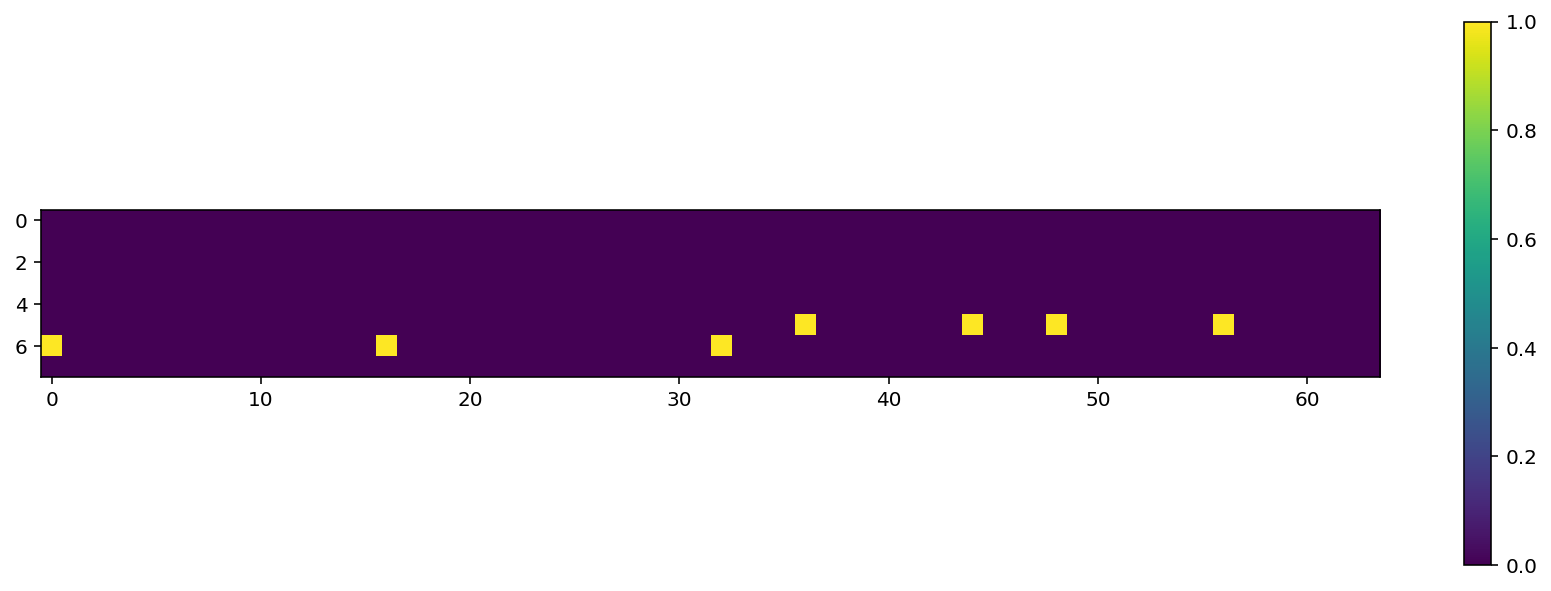

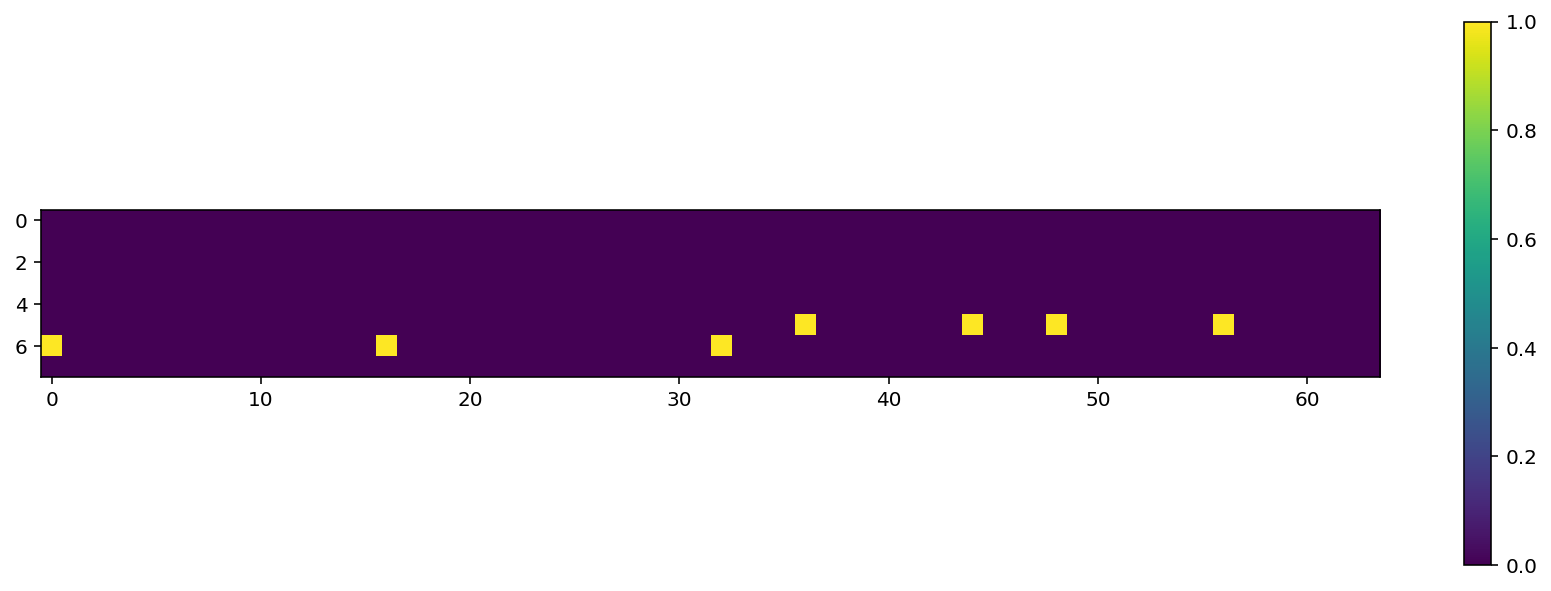

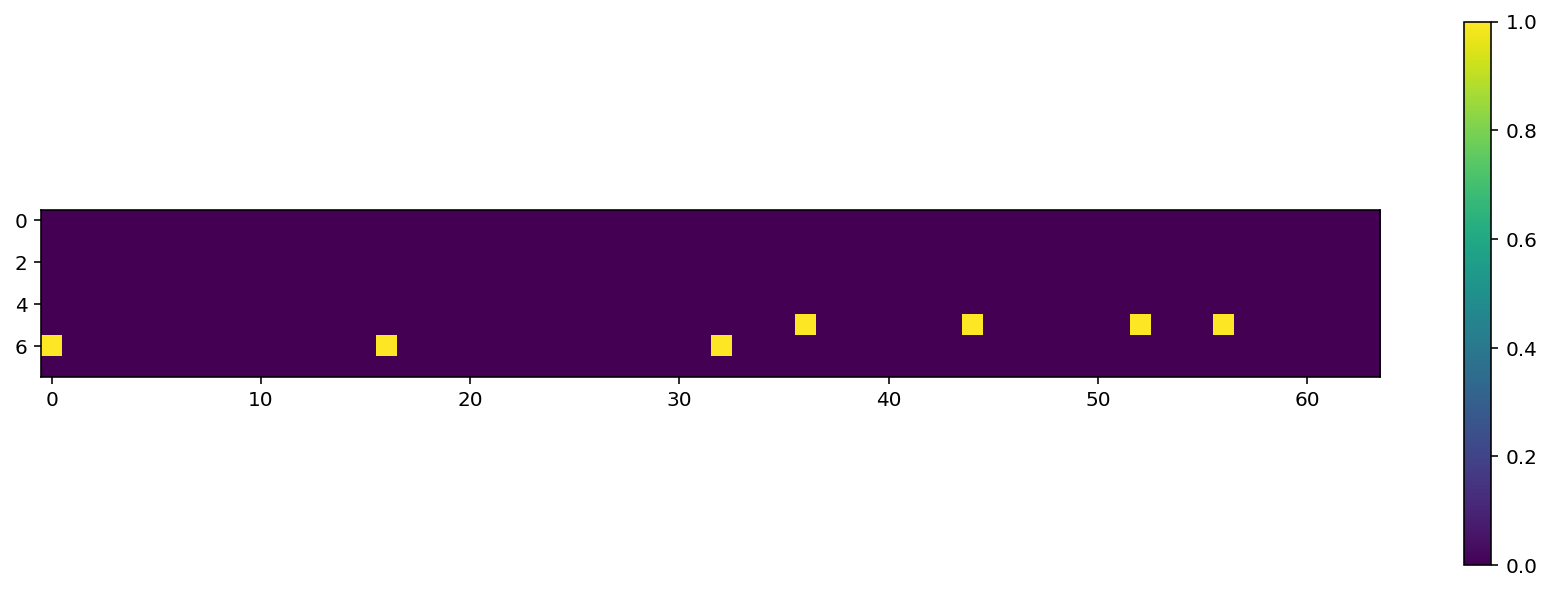

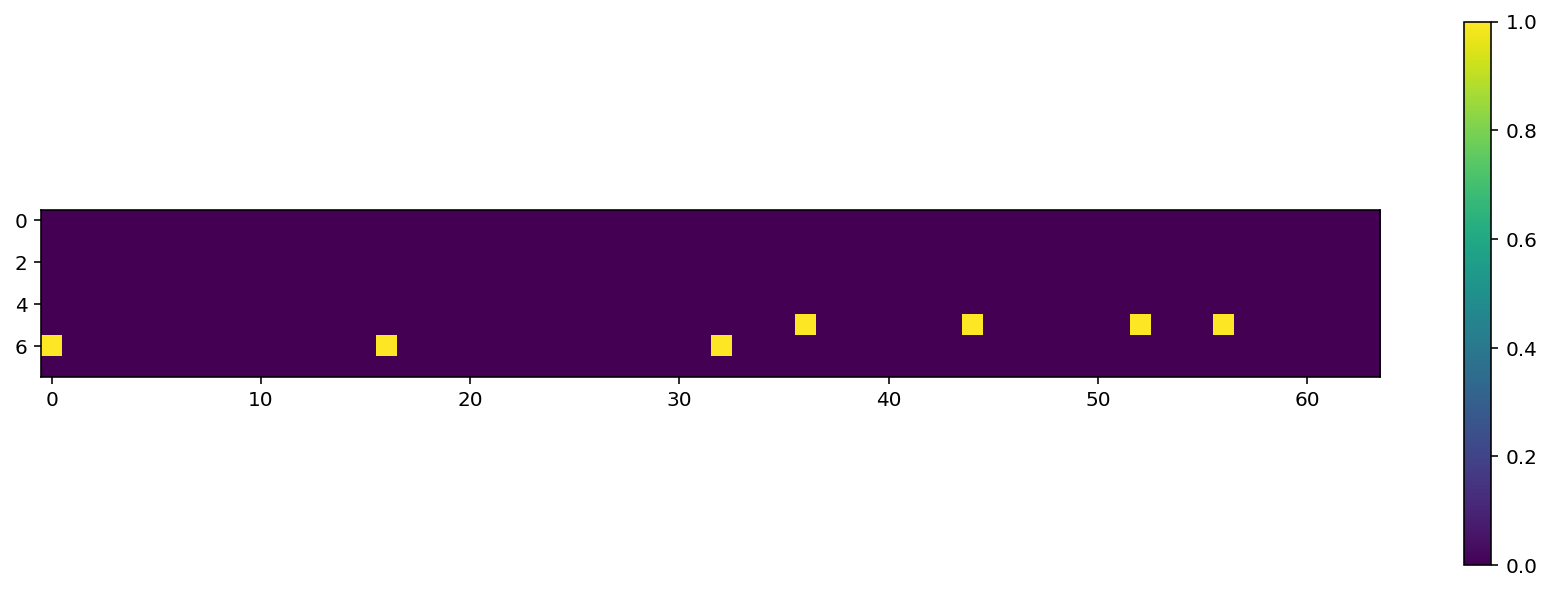

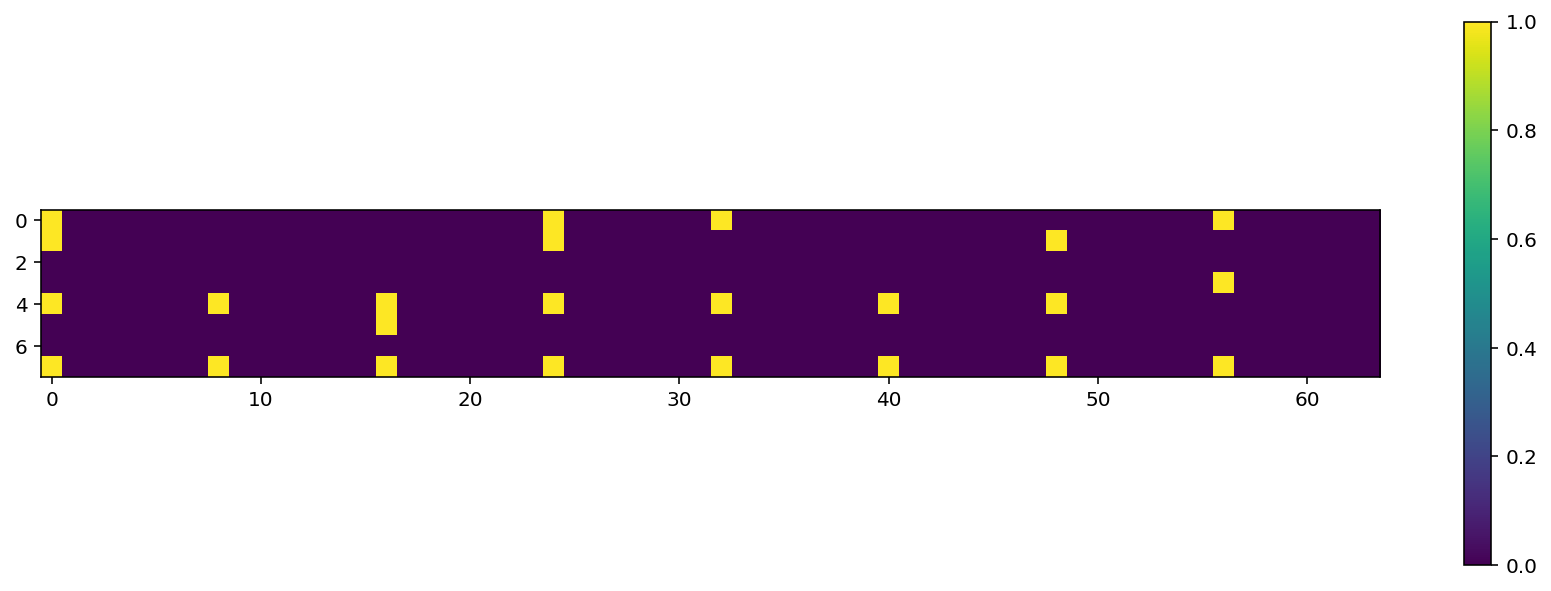

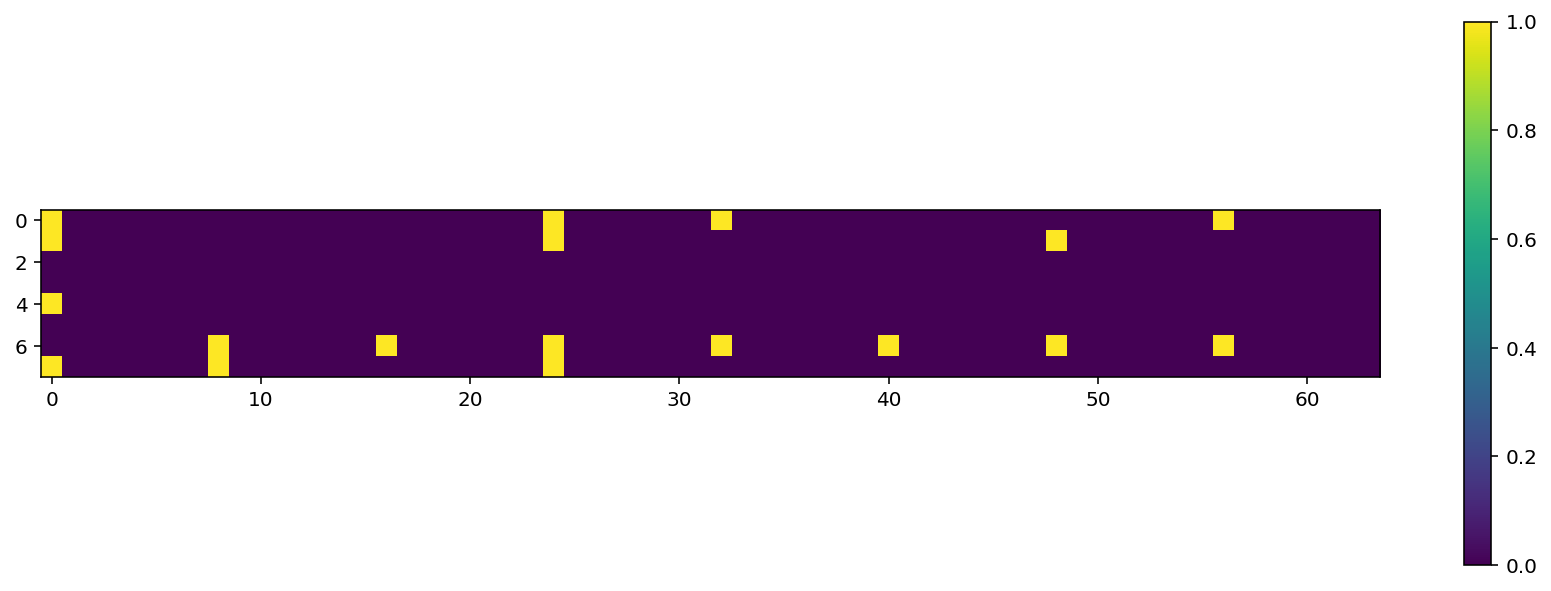

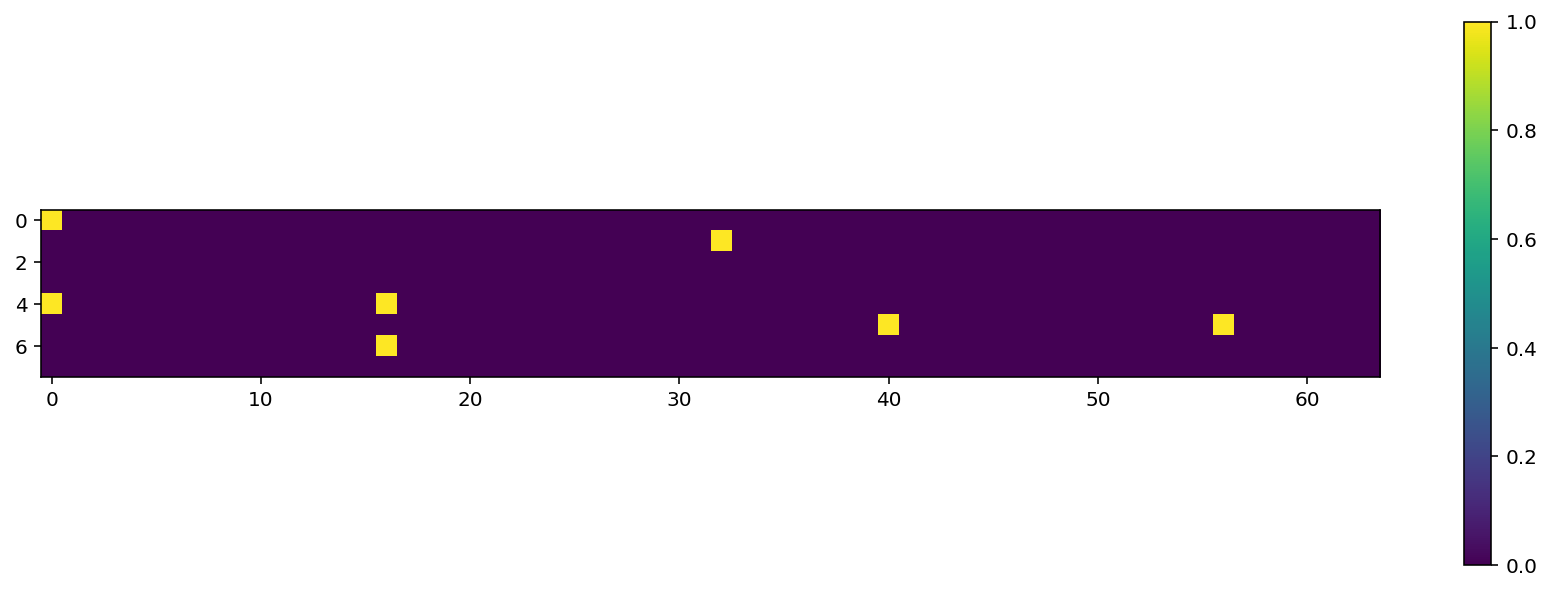

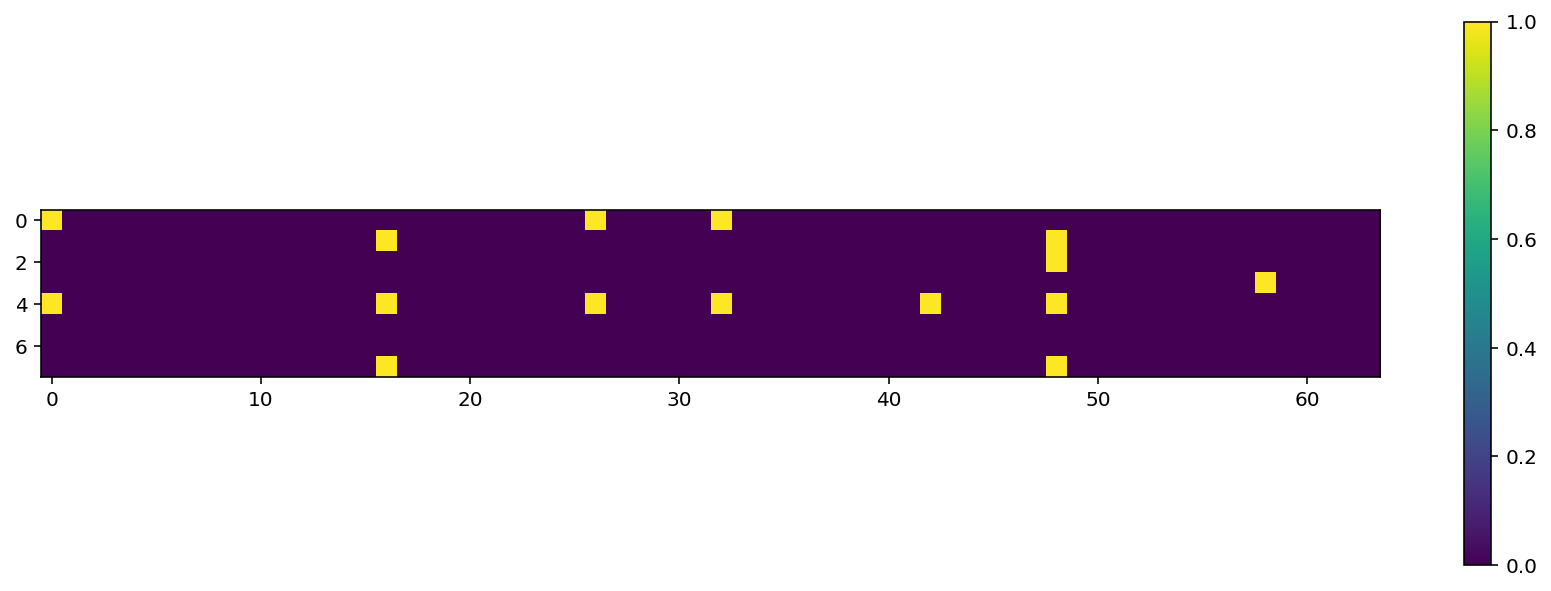

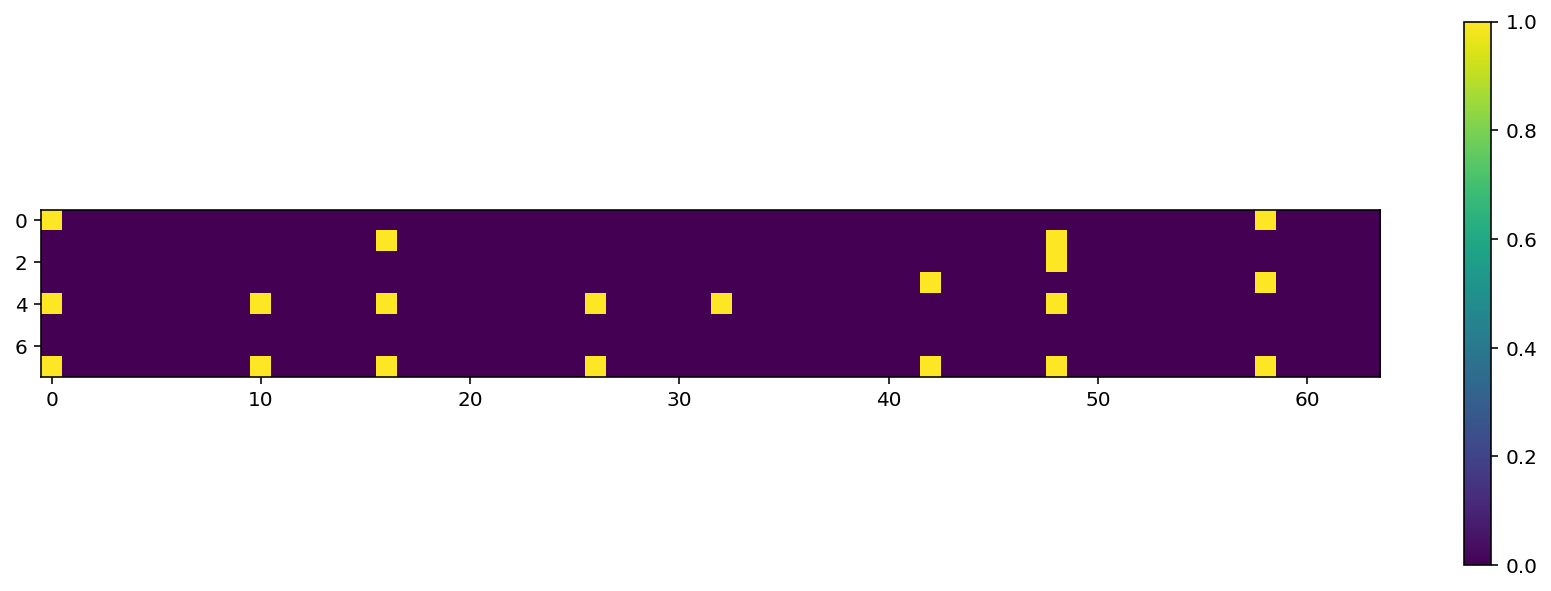

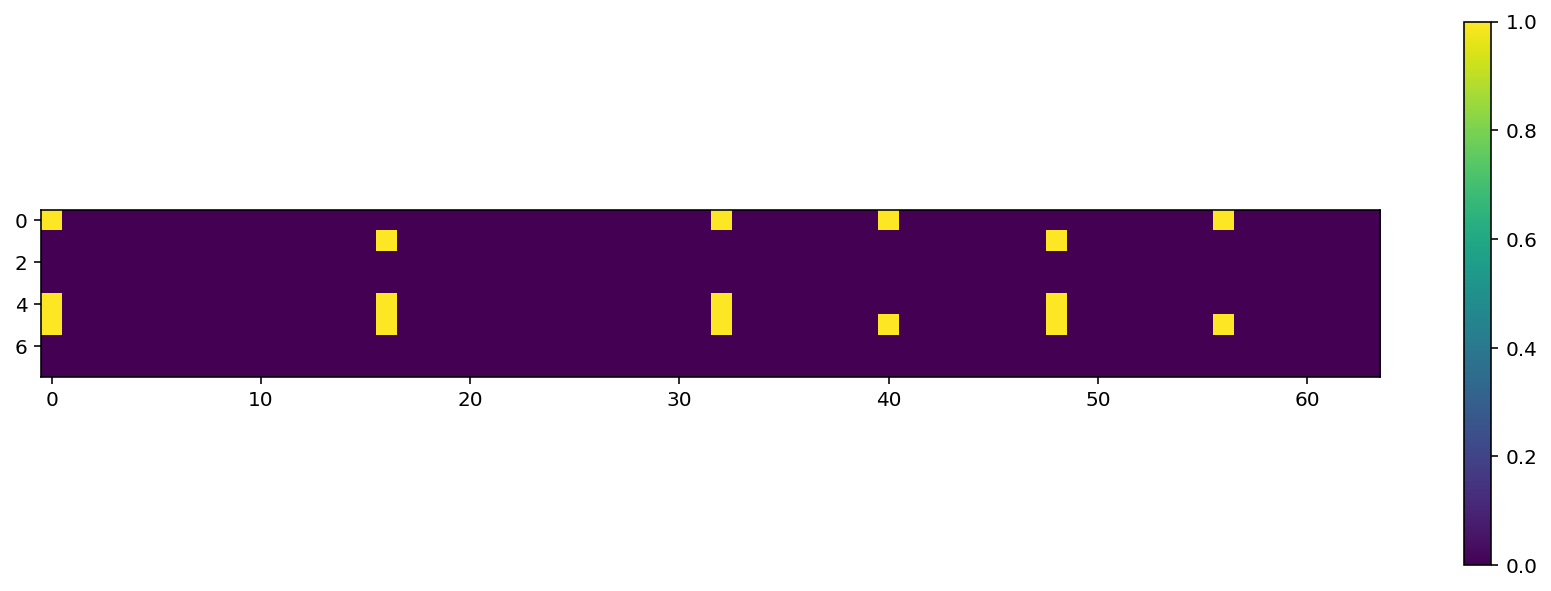

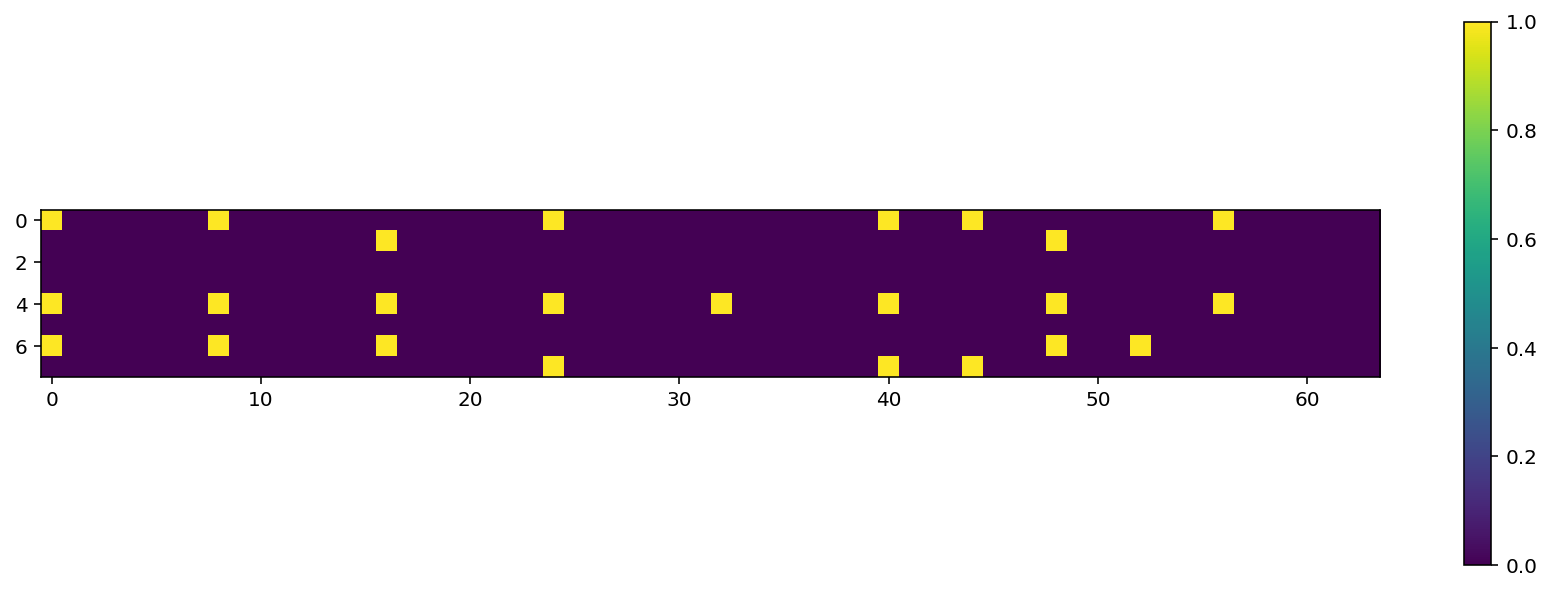

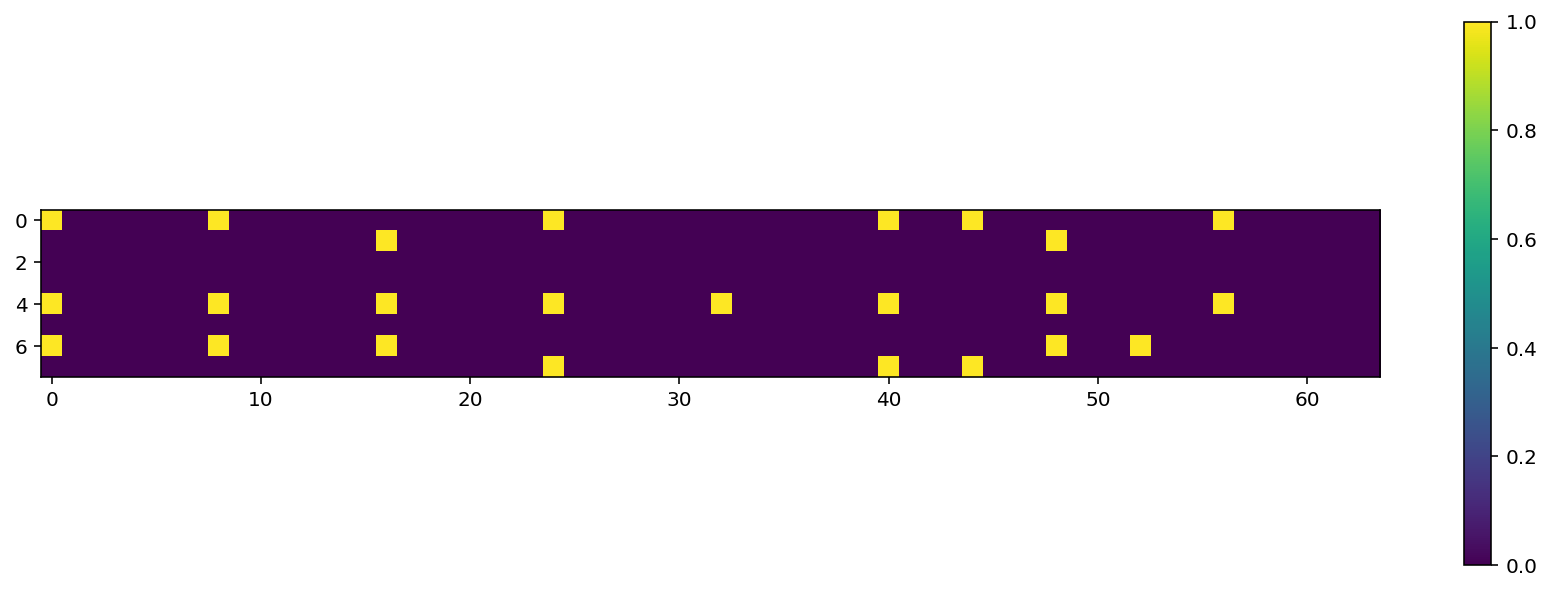

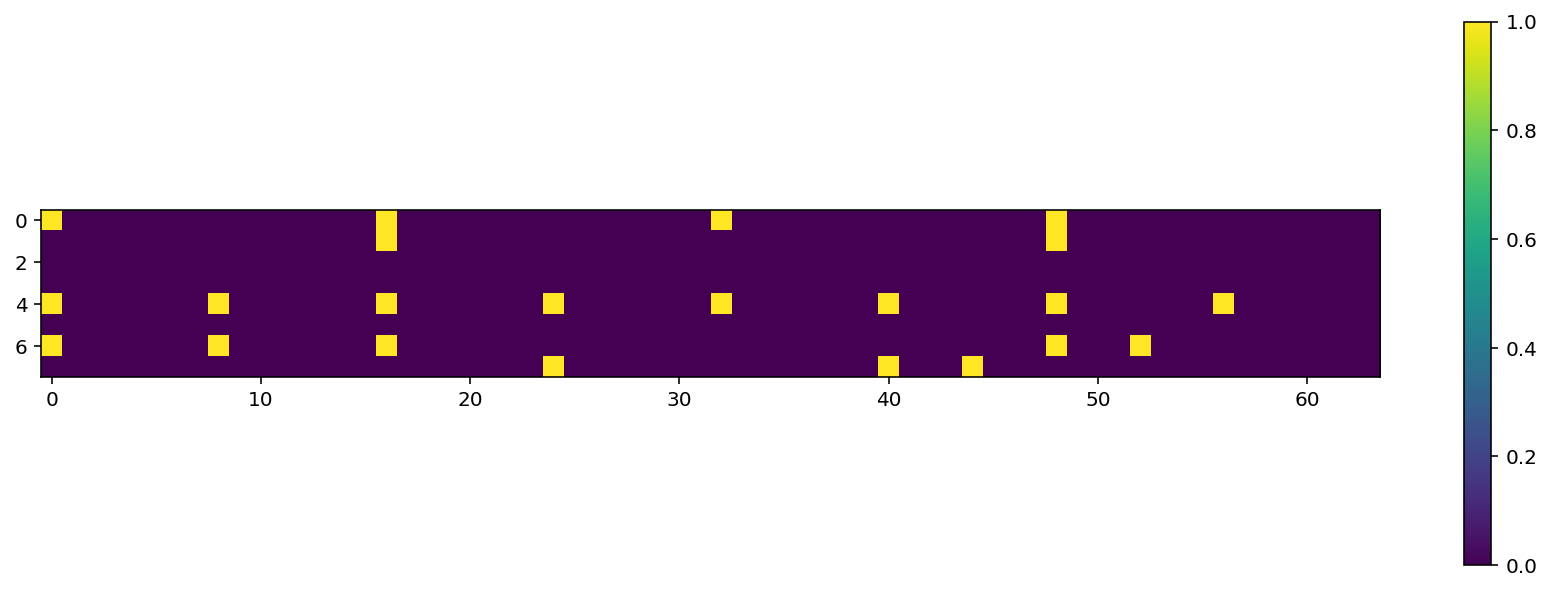

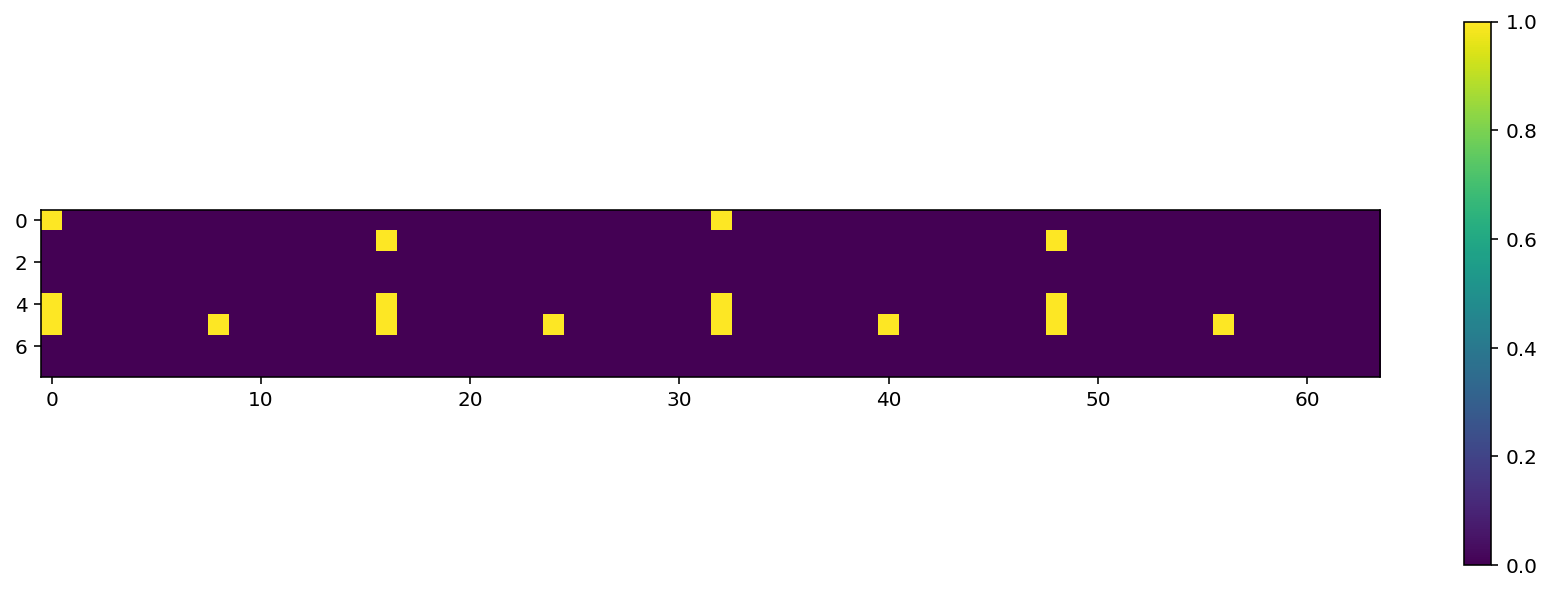

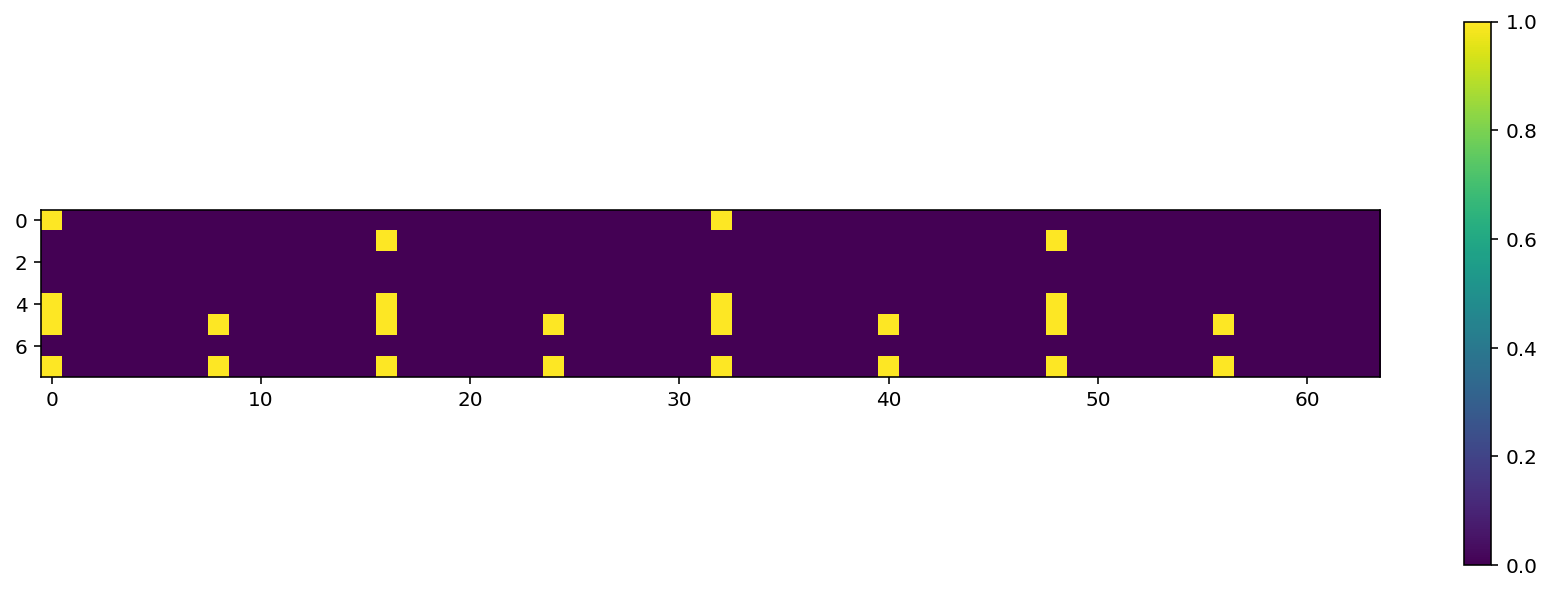

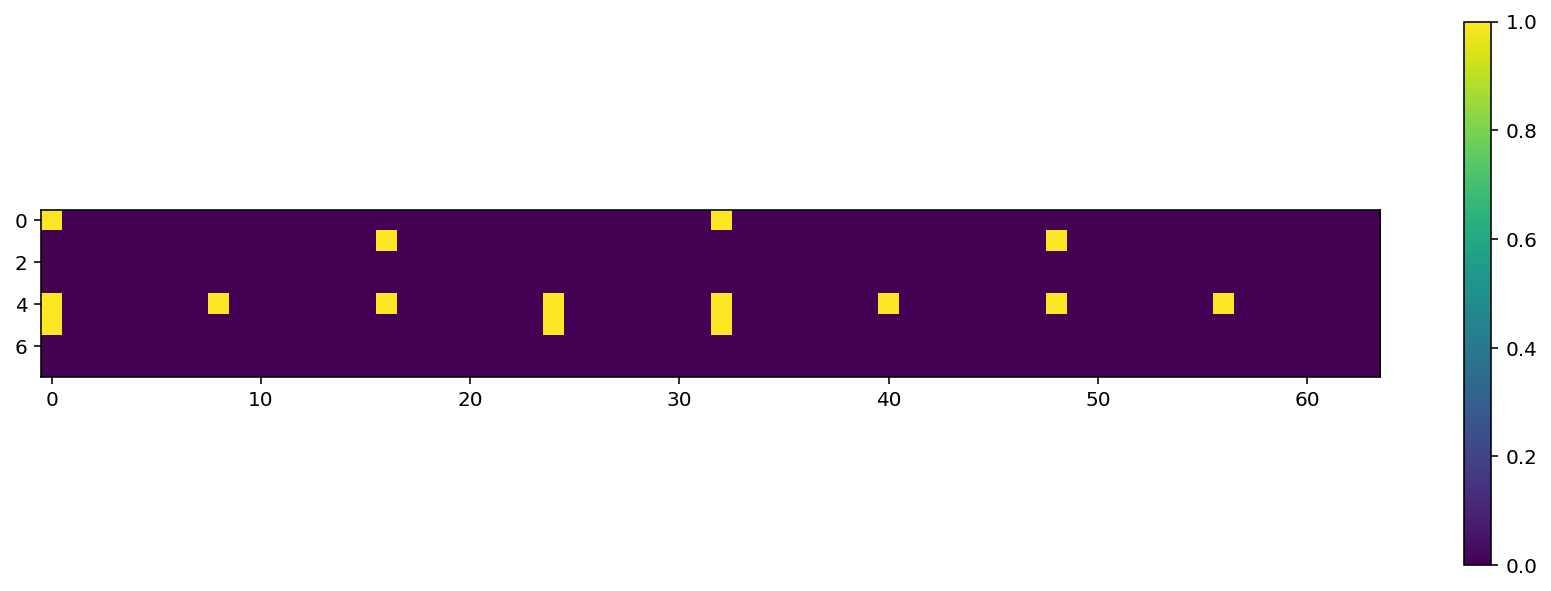

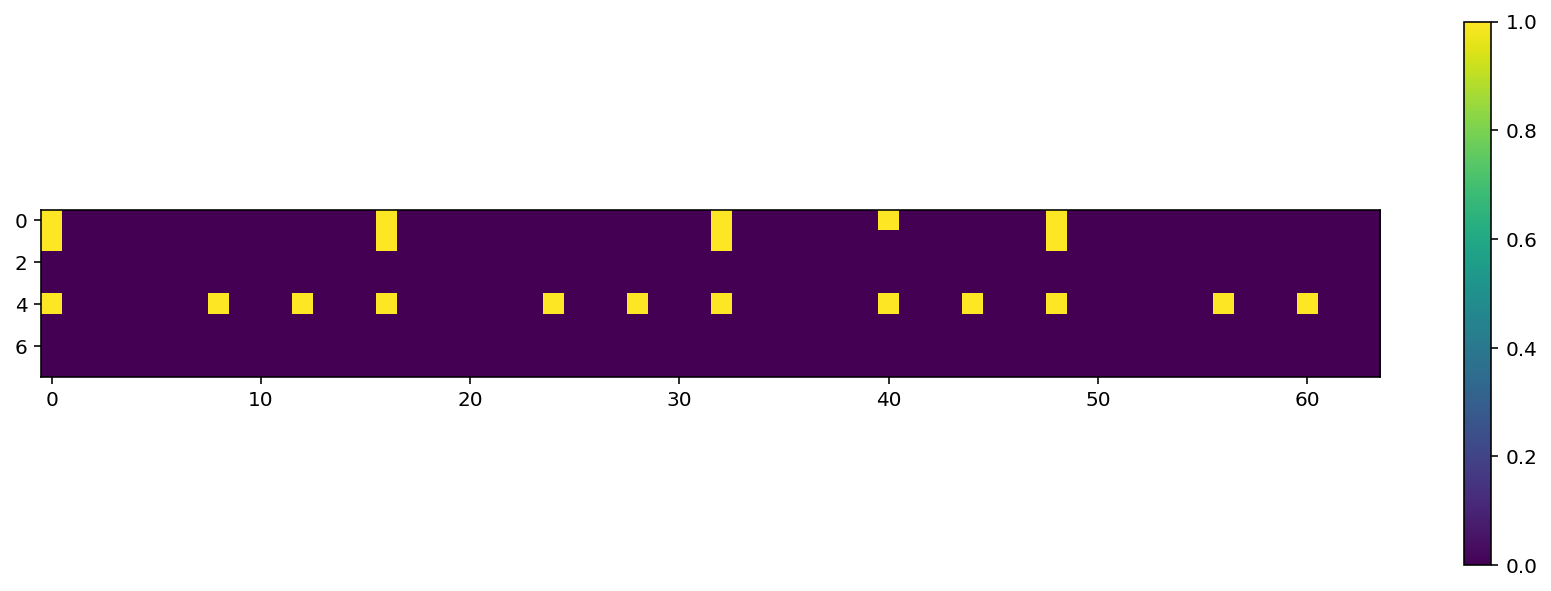

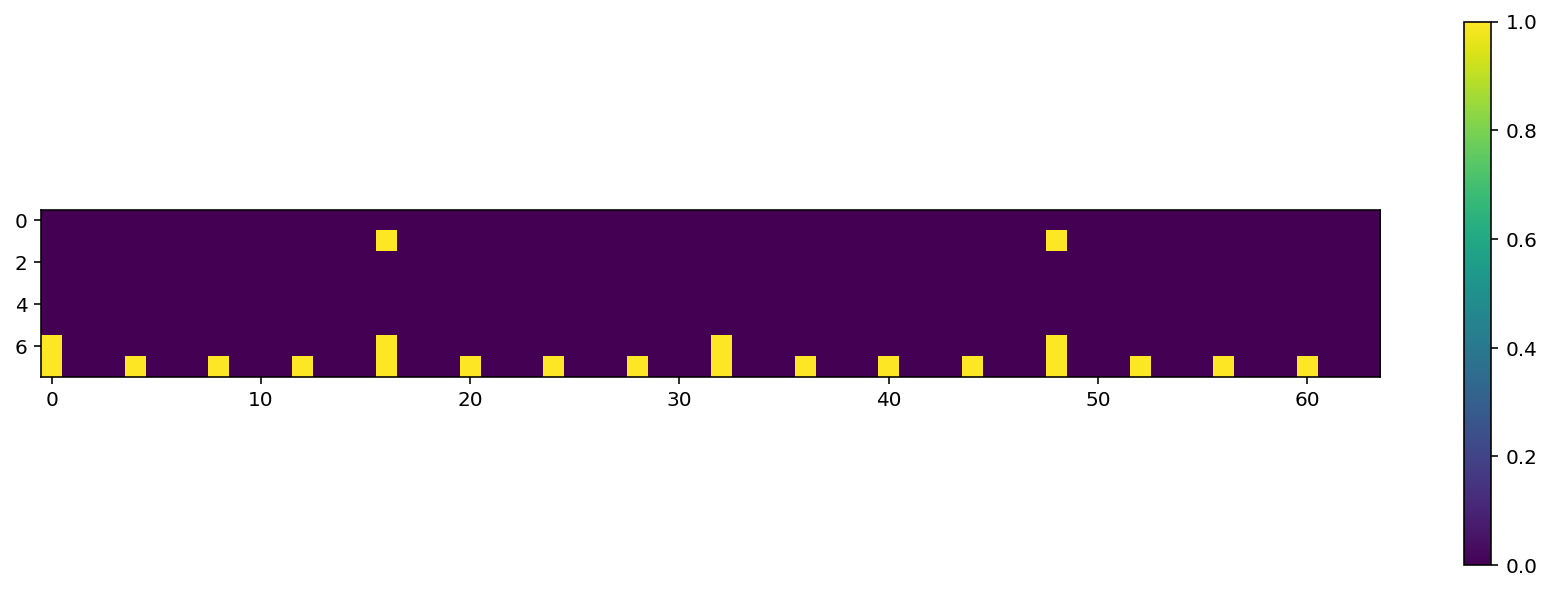

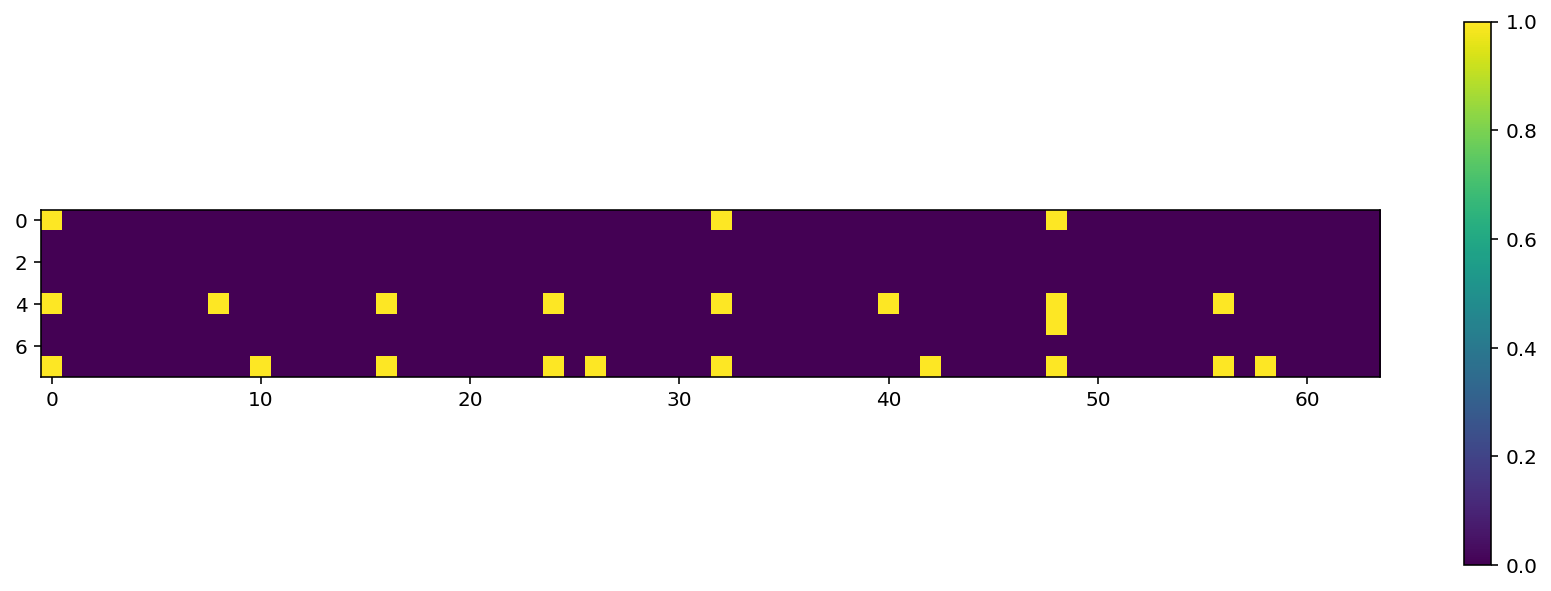

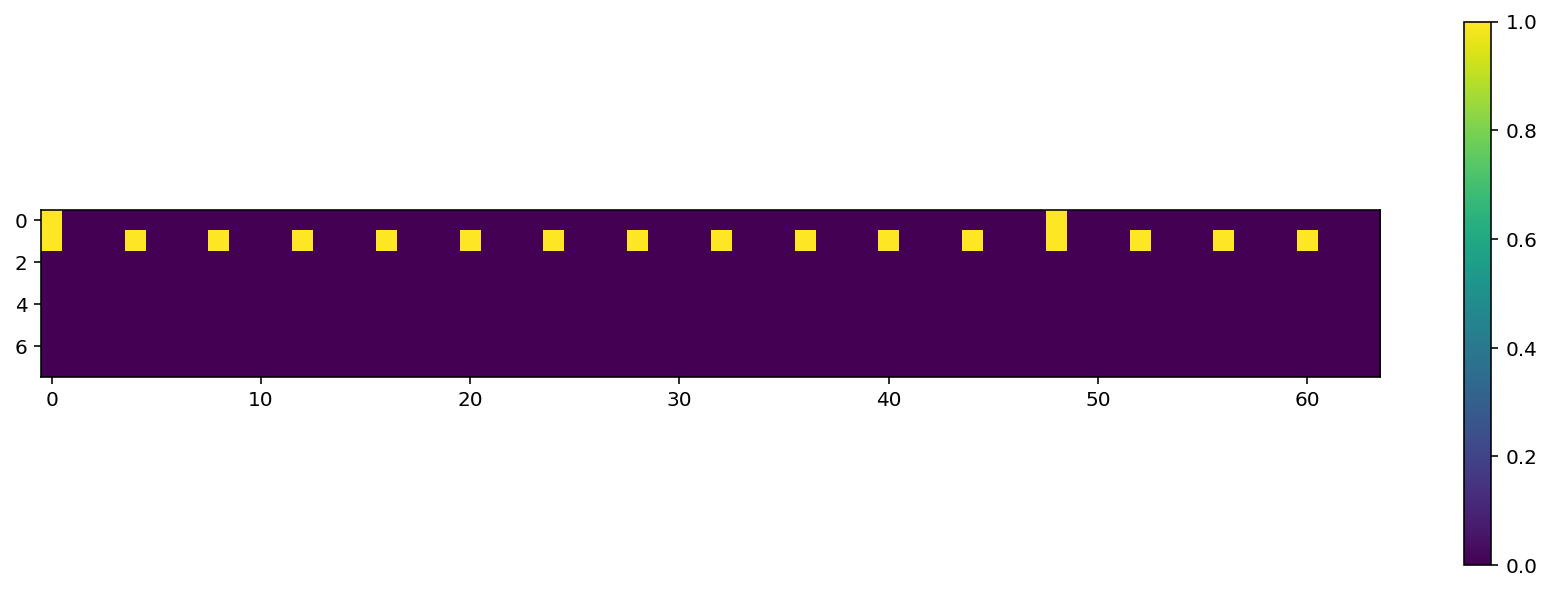

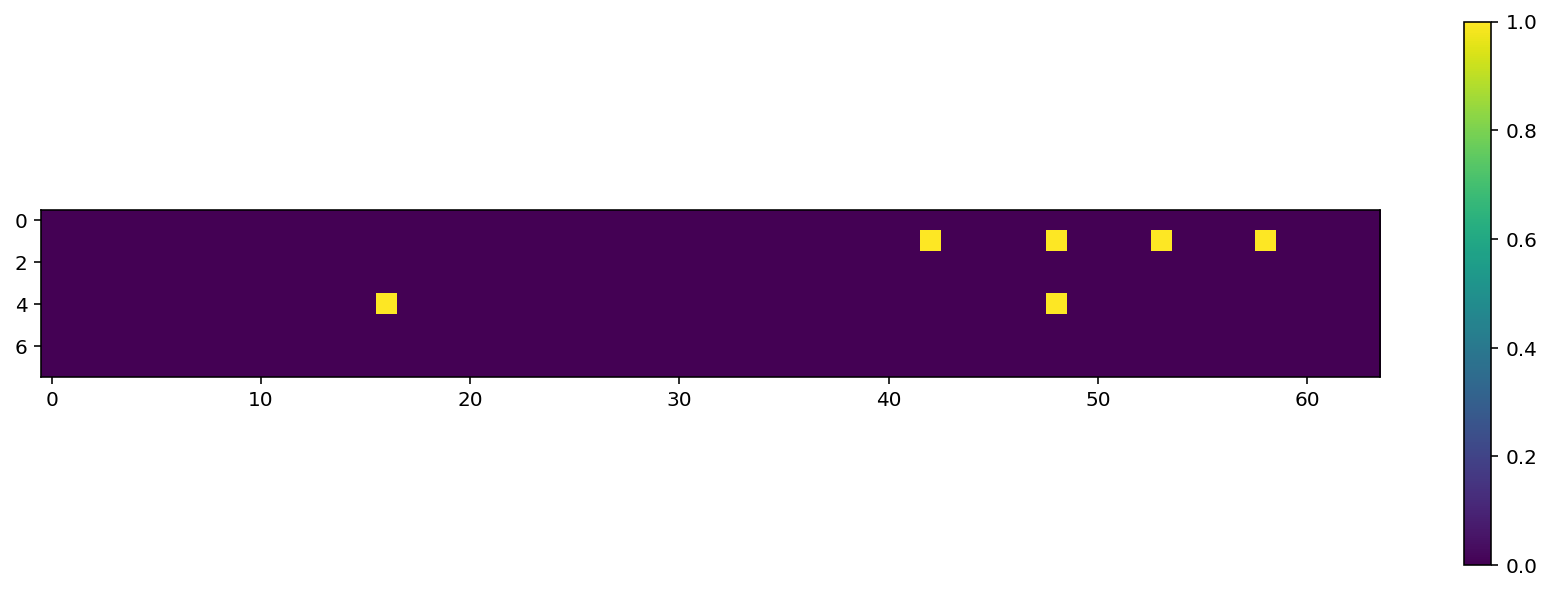

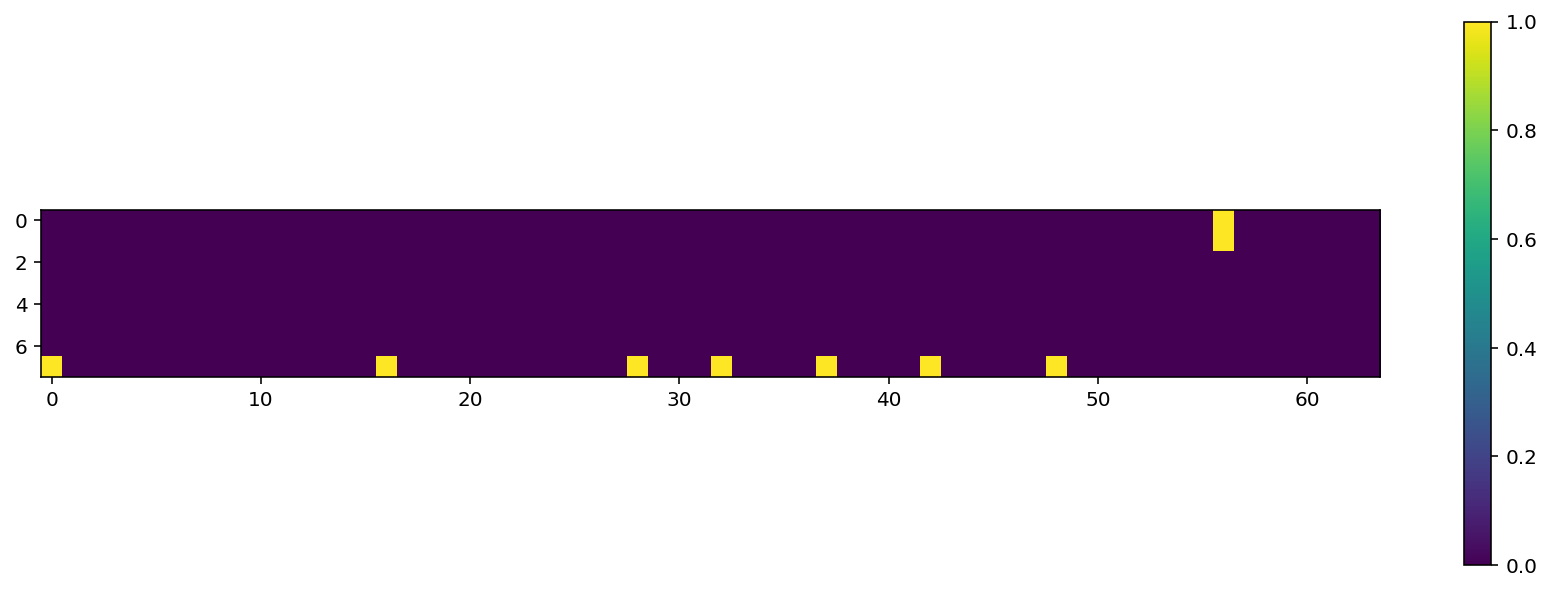

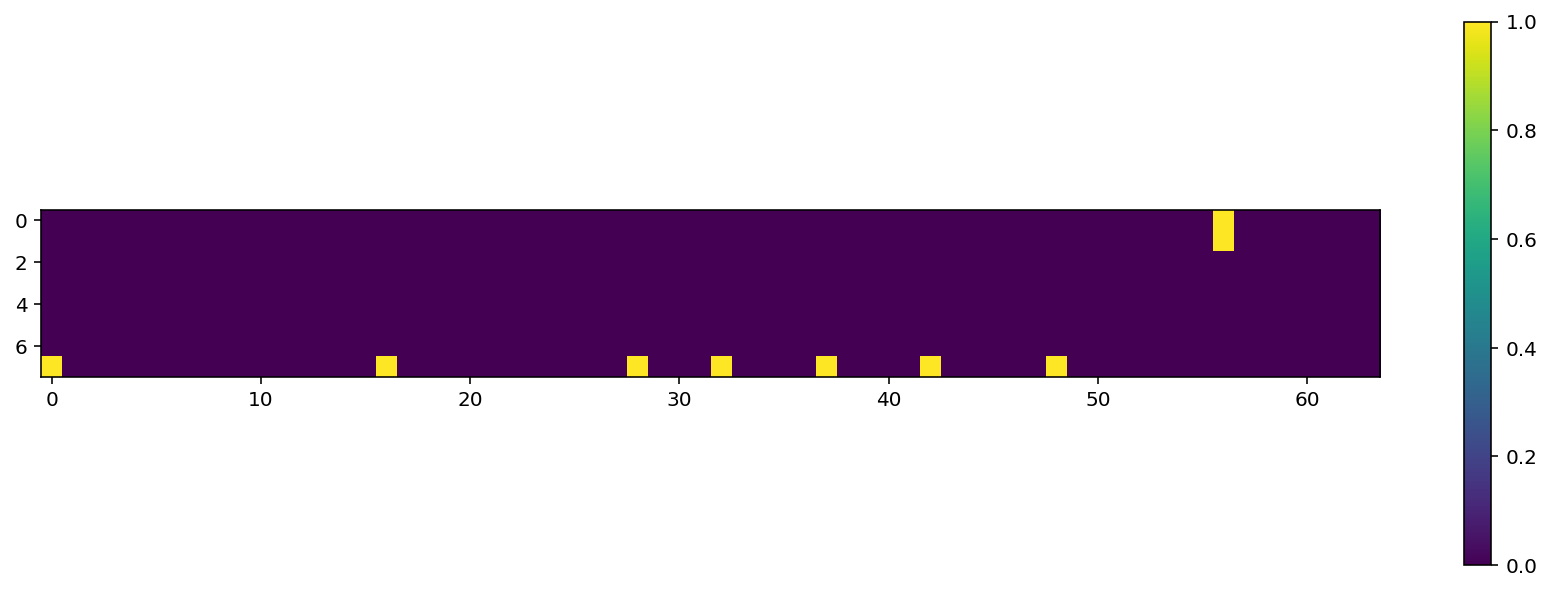

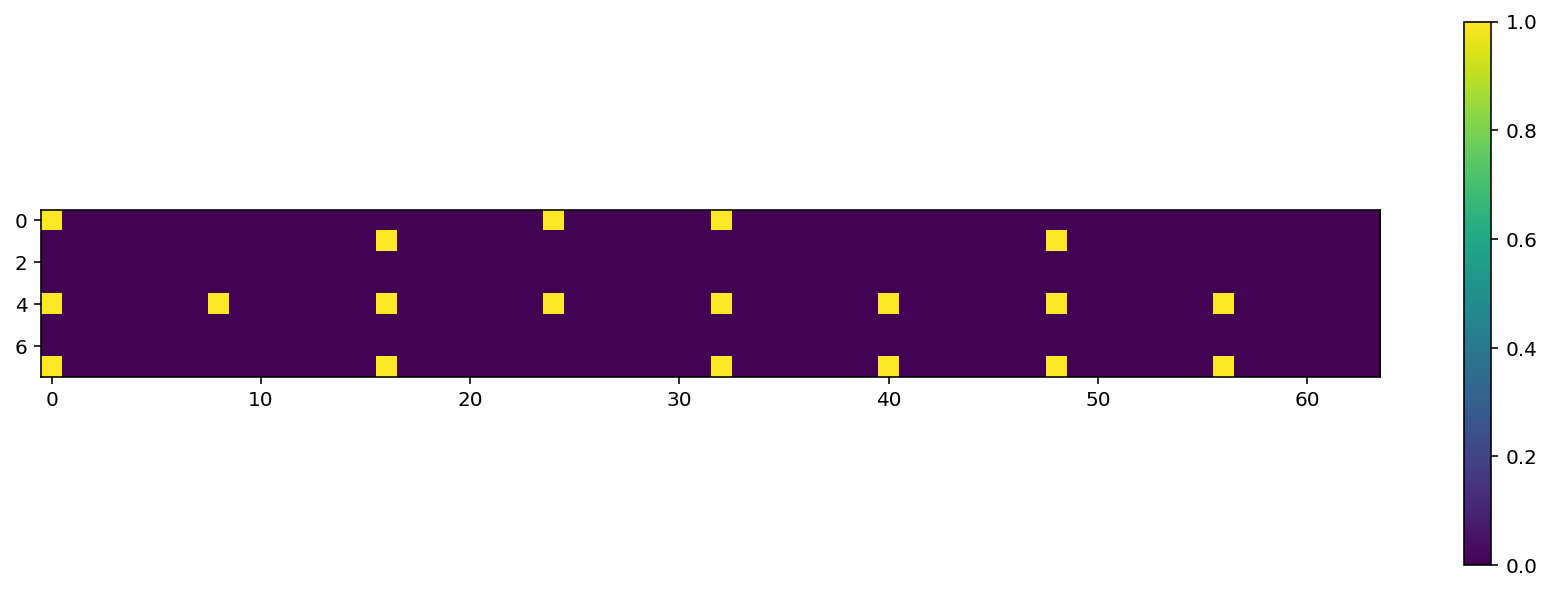

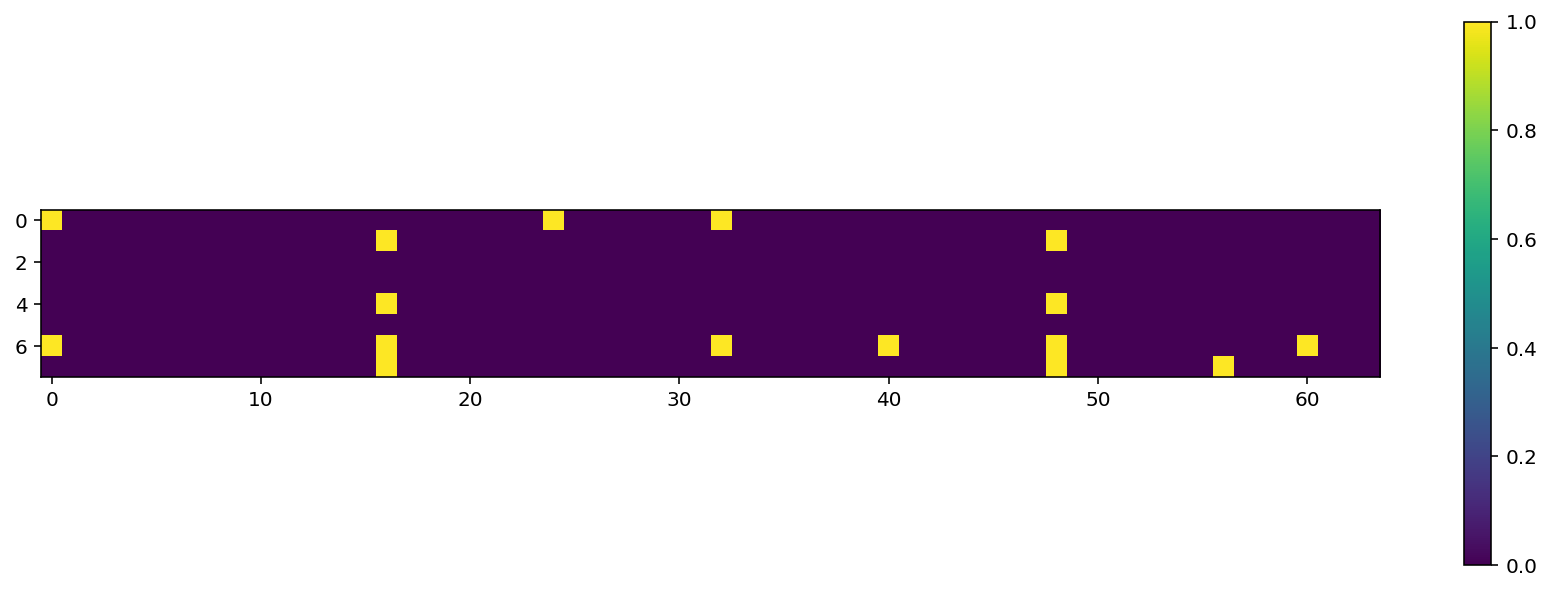

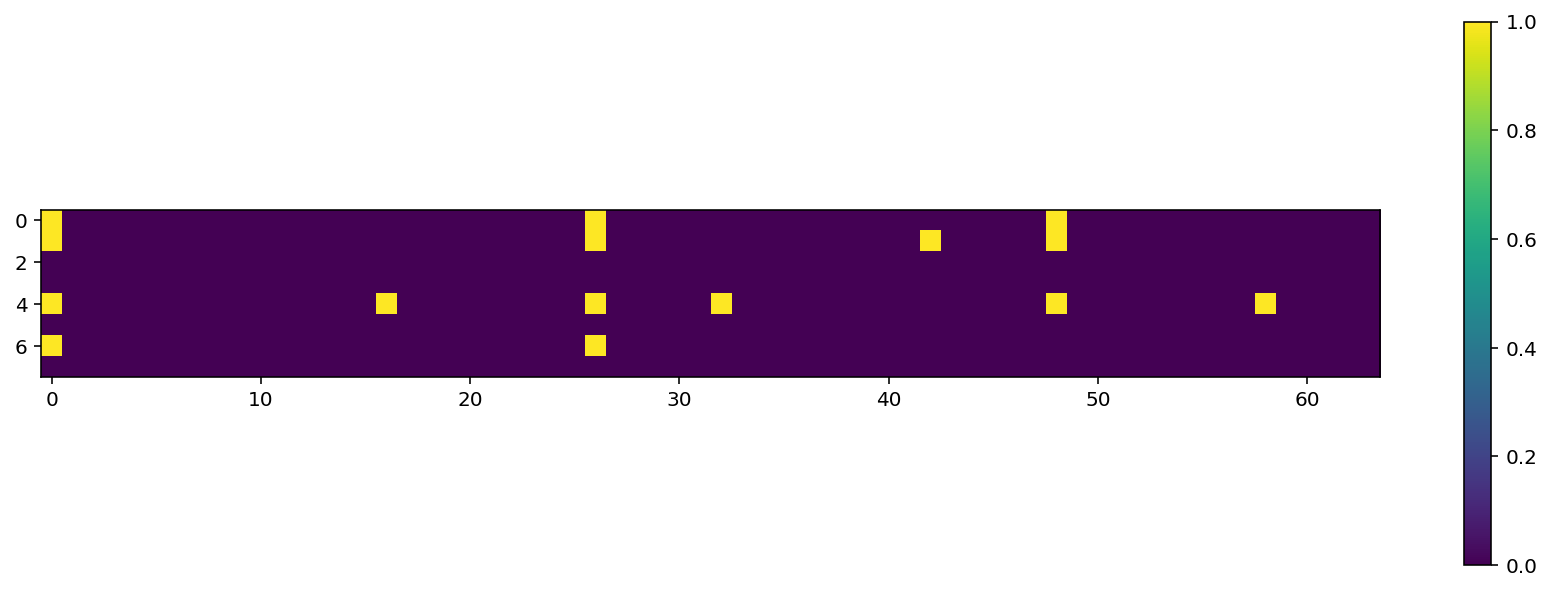

In [9]:
# MAIN

#track_path = os.path.join(root,'a138fnk.mid')
#track_path = os.path.join(root,'(drums)_House#2.mid')
#piece.plot()


#plt.figure(2, figsize=[15,5])
#plt.imshow(np.asarray(activation_matrix))
#plt.colorbar()

#np.save('dataset/test',activation_matrix)

root = r'C:\Users\dell\Desktop\Datasets'
list_dir = os.listdir(root)

for data_file in list_dir:
    if os.path.splitext(data_file)[1] == '.mid' or os.path.splitext(data_file)[1] == '.MID' : #Verification files in the floder are midi files
            #track_path = os.path.join(root,data_file)
            piece,activation_matrix = importMIDI(track_path)
            #save_path = os.path.join('dataset',data_file)
            #np.save(save_path,activation_matrix)
            plt.figure(i, figsize=[15,5])
            plt.imshow(np.asarray(activation_matrix))
            plt.colorbar()


In [141]:
load()

1

In [120]:
path = 'C:\Users\dell\Desktop\Datasets'

print(path+'test')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-120-db6a16fa2231>, line 1)

In [102]:
truc[0,2] = 1
print(truc)

[[0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [93]:
np.int(3/2)

1